In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'exclude'       : ['normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_0_0_0_1_normalized_e_n_e_0_0_e_0_0_basal_seg_data_norm_b25_roi_t1_mask_t1_native_k5_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1078212, 410)
(1078212, 3)
validation
(151755, 410)
(151755, 3)
test
(135990, 410)
(135990, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 410)]             0         


 dense (Dense)               (None, 1024)              420864    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 1110275 (4.24 MB)


Trainable params: 1110275 (4.24 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/108 [..............................] - ETA: 2:39 - loss: 1.1003 - STD: 0.0210 - MAE: 0.4444

  5/108 [>.............................] - ETA: 1s - loss: 1.1396 - STD: 0.0803 - MAE: 0.4444  

  9/108 [=>............................] - ETA: 1s - loss: 1.1275 - STD: 0.0658 - MAE: 0.4442

 13/108 [==>...........................] - ETA: 1s - loss: 1.1224 - STD: 0.0633 - MAE: 0.4441

 17/108 [===>..........................] - ETA: 1s - loss: 1.1172 - STD: 0.0548 - MAE: 0.4441

 21/108 [====>.........................] - ETA: 1s - loss: 1.1138 - STD: 0.0504 - MAE: 0.4440

 25/108 [=====>........................] - ETA: 1s - loss: 1.1110 - STD: 0.0455 - MAE: 0.4439

 29/108 [=======>......................] - ETA: 1s - loss: 1.1085 - STD: 0.0416 - MAE: 0.4437

 33/108 [========>.....................] - ETA: 1s - loss: 1.1062 - STD: 0.0393 - MAE: 0.4435

 37/108 [=========>....................] - ETA: 1s - loss: 1.1034 - STD: 0.0372 - MAE: 0.4431

 41/108 [==========>...................] - ETA: 1s - loss: 1.0999 - STD: 0.0368 - MAE: 0.4425

 45/108 [===========>..................] - ETA: 0s - loss: 1.0947 - STD: 0.0385 - MAE: 0.4413

 49/108 [============>.................] - ETA: 0s - loss: 1.0878 - STD: 0.0426 - MAE: 0.4394

 53/108 [=============>................] - ETA: 0s - loss: 1.0791 - STD: 0.0493 - MAE: 0.4365

 55/108 [==============>...............] - ETA: 1s - loss: 1.0750 - STD: 0.0532 - MAE: 0.4348

 59/108 [===============>..............] - ETA: 1s - loss: 1.0662 - STD: 0.0615 - MAE: 0.4312

 63/108 [================>.............] - ETA: 1s - loss: 1.0578 - STD: 0.0693 - MAE: 0.4275

 67/108 [=================>............] - ETA: 1s - loss: 1.0497 - STD: 0.0758 - MAE: 0.4243

 71/108 [==================>...........] - ETA: 1s - loss: 1.0420 - STD: 0.0814 - MAE: 0.4214

 75/108 [===================>..........] - ETA: 0s - loss: 1.0345 - STD: 0.0869 - MAE: 0.4185

 79/108 [====================>.........] - ETA: 0s - loss: 1.0270 - STD: 0.0924 - MAE: 0.4155

 83/108 [======================>.......] - ETA: 0s - loss: 1.0198 - STD: 0.0980 - MAE: 0.4124

 87/108 [=======================>......] - ETA: 0s - loss: 1.0128 - STD: 0.1032 - MAE: 0.4095

 91/108 [========================>.....] - ETA: 0s - loss: 1.0059 - STD: 0.1081 - MAE: 0.4066

 95/108 [=========================>....] - ETA: 0s - loss: 0.9992 - STD: 0.1128 - MAE: 0.4038

 99/108 [==========================>...] - ETA: 0s - loss: 0.9930 - STD: 0.1175 - MAE: 0.4011

103/108 [===========================>..] - ETA: 0s - loss: 0.9872 - STD: 0.1219 - MAE: 0.3986

107/108 [============================>.] - ETA: 0s - loss: 0.9817 - STD: 0.1260 - MAE: 0.3961

108/108 [==============================] - 5s 32ms/step - loss: 0.9805 - STD: 0.1270 - MAE: 0.3956 - val_loss: 0.8053 - val_STD: 0.2300 - val_MAE: 0.3235


Epoch 2/10000


  1/108 [..............................] - ETA: 3s - loss: 0.8295 - STD: 0.2295 - MAE: 0.3322

  5/108 [>.............................] - ETA: 1s - loss: 0.8376 - STD: 0.2356 - MAE: 0.3316

  9/108 [=>............................] - ETA: 1s - loss: 0.8392 - STD: 0.2369 - MAE: 0.3314

 13/108 [==>...........................] - ETA: 1s - loss: 0.8362 - STD: 0.2367 - MAE: 0.3309

 17/108 [===>..........................] - ETA: 1s - loss: 0.8338 - STD: 0.2368 - MAE: 0.3303

 21/108 [====>.........................] - ETA: 1s - loss: 0.8322 - STD: 0.2370 - MAE: 0.3298

 25/108 [=====>........................] - ETA: 1s - loss: 0.8299 - STD: 0.2381 - MAE: 0.3288

 29/108 [=======>......................] - ETA: 1s - loss: 0.8277 - STD: 0.2392 - MAE: 0.3278

 33/108 [========>.....................] - ETA: 1s - loss: 0.8270 - STD: 0.2402 - MAE: 0.3271

 37/108 [=========>....................] - ETA: 1s - loss: 0.8257 - STD: 0.2403 - MAE: 0.3268

 41/108 [==========>...................] - ETA: 1s - loss: 0.8242 - STD: 0.2406 - MAE: 0.3263

 45/108 [===========>..................] - ETA: 0s - loss: 0.8230 - STD: 0.2411 - MAE: 0.3258

 49/108 [============>.................] - ETA: 0s - loss: 0.8219 - STD: 0.2415 - MAE: 0.3254

 53/108 [=============>................] - ETA: 0s - loss: 0.8205 - STD: 0.2418 - MAE: 0.3249

 57/108 [==============>...............] - ETA: 0s - loss: 0.8192 - STD: 0.2422 - MAE: 0.3245

 61/108 [===============>..............] - ETA: 0s - loss: 0.8175 - STD: 0.2427 - MAE: 0.3238

 65/108 [=================>............] - ETA: 0s - loss: 0.8165 - STD: 0.2435 - MAE: 0.3232

 69/108 [==================>...........] - ETA: 0s - loss: 0.8152 - STD: 0.2440 - MAE: 0.3227

 73/108 [===================>..........] - ETA: 0s - loss: 0.8138 - STD: 0.2447 - MAE: 0.3220

 77/108 [====================>.........] - ETA: 0s - loss: 0.8129 - STD: 0.2453 - MAE: 0.3215

 81/108 [=====================>........] - ETA: 0s - loss: 0.8119 - STD: 0.2460 - MAE: 0.3209

 85/108 [======================>.......] - ETA: 0s - loss: 0.8110 - STD: 0.2466 - MAE: 0.3205

 89/108 [=======================>......] - ETA: 0s - loss: 0.8103 - STD: 0.2471 - MAE: 0.3201

 93/108 [========================>.....] - ETA: 0s - loss: 0.8093 - STD: 0.2476 - MAE: 0.3196

 97/108 [=========================>....] - ETA: 0s - loss: 0.8085 - STD: 0.2481 - MAE: 0.3192

101/108 [===========================>..] - ETA: 0s - loss: 0.8079 - STD: 0.2486 - MAE: 0.3188

105/108 [============================>.] - ETA: 0s - loss: 0.8071 - STD: 0.2489 - MAE: 0.3185

108/108 [==============================] - 2s 18ms/step - loss: 0.8066 - STD: 0.2492 - MAE: 0.3182 - val_loss: 0.7960 - val_STD: 0.2588 - val_MAE: 0.3106


Epoch 3/10000


  1/108 [..............................] - ETA: 4s - loss: 0.7885 - STD: 0.2539 - MAE: 0.3120

  5/108 [>.............................] - ETA: 1s - loss: 0.7827 - STD: 0.2587 - MAE: 0.3082

  9/108 [=>............................] - ETA: 1s - loss: 0.7810 - STD: 0.2599 - MAE: 0.3073

 13/108 [==>...........................] - ETA: 1s - loss: 0.7807 - STD: 0.2607 - MAE: 0.3068

 17/108 [===>..........................] - ETA: 1s - loss: 0.7795 - STD: 0.2615 - MAE: 0.3062

 21/108 [====>.........................] - ETA: 1s - loss: 0.7790 - STD: 0.2616 - MAE: 0.3060

 25/108 [=====>........................] - ETA: 1s - loss: 0.7804 - STD: 0.2620 - MAE: 0.3061

 29/108 [=======>......................] - ETA: 1s - loss: 0.7802 - STD: 0.2619 - MAE: 0.3061

 33/108 [========>.....................] - ETA: 1s - loss: 0.7796 - STD: 0.2613 - MAE: 0.3063

 37/108 [=========>....................] - ETA: 1s - loss: 0.7795 - STD: 0.2615 - MAE: 0.3062

 41/108 [==========>...................] - ETA: 1s - loss: 0.7793 - STD: 0.2621 - MAE: 0.3059

 45/108 [===========>..................] - ETA: 1s - loss: 0.7790 - STD: 0.2625 - MAE: 0.3056

 49/108 [============>.................] - ETA: 0s - loss: 0.7780 - STD: 0.2626 - MAE: 0.3054

 53/108 [=============>................] - ETA: 0s - loss: 0.7769 - STD: 0.2629 - MAE: 0.3050

 57/108 [==============>...............] - ETA: 0s - loss: 0.7757 - STD: 0.2631 - MAE: 0.3046

 61/108 [===============>..............] - ETA: 0s - loss: 0.7750 - STD: 0.2633 - MAE: 0.3044

 65/108 [=================>............] - ETA: 0s - loss: 0.7741 - STD: 0.2636 - MAE: 0.3041

 69/108 [==================>...........] - ETA: 0s - loss: 0.7732 - STD: 0.2641 - MAE: 0.3036

 72/108 [===================>..........] - ETA: 0s - loss: 0.7727 - STD: 0.2644 - MAE: 0.3034

 76/108 [====================>.........] - ETA: 0s - loss: 0.7720 - STD: 0.2647 - MAE: 0.3031

 80/108 [=====================>........] - ETA: 0s - loss: 0.7717 - STD: 0.2648 - MAE: 0.3030

 84/108 [======================>.......] - ETA: 0s - loss: 0.7713 - STD: 0.2648 - MAE: 0.3029

 88/108 [=======================>......] - ETA: 0s - loss: 0.7703 - STD: 0.2650 - MAE: 0.3026

 92/108 [========================>.....] - ETA: 0s - loss: 0.7698 - STD: 0.2652 - MAE: 0.3024

 96/108 [=========================>....] - ETA: 0s - loss: 0.7691 - STD: 0.2654 - MAE: 0.3022

100/108 [==========================>...] - ETA: 0s - loss: 0.7684 - STD: 0.2656 - MAE: 0.3019

104/108 [===========================>..] - ETA: 0s - loss: 0.7677 - STD: 0.2660 - MAE: 0.3016

108/108 [==============================] - ETA: 0s - loss: 0.7671 - STD: 0.2663 - MAE: 0.3013

108/108 [==============================] - 2s 18ms/step - loss: 0.7671 - STD: 0.2663 - MAE: 0.3013 - val_loss: 0.7553 - val_STD: 0.2746 - val_MAE: 0.2941


Epoch 4/10000


  1/108 [..............................] - ETA: 5s - loss: 0.7566 - STD: 0.2726 - MAE: 0.2958

  5/108 [>.............................] - ETA: 1s - loss: 0.7464 - STD: 0.2741 - MAE: 0.2929

  9/108 [=>............................] - ETA: 1s - loss: 0.7473 - STD: 0.2739 - MAE: 0.2933

 13/108 [==>...........................] - ETA: 1s - loss: 0.7459 - STD: 0.2745 - MAE: 0.2927

 17/108 [===>..........................] - ETA: 1s - loss: 0.7460 - STD: 0.2751 - MAE: 0.2923

 21/108 [====>.........................] - ETA: 1s - loss: 0.7469 - STD: 0.2752 - MAE: 0.2925

 25/108 [=====>........................] - ETA: 1s - loss: 0.7477 - STD: 0.2752 - MAE: 0.2927

 29/108 [=======>......................] - ETA: 1s - loss: 0.7476 - STD: 0.2748 - MAE: 0.2928

 33/108 [========>.....................] - ETA: 1s - loss: 0.7470 - STD: 0.2747 - MAE: 0.2928

 37/108 [=========>....................] - ETA: 1s - loss: 0.7463 - STD: 0.2747 - MAE: 0.2926

 41/108 [==========>...................] - ETA: 1s - loss: 0.7457 - STD: 0.2748 - MAE: 0.2925

 45/108 [===========>..................] - ETA: 0s - loss: 0.7455 - STD: 0.2747 - MAE: 0.2925

 49/108 [============>.................] - ETA: 0s - loss: 0.7449 - STD: 0.2748 - MAE: 0.2923

 53/108 [=============>................] - ETA: 0s - loss: 0.7442 - STD: 0.2750 - MAE: 0.2920

 57/108 [==============>...............] - ETA: 0s - loss: 0.7442 - STD: 0.2754 - MAE: 0.2917

 61/108 [===============>..............] - ETA: 0s - loss: 0.7442 - STD: 0.2757 - MAE: 0.2916

 65/108 [=================>............] - ETA: 0s - loss: 0.7437 - STD: 0.2759 - MAE: 0.2914

 69/108 [==================>...........] - ETA: 0s - loss: 0.7436 - STD: 0.2761 - MAE: 0.2912

 73/108 [===================>..........] - ETA: 0s - loss: 0.7436 - STD: 0.2760 - MAE: 0.2913

 77/108 [====================>.........] - ETA: 0s - loss: 0.7430 - STD: 0.2760 - MAE: 0.2912

 81/108 [=====================>........] - ETA: 0s - loss: 0.7425 - STD: 0.2762 - MAE: 0.2909

 85/108 [======================>.......] - ETA: 0s - loss: 0.7420 - STD: 0.2764 - MAE: 0.2907

 89/108 [=======================>......] - ETA: 0s - loss: 0.7419 - STD: 0.2765 - MAE: 0.2906

 93/108 [========================>.....] - ETA: 0s - loss: 0.7419 - STD: 0.2767 - MAE: 0.2905

 97/108 [=========================>....] - ETA: 0s - loss: 0.7414 - STD: 0.2769 - MAE: 0.2903

101/108 [===========================>..] - ETA: 0s - loss: 0.7412 - STD: 0.2770 - MAE: 0.2902

105/108 [============================>.] - ETA: 0s - loss: 0.7410 - STD: 0.2771 - MAE: 0.2901

108/108 [==============================] - 2s 18ms/step - loss: 0.7407 - STD: 0.2772 - MAE: 0.2900 - val_loss: 0.7525 - val_STD: 0.2830 - val_MAE: 0.2887


Epoch 5/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7397 - STD: 0.2823 - MAE: 0.2865

  5/108 [>.............................] - ETA: 1s - loss: 0.7430 - STD: 0.2850 - MAE: 0.2859

  9/108 [=>............................] - ETA: 1s - loss: 0.7421 - STD: 0.2844 - MAE: 0.2862

 13/108 [==>...........................] - ETA: 1s - loss: 0.7432 - STD: 0.2840 - MAE: 0.2867

 17/108 [===>..........................] - ETA: 1s - loss: 0.7426 - STD: 0.2833 - MAE: 0.2869

 21/108 [====>.........................] - ETA: 1s - loss: 0.7402 - STD: 0.2826 - MAE: 0.2868

 25/108 [=====>........................] - ETA: 1s - loss: 0.7392 - STD: 0.2820 - MAE: 0.2869

 29/108 [=======>......................] - ETA: 1s - loss: 0.7388 - STD: 0.2815 - MAE: 0.2872

 33/108 [========>.....................] - ETA: 1s - loss: 0.7375 - STD: 0.2809 - MAE: 0.2872

 37/108 [=========>....................] - ETA: 1s - loss: 0.7364 - STD: 0.2809 - MAE: 0.2870

 41/108 [==========>...................] - ETA: 1s - loss: 0.7358 - STD: 0.2808 - MAE: 0.2869

 45/108 [===========>..................] - ETA: 1s - loss: 0.7347 - STD: 0.2808 - MAE: 0.2867

 49/108 [============>.................] - ETA: 0s - loss: 0.7338 - STD: 0.2811 - MAE: 0.2864

 53/108 [=============>................] - ETA: 0s - loss: 0.7331 - STD: 0.2812 - MAE: 0.2861

 57/108 [==============>...............] - ETA: 0s - loss: 0.7327 - STD: 0.2812 - MAE: 0.2861

 61/108 [===============>..............] - ETA: 0s - loss: 0.7320 - STD: 0.2813 - MAE: 0.2859

 65/108 [=================>............] - ETA: 0s - loss: 0.7320 - STD: 0.2813 - MAE: 0.2859

 69/108 [==================>...........] - ETA: 0s - loss: 0.7318 - STD: 0.2813 - MAE: 0.2858

 73/108 [===================>..........] - ETA: 0s - loss: 0.7318 - STD: 0.2814 - MAE: 0.2858

 77/108 [====================>.........] - ETA: 0s - loss: 0.7313 - STD: 0.2814 - MAE: 0.2857

 81/108 [=====================>........] - ETA: 0s - loss: 0.7310 - STD: 0.2816 - MAE: 0.2855

 85/108 [======================>.......] - ETA: 0s - loss: 0.7307 - STD: 0.2816 - MAE: 0.2855

 89/108 [=======================>......] - ETA: 0s - loss: 0.7306 - STD: 0.2817 - MAE: 0.2854

 93/108 [========================>.....] - ETA: 0s - loss: 0.7304 - STD: 0.2818 - MAE: 0.2853

 97/108 [=========================>....] - ETA: 0s - loss: 0.7301 - STD: 0.2818 - MAE: 0.2852

101/108 [===========================>..] - ETA: 0s - loss: 0.7300 - STD: 0.2819 - MAE: 0.2851

105/108 [============================>.] - ETA: 0s - loss: 0.7299 - STD: 0.2821 - MAE: 0.2850

108/108 [==============================] - 2s 18ms/step - loss: 0.7299 - STD: 0.2821 - MAE: 0.2850 - val_loss: 0.7435 - val_STD: 0.2840 - val_MAE: 0.2856


Epoch 6/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7182 - STD: 0.2770 - MAE: 0.2857

  5/108 [>.............................] - ETA: 1s - loss: 0.7152 - STD: 0.2831 - MAE: 0.2815

  9/108 [=>............................] - ETA: 1s - loss: 0.7169 - STD: 0.2843 - MAE: 0.2812

 13/108 [==>...........................] - ETA: 1s - loss: 0.7175 - STD: 0.2843 - MAE: 0.2813

 17/108 [===>..........................] - ETA: 1s - loss: 0.7174 - STD: 0.2848 - MAE: 0.2810

 21/108 [====>.........................] - ETA: 1s - loss: 0.7185 - STD: 0.2850 - MAE: 0.2811

 25/108 [=====>........................] - ETA: 1s - loss: 0.7186 - STD: 0.2852 - MAE: 0.2810

 29/108 [=======>......................] - ETA: 1s - loss: 0.7196 - STD: 0.2850 - MAE: 0.2813

 33/108 [========>.....................] - ETA: 1s - loss: 0.7193 - STD: 0.2850 - MAE: 0.2812

 37/108 [=========>....................] - ETA: 1s - loss: 0.7189 - STD: 0.2850 - MAE: 0.2812

 41/108 [==========>...................] - ETA: 1s - loss: 0.7189 - STD: 0.2848 - MAE: 0.2812

 45/108 [===========>..................] - ETA: 1s - loss: 0.7193 - STD: 0.2848 - MAE: 0.2813

 49/108 [============>.................] - ETA: 0s - loss: 0.7194 - STD: 0.2850 - MAE: 0.2813

 53/108 [=============>................] - ETA: 0s - loss: 0.7193 - STD: 0.2850 - MAE: 0.2812

 57/108 [==============>...............] - ETA: 0s - loss: 0.7190 - STD: 0.2850 - MAE: 0.2812

 61/108 [===============>..............] - ETA: 0s - loss: 0.7183 - STD: 0.2850 - MAE: 0.2810

 65/108 [=================>............] - ETA: 0s - loss: 0.7183 - STD: 0.2853 - MAE: 0.2809

 69/108 [==================>...........] - ETA: 0s - loss: 0.7180 - STD: 0.2854 - MAE: 0.2807

 73/108 [===================>..........] - ETA: 0s - loss: 0.7177 - STD: 0.2856 - MAE: 0.2806

 77/108 [====================>.........] - ETA: 0s - loss: 0.7181 - STD: 0.2858 - MAE: 0.2805

 81/108 [=====================>........] - ETA: 0s - loss: 0.7184 - STD: 0.2858 - MAE: 0.2806

 85/108 [======================>.......] - ETA: 0s - loss: 0.7185 - STD: 0.2858 - MAE: 0.2805

 89/108 [=======================>......] - ETA: 0s - loss: 0.7185 - STD: 0.2860 - MAE: 0.2805

 93/108 [========================>.....] - ETA: 0s - loss: 0.7183 - STD: 0.2860 - MAE: 0.2804

 97/108 [=========================>....] - ETA: 0s - loss: 0.7184 - STD: 0.2860 - MAE: 0.2804

101/108 [===========================>..] - ETA: 0s - loss: 0.7187 - STD: 0.2862 - MAE: 0.2803

105/108 [============================>.] - ETA: 0s - loss: 0.7189 - STD: 0.2862 - MAE: 0.2804

108/108 [==============================] - 2s 18ms/step - loss: 0.7192 - STD: 0.2863 - MAE: 0.2804 - val_loss: 0.7233 - val_STD: 0.2866 - val_MAE: 0.2801


Epoch 7/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7167 - STD: 0.2850 - MAE: 0.2805

  5/108 [>.............................] - ETA: 1s - loss: 0.7203 - STD: 0.2860 - MAE: 0.2810

  9/108 [=>............................] - ETA: 1s - loss: 0.7200 - STD: 0.2857 - MAE: 0.2810

 13/108 [==>...........................] - ETA: 1s - loss: 0.7198 - STD: 0.2855 - MAE: 0.2812

 17/108 [===>..........................] - ETA: 1s - loss: 0.7198 - STD: 0.2855 - MAE: 0.2811

 21/108 [====>.........................] - ETA: 1s - loss: 0.7192 - STD: 0.2856 - MAE: 0.2809

 25/108 [=====>........................] - ETA: 1s - loss: 0.7180 - STD: 0.2856 - MAE: 0.2806

 29/108 [=======>......................] - ETA: 1s - loss: 0.7172 - STD: 0.2855 - MAE: 0.2805

 33/108 [========>.....................] - ETA: 1s - loss: 0.7168 - STD: 0.2855 - MAE: 0.2804

 37/108 [=========>....................] - ETA: 1s - loss: 0.7161 - STD: 0.2857 - MAE: 0.2801

 41/108 [==========>...................] - ETA: 1s - loss: 0.7160 - STD: 0.2858 - MAE: 0.2801

 45/108 [===========>..................] - ETA: 1s - loss: 0.7168 - STD: 0.2862 - MAE: 0.2800

 49/108 [============>.................] - ETA: 0s - loss: 0.7172 - STD: 0.2864 - MAE: 0.2800

 53/108 [=============>................] - ETA: 0s - loss: 0.7173 - STD: 0.2864 - MAE: 0.2800

 57/108 [==============>...............] - ETA: 0s - loss: 0.7174 - STD: 0.2862 - MAE: 0.2802

 61/108 [===============>..............] - ETA: 0s - loss: 0.7168 - STD: 0.2860 - MAE: 0.2801

 65/108 [=================>............] - ETA: 0s - loss: 0.7165 - STD: 0.2863 - MAE: 0.2799

 69/108 [==================>...........] - ETA: 0s - loss: 0.7160 - STD: 0.2866 - MAE: 0.2796

 73/108 [===================>..........] - ETA: 0s - loss: 0.7165 - STD: 0.2868 - MAE: 0.2796

 77/108 [====================>.........] - ETA: 0s - loss: 0.7164 - STD: 0.2872 - MAE: 0.2794

 81/108 [=====================>........] - ETA: 0s - loss: 0.7167 - STD: 0.2874 - MAE: 0.2793

 85/108 [======================>.......] - ETA: 0s - loss: 0.7166 - STD: 0.2875 - MAE: 0.2792

 89/108 [=======================>......] - ETA: 0s - loss: 0.7165 - STD: 0.2874 - MAE: 0.2793

 93/108 [========================>.....] - ETA: 0s - loss: 0.7163 - STD: 0.2874 - MAE: 0.2792

 97/108 [=========================>....] - ETA: 0s - loss: 0.7161 - STD: 0.2875 - MAE: 0.2791

101/108 [===========================>..] - ETA: 0s - loss: 0.7162 - STD: 0.2874 - MAE: 0.2792

105/108 [============================>.] - ETA: 0s - loss: 0.7163 - STD: 0.2873 - MAE: 0.2793

108/108 [==============================] - 2s 18ms/step - loss: 0.7162 - STD: 0.2872 - MAE: 0.2793 - val_loss: 0.7162 - val_STD: 0.2952 - val_MAE: 0.2724


Epoch 8/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7041 - STD: 0.2868 - MAE: 0.2770

  5/108 [>.............................] - ETA: 1s - loss: 0.7117 - STD: 0.2879 - MAE: 0.2781

  9/108 [=>............................] - ETA: 1s - loss: 0.7082 - STD: 0.2883 - MAE: 0.2770

 13/108 [==>...........................] - ETA: 1s - loss: 0.7081 - STD: 0.2893 - MAE: 0.2764

 17/108 [===>..........................] - ETA: 1s - loss: 0.7079 - STD: 0.2900 - MAE: 0.2759

 21/108 [====>.........................] - ETA: 1s - loss: 0.7075 - STD: 0.2899 - MAE: 0.2758

 25/108 [=====>........................] - ETA: 1s - loss: 0.7081 - STD: 0.2898 - MAE: 0.2761

 29/108 [=======>......................] - ETA: 1s - loss: 0.7082 - STD: 0.2898 - MAE: 0.2761

 33/108 [========>.....................] - ETA: 1s - loss: 0.7090 - STD: 0.2899 - MAE: 0.2762

 37/108 [=========>....................] - ETA: 1s - loss: 0.7091 - STD: 0.2896 - MAE: 0.2764

 41/108 [==========>...................] - ETA: 1s - loss: 0.7093 - STD: 0.2894 - MAE: 0.2766

 45/108 [===========>..................] - ETA: 1s - loss: 0.7091 - STD: 0.2895 - MAE: 0.2765

 49/108 [============>.................] - ETA: 0s - loss: 0.7096 - STD: 0.2895 - MAE: 0.2766

 53/108 [=============>................] - ETA: 0s - loss: 0.7093 - STD: 0.2893 - MAE: 0.2766

 57/108 [==============>...............] - ETA: 0s - loss: 0.7090 - STD: 0.2894 - MAE: 0.2765

 61/108 [===============>..............] - ETA: 0s - loss: 0.7089 - STD: 0.2895 - MAE: 0.2764

 65/108 [=================>............] - ETA: 0s - loss: 0.7084 - STD: 0.2896 - MAE: 0.2763

 69/108 [==================>...........] - ETA: 0s - loss: 0.7082 - STD: 0.2897 - MAE: 0.2762

 73/108 [===================>..........] - ETA: 0s - loss: 0.7082 - STD: 0.2898 - MAE: 0.2761

 77/108 [====================>.........] - ETA: 0s - loss: 0.7082 - STD: 0.2898 - MAE: 0.2761

 81/108 [=====================>........] - ETA: 0s - loss: 0.7081 - STD: 0.2898 - MAE: 0.2761

 85/108 [======================>.......] - ETA: 0s - loss: 0.7084 - STD: 0.2899 - MAE: 0.2761

 89/108 [=======================>......] - ETA: 0s - loss: 0.7085 - STD: 0.2899 - MAE: 0.2761

 93/108 [========================>.....] - ETA: 0s - loss: 0.7084 - STD: 0.2898 - MAE: 0.2761

 97/108 [=========================>....] - ETA: 0s - loss: 0.7081 - STD: 0.2898 - MAE: 0.2761

101/108 [===========================>..] - ETA: 0s - loss: 0.7078 - STD: 0.2898 - MAE: 0.2760

105/108 [============================>.] - ETA: 0s - loss: 0.7076 - STD: 0.2899 - MAE: 0.2759

108/108 [==============================] - 2s 18ms/step - loss: 0.7074 - STD: 0.2899 - MAE: 0.2759 - val_loss: 0.7043 - val_STD: 0.2961 - val_MAE: 0.2702


Epoch 9/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7152 - STD: 0.2908 - MAE: 0.2768

  5/108 [>.............................] - ETA: 1s - loss: 0.7092 - STD: 0.2909 - MAE: 0.2755

  9/108 [=>............................] - ETA: 1s - loss: 0.7064 - STD: 0.2915 - MAE: 0.2747

 13/108 [==>...........................] - ETA: 1s - loss: 0.7085 - STD: 0.2913 - MAE: 0.2754

 17/108 [===>..........................] - ETA: 1s - loss: 0.7096 - STD: 0.2920 - MAE: 0.2751

 21/108 [====>.........................] - ETA: 1s - loss: 0.7113 - STD: 0.2921 - MAE: 0.2754

 25/108 [=====>........................] - ETA: 1s - loss: 0.7103 - STD: 0.2918 - MAE: 0.2754

 29/108 [=======>......................] - ETA: 1s - loss: 0.7103 - STD: 0.2914 - MAE: 0.2756

 33/108 [========>.....................] - ETA: 1s - loss: 0.7095 - STD: 0.2911 - MAE: 0.2756

 37/108 [=========>....................] - ETA: 1s - loss: 0.7088 - STD: 0.2909 - MAE: 0.2756

 41/108 [==========>...................] - ETA: 1s - loss: 0.7080 - STD: 0.2910 - MAE: 0.2754

 45/108 [===========>..................] - ETA: 1s - loss: 0.7071 - STD: 0.2911 - MAE: 0.2751

 49/108 [============>.................] - ETA: 0s - loss: 0.7063 - STD: 0.2912 - MAE: 0.2749

 53/108 [=============>................] - ETA: 0s - loss: 0.7062 - STD: 0.2913 - MAE: 0.2748

 57/108 [==============>...............] - ETA: 0s - loss: 0.7060 - STD: 0.2913 - MAE: 0.2747

 61/108 [===============>..............] - ETA: 0s - loss: 0.7053 - STD: 0.2914 - MAE: 0.2745

 65/108 [=================>............] - ETA: 0s - loss: 0.7052 - STD: 0.2915 - MAE: 0.2744

 68/108 [=================>............] - ETA: 0s - loss: 0.7050 - STD: 0.2916 - MAE: 0.2743

 72/108 [===================>..........] - ETA: 0s - loss: 0.7049 - STD: 0.2916 - MAE: 0.2743

 76/108 [====================>.........] - ETA: 0s - loss: 0.7051 - STD: 0.2916 - MAE: 0.2744

 80/108 [=====================>........] - ETA: 0s - loss: 0.7050 - STD: 0.2916 - MAE: 0.2743

 84/108 [======================>.......] - ETA: 0s - loss: 0.7052 - STD: 0.2917 - MAE: 0.2743

 88/108 [=======================>......] - ETA: 0s - loss: 0.7049 - STD: 0.2916 - MAE: 0.2743

 92/108 [========================>.....] - ETA: 0s - loss: 0.7053 - STD: 0.2919 - MAE: 0.2742

 96/108 [=========================>....] - ETA: 0s - loss: 0.7060 - STD: 0.2921 - MAE: 0.2743

100/108 [==========================>...] - ETA: 0s - loss: 0.7066 - STD: 0.2920 - MAE: 0.2744

104/108 [===========================>..] - ETA: 0s - loss: 0.7069 - STD: 0.2920 - MAE: 0.2745

108/108 [==============================] - ETA: 0s - loss: 0.7069 - STD: 0.2919 - MAE: 0.2746

108/108 [==============================] - 2s 18ms/step - loss: 0.7069 - STD: 0.2919 - MAE: 0.2746 - val_loss: 0.7187 - val_STD: 0.2894 - val_MAE: 0.2773


Epoch 10/10000


  1/108 [..............................] - ETA: 4s - loss: 0.7077 - STD: 0.2859 - MAE: 0.2785

  5/108 [>.............................] - ETA: 1s - loss: 0.7042 - STD: 0.2876 - MAE: 0.2765

  9/108 [=>............................] - ETA: 1s - loss: 0.7021 - STD: 0.2877 - MAE: 0.2760

 13/108 [==>...........................] - ETA: 1s - loss: 0.7014 - STD: 0.2890 - MAE: 0.2751

 17/108 [===>..........................] - ETA: 1s - loss: 0.6993 - STD: 0.2897 - MAE: 0.2742

 21/108 [====>.........................] - ETA: 1s - loss: 0.6995 - STD: 0.2897 - MAE: 0.2743

 25/108 [=====>........................] - ETA: 1s - loss: 0.6995 - STD: 0.2900 - MAE: 0.2741

 29/108 [=======>......................] - ETA: 1s - loss: 0.6988 - STD: 0.2905 - MAE: 0.2737

 33/108 [========>.....................] - ETA: 1s - loss: 0.6989 - STD: 0.2908 - MAE: 0.2735

 37/108 [=========>....................] - ETA: 1s - loss: 0.6989 - STD: 0.2911 - MAE: 0.2734

 41/108 [==========>...................] - ETA: 1s - loss: 0.6988 - STD: 0.2913 - MAE: 0.2732

 45/108 [===========>..................] - ETA: 0s - loss: 0.6993 - STD: 0.2913 - MAE: 0.2733

 49/108 [============>.................] - ETA: 0s - loss: 0.6994 - STD: 0.2912 - MAE: 0.2734

 53/108 [=============>................] - ETA: 0s - loss: 0.6990 - STD: 0.2915 - MAE: 0.2732

 57/108 [==============>...............] - ETA: 0s - loss: 0.6987 - STD: 0.2917 - MAE: 0.2730

 61/108 [===============>..............] - ETA: 0s - loss: 0.6993 - STD: 0.2918 - MAE: 0.2731

 65/108 [=================>............] - ETA: 0s - loss: 0.6994 - STD: 0.2919 - MAE: 0.2730

 69/108 [==================>...........] - ETA: 0s - loss: 0.6990 - STD: 0.2921 - MAE: 0.2728

 73/108 [===================>..........] - ETA: 0s - loss: 0.6991 - STD: 0.2921 - MAE: 0.2728

 77/108 [====================>.........] - ETA: 0s - loss: 0.6992 - STD: 0.2920 - MAE: 0.2729

 81/108 [=====================>........] - ETA: 0s - loss: 0.6994 - STD: 0.2921 - MAE: 0.2729

 85/108 [======================>.......] - ETA: 0s - loss: 0.6994 - STD: 0.2922 - MAE: 0.2728

 89/108 [=======================>......] - ETA: 0s - loss: 0.6989 - STD: 0.2923 - MAE: 0.2727

 93/108 [========================>.....] - ETA: 0s - loss: 0.6990 - STD: 0.2923 - MAE: 0.2727

 97/108 [=========================>....] - ETA: 0s - loss: 0.6992 - STD: 0.2925 - MAE: 0.2727

101/108 [===========================>..] - ETA: 0s - loss: 0.6994 - STD: 0.2925 - MAE: 0.2727

105/108 [============================>.] - ETA: 0s - loss: 0.6996 - STD: 0.2926 - MAE: 0.2727

108/108 [==============================] - 2s 17ms/step - loss: 0.6996 - STD: 0.2926 - MAE: 0.2727 - val_loss: 0.7097 - val_STD: 0.3034 - val_MAE: 0.2657


Epoch 11/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7124 - STD: 0.2910 - MAE: 0.2763

  5/108 [>.............................] - ETA: 1s - loss: 0.7167 - STD: 0.2928 - MAE: 0.2763

  9/108 [=>............................] - ETA: 1s - loss: 0.7270 - STD: 0.2958 - MAE: 0.2763

 13/108 [==>...........................] - ETA: 1s - loss: 0.7267 - STD: 0.2965 - MAE: 0.2759

 17/108 [===>..........................] - ETA: 1s - loss: 0.7251 - STD: 0.2955 - MAE: 0.2763

 21/108 [====>.........................] - ETA: 1s - loss: 0.7228 - STD: 0.2932 - MAE: 0.2772

 25/108 [=====>........................] - ETA: 1s - loss: 0.7212 - STD: 0.2914 - MAE: 0.2779

 29/108 [=======>......................] - ETA: 1s - loss: 0.7187 - STD: 0.2904 - MAE: 0.2780

 33/108 [========>.....................] - ETA: 1s - loss: 0.7168 - STD: 0.2903 - MAE: 0.2776

 37/108 [=========>....................] - ETA: 1s - loss: 0.7153 - STD: 0.2904 - MAE: 0.2772

 41/108 [==========>...................] - ETA: 1s - loss: 0.7144 - STD: 0.2906 - MAE: 0.2769

 45/108 [===========>..................] - ETA: 1s - loss: 0.7139 - STD: 0.2908 - MAE: 0.2767

 49/108 [============>.................] - ETA: 0s - loss: 0.7130 - STD: 0.2909 - MAE: 0.2765

 53/108 [=============>................] - ETA: 0s - loss: 0.7124 - STD: 0.2906 - MAE: 0.2765

 57/108 [==============>...............] - ETA: 0s - loss: 0.7116 - STD: 0.2906 - MAE: 0.2764

 61/108 [===============>..............] - ETA: 0s - loss: 0.7108 - STD: 0.2908 - MAE: 0.2761

 65/108 [=================>............] - ETA: 0s - loss: 0.7099 - STD: 0.2909 - MAE: 0.2759

 69/108 [==================>...........] - ETA: 0s - loss: 0.7091 - STD: 0.2910 - MAE: 0.2756

 73/108 [===================>..........] - ETA: 0s - loss: 0.7084 - STD: 0.2910 - MAE: 0.2754

 77/108 [====================>.........] - ETA: 0s - loss: 0.7077 - STD: 0.2912 - MAE: 0.2752

 81/108 [=====================>........] - ETA: 0s - loss: 0.7070 - STD: 0.2913 - MAE: 0.2750

 85/108 [======================>.......] - ETA: 0s - loss: 0.7063 - STD: 0.2914 - MAE: 0.2748

 89/108 [=======================>......] - ETA: 0s - loss: 0.7059 - STD: 0.2916 - MAE: 0.2746

 93/108 [========================>.....] - ETA: 0s - loss: 0.7053 - STD: 0.2917 - MAE: 0.2744

 97/108 [=========================>....] - ETA: 0s - loss: 0.7049 - STD: 0.2918 - MAE: 0.2742

101/108 [===========================>..] - ETA: 0s - loss: 0.7042 - STD: 0.2919 - MAE: 0.2741

105/108 [============================>.] - ETA: 0s - loss: 0.7040 - STD: 0.2921 - MAE: 0.2739

108/108 [==============================] - 2s 18ms/step - loss: 0.7039 - STD: 0.2921 - MAE: 0.2738 - val_loss: 0.6976 - val_STD: 0.3034 - val_MAE: 0.2633


Epoch 12/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7021 - STD: 0.2945 - MAE: 0.2723

  5/108 [>.............................] - ETA: 1s - loss: 0.6976 - STD: 0.2934 - MAE: 0.2719

  9/108 [=>............................] - ETA: 1s - loss: 0.6983 - STD: 0.2937 - MAE: 0.2718

 13/108 [==>...........................] - ETA: 1s - loss: 0.6980 - STD: 0.2950 - MAE: 0.2710

 17/108 [===>..........................] - ETA: 1s - loss: 0.6984 - STD: 0.2947 - MAE: 0.2713

 21/108 [====>.........................] - ETA: 1s - loss: 0.6977 - STD: 0.2947 - MAE: 0.2711

 25/108 [=====>........................] - ETA: 1s - loss: 0.6971 - STD: 0.2949 - MAE: 0.2709

 29/108 [=======>......................] - ETA: 1s - loss: 0.6975 - STD: 0.2946 - MAE: 0.2711

 33/108 [========>.....................] - ETA: 1s - loss: 0.6970 - STD: 0.2944 - MAE: 0.2711

 37/108 [=========>....................] - ETA: 1s - loss: 0.6969 - STD: 0.2944 - MAE: 0.2711

 41/108 [==========>...................] - ETA: 1s - loss: 0.6967 - STD: 0.2942 - MAE: 0.2711

 45/108 [===========>..................] - ETA: 1s - loss: 0.6964 - STD: 0.2942 - MAE: 0.2711

 49/108 [============>.................] - ETA: 0s - loss: 0.6965 - STD: 0.2942 - MAE: 0.2711

 53/108 [=============>................] - ETA: 0s - loss: 0.6965 - STD: 0.2941 - MAE: 0.2711

 57/108 [==============>...............] - ETA: 0s - loss: 0.6961 - STD: 0.2941 - MAE: 0.2710

 61/108 [===============>..............] - ETA: 0s - loss: 0.6962 - STD: 0.2943 - MAE: 0.2710

 65/108 [=================>............] - ETA: 0s - loss: 0.6962 - STD: 0.2945 - MAE: 0.2709

 69/108 [==================>...........] - ETA: 0s - loss: 0.6961 - STD: 0.2945 - MAE: 0.2708

 73/108 [===================>..........] - ETA: 0s - loss: 0.6970 - STD: 0.2945 - MAE: 0.2710

 77/108 [====================>.........] - ETA: 0s - loss: 0.6969 - STD: 0.2946 - MAE: 0.2709

 81/108 [=====================>........] - ETA: 0s - loss: 0.6968 - STD: 0.2947 - MAE: 0.2708

 85/108 [======================>.......] - ETA: 0s - loss: 0.6964 - STD: 0.2947 - MAE: 0.2707

 89/108 [=======================>......] - ETA: 0s - loss: 0.6964 - STD: 0.2947 - MAE: 0.2708

 93/108 [========================>.....] - ETA: 0s - loss: 0.6967 - STD: 0.2946 - MAE: 0.2709

 97/108 [=========================>....] - ETA: 0s - loss: 0.6965 - STD: 0.2946 - MAE: 0.2708

101/108 [===========================>..] - ETA: 0s - loss: 0.6961 - STD: 0.2946 - MAE: 0.2707

105/108 [============================>.] - ETA: 0s - loss: 0.6961 - STD: 0.2947 - MAE: 0.2707

108/108 [==============================] - 2s 18ms/step - loss: 0.6959 - STD: 0.2947 - MAE: 0.2707 - val_loss: 0.6946 - val_STD: 0.2998 - val_MAE: 0.2651


Epoch 13/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6992 - STD: 0.2917 - MAE: 0.2731

  5/108 [>.............................] - ETA: 1s - loss: 0.6924 - STD: 0.2934 - MAE: 0.2705

  9/108 [=>............................] - ETA: 1s - loss: 0.6893 - STD: 0.2949 - MAE: 0.2692

 13/108 [==>...........................] - ETA: 1s - loss: 0.6904 - STD: 0.2953 - MAE: 0.2691

 17/108 [===>..........................] - ETA: 1s - loss: 0.6914 - STD: 0.2949 - MAE: 0.2696

 21/108 [====>.........................] - ETA: 1s - loss: 0.6918 - STD: 0.2948 - MAE: 0.2697

 25/108 [=====>........................] - ETA: 1s - loss: 0.6926 - STD: 0.2951 - MAE: 0.2696

 29/108 [=======>......................] - ETA: 1s - loss: 0.6935 - STD: 0.2952 - MAE: 0.2698

 33/108 [========>.....................] - ETA: 1s - loss: 0.6937 - STD: 0.2951 - MAE: 0.2699

 37/108 [=========>....................] - ETA: 1s - loss: 0.6947 - STD: 0.2954 - MAE: 0.2700

 41/108 [==========>...................] - ETA: 1s - loss: 0.6943 - STD: 0.2952 - MAE: 0.2700

 45/108 [===========>..................] - ETA: 1s - loss: 0.6939 - STD: 0.2954 - MAE: 0.2698

 49/108 [============>.................] - ETA: 0s - loss: 0.6936 - STD: 0.2955 - MAE: 0.2697

 53/108 [=============>................] - ETA: 0s - loss: 0.6935 - STD: 0.2952 - MAE: 0.2699

 57/108 [==============>...............] - ETA: 0s - loss: 0.6935 - STD: 0.2952 - MAE: 0.2698

 61/108 [===============>..............] - ETA: 0s - loss: 0.6936 - STD: 0.2955 - MAE: 0.2697

 65/108 [=================>............] - ETA: 0s - loss: 0.6938 - STD: 0.2955 - MAE: 0.2698

 69/108 [==================>...........] - ETA: 0s - loss: 0.6937 - STD: 0.2954 - MAE: 0.2698

 73/108 [===================>..........] - ETA: 0s - loss: 0.6937 - STD: 0.2954 - MAE: 0.2698

 77/108 [====================>.........] - ETA: 0s - loss: 0.6936 - STD: 0.2955 - MAE: 0.2697

 81/108 [=====================>........] - ETA: 0s - loss: 0.6935 - STD: 0.2955 - MAE: 0.2697

 85/108 [======================>.......] - ETA: 0s - loss: 0.6933 - STD: 0.2955 - MAE: 0.2697

 89/108 [=======================>......] - ETA: 0s - loss: 0.6932 - STD: 0.2954 - MAE: 0.2697

 93/108 [========================>.....] - ETA: 0s - loss: 0.6930 - STD: 0.2953 - MAE: 0.2697

 97/108 [=========================>....] - ETA: 0s - loss: 0.6930 - STD: 0.2954 - MAE: 0.2696

101/108 [===========================>..] - ETA: 0s - loss: 0.6930 - STD: 0.2955 - MAE: 0.2696

105/108 [============================>.] - ETA: 0s - loss: 0.6934 - STD: 0.2957 - MAE: 0.2696

108/108 [==============================] - 2s 18ms/step - loss: 0.6936 - STD: 0.2956 - MAE: 0.2696 - val_loss: 0.6884 - val_STD: 0.2962 - val_MAE: 0.2664


Epoch 14/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6837 - STD: 0.2922 - MAE: 0.2696

  5/108 [>.............................] - ETA: 1s - loss: 0.6956 - STD: 0.2951 - MAE: 0.2705

  9/108 [=>............................] - ETA: 1s - loss: 0.6983 - STD: 0.2960 - MAE: 0.2706

 13/108 [==>...........................] - ETA: 1s - loss: 0.6991 - STD: 0.2955 - MAE: 0.2710

 17/108 [===>..........................] - ETA: 1s - loss: 0.6999 - STD: 0.2958 - MAE: 0.2710

 21/108 [====>.........................] - ETA: 1s - loss: 0.6995 - STD: 0.2954 - MAE: 0.2711

 25/108 [=====>........................] - ETA: 1s - loss: 0.6981 - STD: 0.2948 - MAE: 0.2712

 29/108 [=======>......................] - ETA: 1s - loss: 0.6977 - STD: 0.2949 - MAE: 0.2711

 33/108 [========>.....................] - ETA: 1s - loss: 0.6973 - STD: 0.2946 - MAE: 0.2711

 37/108 [=========>....................] - ETA: 1s - loss: 0.6969 - STD: 0.2944 - MAE: 0.2712

 41/108 [==========>...................] - ETA: 1s - loss: 0.6966 - STD: 0.2944 - MAE: 0.2711

 45/108 [===========>..................] - ETA: 1s - loss: 0.6968 - STD: 0.2943 - MAE: 0.2712

 49/108 [============>.................] - ETA: 0s - loss: 0.6967 - STD: 0.2941 - MAE: 0.2714

 53/108 [=============>................] - ETA: 0s - loss: 0.6963 - STD: 0.2943 - MAE: 0.2711

 57/108 [==============>...............] - ETA: 0s - loss: 0.6961 - STD: 0.2943 - MAE: 0.2710

 61/108 [===============>..............] - ETA: 0s - loss: 0.6960 - STD: 0.2943 - MAE: 0.2711

 65/108 [=================>............] - ETA: 0s - loss: 0.6958 - STD: 0.2943 - MAE: 0.2710

 69/108 [==================>...........] - ETA: 0s - loss: 0.6956 - STD: 0.2945 - MAE: 0.2708

 73/108 [===================>..........] - ETA: 0s - loss: 0.6956 - STD: 0.2946 - MAE: 0.2708

 77/108 [====================>.........] - ETA: 0s - loss: 0.6954 - STD: 0.2948 - MAE: 0.2706

 81/108 [=====================>........] - ETA: 0s - loss: 0.6951 - STD: 0.2949 - MAE: 0.2705

 85/108 [======================>.......] - ETA: 0s - loss: 0.6949 - STD: 0.2950 - MAE: 0.2704

 89/108 [=======================>......] - ETA: 0s - loss: 0.6948 - STD: 0.2950 - MAE: 0.2703

 93/108 [========================>.....] - ETA: 0s - loss: 0.6944 - STD: 0.2950 - MAE: 0.2702

 97/108 [=========================>....] - ETA: 0s - loss: 0.6943 - STD: 0.2951 - MAE: 0.2702

101/108 [===========================>..] - ETA: 0s - loss: 0.6939 - STD: 0.2952 - MAE: 0.2700

105/108 [============================>.] - ETA: 0s - loss: 0.6935 - STD: 0.2953 - MAE: 0.2699

108/108 [==============================] - 2s 18ms/step - loss: 0.6934 - STD: 0.2953 - MAE: 0.2699 - val_loss: 0.6871 - val_STD: 0.2988 - val_MAE: 0.2646


Epoch 15/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6989 - STD: 0.2932 - MAE: 0.2726

  5/108 [>.............................] - ETA: 1s - loss: 0.6979 - STD: 0.2926 - MAE: 0.2726

  9/108 [=>............................] - ETA: 1s - loss: 0.6911 - STD: 0.2948 - MAE: 0.2697

 13/108 [==>...........................] - ETA: 1s - loss: 0.6900 - STD: 0.2962 - MAE: 0.2687

 17/108 [===>..........................] - ETA: 1s - loss: 0.6913 - STD: 0.2959 - MAE: 0.2691

 21/108 [====>.........................] - ETA: 1s - loss: 0.6928 - STD: 0.2965 - MAE: 0.2691

 25/108 [=====>........................] - ETA: 1s - loss: 0.6930 - STD: 0.2968 - MAE: 0.2689

 29/108 [=======>......................] - ETA: 1s - loss: 0.6917 - STD: 0.2960 - MAE: 0.2691

 33/108 [========>.....................] - ETA: 1s - loss: 0.6914 - STD: 0.2958 - MAE: 0.2692

 37/108 [=========>....................] - ETA: 1s - loss: 0.6908 - STD: 0.2961 - MAE: 0.2689

 41/108 [==========>...................] - ETA: 1s - loss: 0.6902 - STD: 0.2960 - MAE: 0.2688

 45/108 [===========>..................] - ETA: 0s - loss: 0.6898 - STD: 0.2960 - MAE: 0.2687

 49/108 [============>.................] - ETA: 0s - loss: 0.6895 - STD: 0.2962 - MAE: 0.2685

 53/108 [=============>................] - ETA: 0s - loss: 0.6890 - STD: 0.2963 - MAE: 0.2683

 57/108 [==============>...............] - ETA: 0s - loss: 0.6891 - STD: 0.2963 - MAE: 0.2683

 61/108 [===============>..............] - ETA: 0s - loss: 0.6886 - STD: 0.2963 - MAE: 0.2682

 65/108 [=================>............] - ETA: 0s - loss: 0.6878 - STD: 0.2966 - MAE: 0.2679

 69/108 [==================>...........] - ETA: 0s - loss: 0.6880 - STD: 0.2967 - MAE: 0.2679

 73/108 [===================>..........] - ETA: 0s - loss: 0.6878 - STD: 0.2965 - MAE: 0.2679

 77/108 [====================>.........] - ETA: 0s - loss: 0.6877 - STD: 0.2966 - MAE: 0.2678

 81/108 [=====================>........] - ETA: 0s - loss: 0.6874 - STD: 0.2967 - MAE: 0.2677

 85/108 [======================>.......] - ETA: 0s - loss: 0.6872 - STD: 0.2969 - MAE: 0.2676

 89/108 [=======================>......] - ETA: 0s - loss: 0.6882 - STD: 0.2971 - MAE: 0.2677

 93/108 [========================>.....] - ETA: 0s - loss: 0.6902 - STD: 0.2976 - MAE: 0.2678

 97/108 [=========================>....] - ETA: 0s - loss: 0.6909 - STD: 0.2976 - MAE: 0.2679

101/108 [===========================>..] - ETA: 0s - loss: 0.6912 - STD: 0.2974 - MAE: 0.2682

105/108 [============================>.] - ETA: 0s - loss: 0.6915 - STD: 0.2972 - MAE: 0.2683

108/108 [==============================] - 2s 18ms/step - loss: 0.6914 - STD: 0.2971 - MAE: 0.2684 - val_loss: 0.6867 - val_STD: 0.2951 - val_MAE: 0.2671


Epoch 16/10000


  1/108 [..............................] - ETA: 3s - loss: 0.7050 - STD: 0.2922 - MAE: 0.2739

  5/108 [>.............................] - ETA: 1s - loss: 0.6997 - STD: 0.2897 - MAE: 0.2744

  9/108 [=>............................] - ETA: 1s - loss: 0.6938 - STD: 0.2893 - MAE: 0.2734

 13/108 [==>...........................] - ETA: 1s - loss: 0.6909 - STD: 0.2916 - MAE: 0.2715

 17/108 [===>..........................] - ETA: 1s - loss: 0.6882 - STD: 0.2920 - MAE: 0.2707

 21/108 [====>.........................] - ETA: 1s - loss: 0.6870 - STD: 0.2922 - MAE: 0.2703

 25/108 [=====>........................] - ETA: 1s - loss: 0.6865 - STD: 0.2932 - MAE: 0.2696

 29/108 [=======>......................] - ETA: 1s - loss: 0.6866 - STD: 0.2937 - MAE: 0.2694

 33/108 [========>.....................] - ETA: 1s - loss: 0.6866 - STD: 0.2943 - MAE: 0.2690

 37/108 [=========>....................] - ETA: 1s - loss: 0.6867 - STD: 0.2949 - MAE: 0.2687

 41/108 [==========>...................] - ETA: 1s - loss: 0.6869 - STD: 0.2953 - MAE: 0.2685

 45/108 [===========>..................] - ETA: 0s - loss: 0.6872 - STD: 0.2953 - MAE: 0.2685

 49/108 [============>.................] - ETA: 0s - loss: 0.6870 - STD: 0.2954 - MAE: 0.2684

 52/108 [=============>................] - ETA: 0s - loss: 0.6870 - STD: 0.2956 - MAE: 0.2683

 56/108 [==============>...............] - ETA: 0s - loss: 0.6869 - STD: 0.2957 - MAE: 0.2682

 60/108 [===============>..............] - ETA: 0s - loss: 0.6867 - STD: 0.2958 - MAE: 0.2681

 64/108 [================>.............] - ETA: 0s - loss: 0.6871 - STD: 0.2961 - MAE: 0.2681

 68/108 [=================>............] - ETA: 0s - loss: 0.6870 - STD: 0.2961 - MAE: 0.2681

 72/108 [===================>..........] - ETA: 0s - loss: 0.6873 - STD: 0.2961 - MAE: 0.2682

 76/108 [====================>.........] - ETA: 0s - loss: 0.6873 - STD: 0.2962 - MAE: 0.2681

 80/108 [=====================>........] - ETA: 0s - loss: 0.6871 - STD: 0.2962 - MAE: 0.2680

 84/108 [======================>.......] - ETA: 0s - loss: 0.6871 - STD: 0.2962 - MAE: 0.2680

 88/108 [=======================>......] - ETA: 0s - loss: 0.6874 - STD: 0.2962 - MAE: 0.2681

 91/108 [========================>.....] - ETA: 0s - loss: 0.6873 - STD: 0.2961 - MAE: 0.2681

 95/108 [=========================>....] - ETA: 0s - loss: 0.6871 - STD: 0.2962 - MAE: 0.2681

 99/108 [==========================>...] - ETA: 0s - loss: 0.6867 - STD: 0.2964 - MAE: 0.2678

103/108 [===========================>..] - ETA: 0s - loss: 0.6865 - STD: 0.2964 - MAE: 0.2678

107/108 [============================>.] - ETA: 0s - loss: 0.6865 - STD: 0.2964 - MAE: 0.2678

108/108 [==============================] - 2s 18ms/step - loss: 0.6865 - STD: 0.2964 - MAE: 0.2678 - val_loss: 0.6909 - val_STD: 0.3090 - val_MAE: 0.2580


Epoch 17/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6736 - STD: 0.3006 - MAE: 0.2621

  5/108 [>.............................] - ETA: 1s - loss: 0.6795 - STD: 0.2990 - MAE: 0.2645

  9/108 [=>............................] - ETA: 1s - loss: 0.6830 - STD: 0.2970 - MAE: 0.2667

 13/108 [==>...........................] - ETA: 1s - loss: 0.6833 - STD: 0.2968 - MAE: 0.2669

 17/108 [===>..........................] - ETA: 1s - loss: 0.6853 - STD: 0.2974 - MAE: 0.2669

 21/108 [====>.........................] - ETA: 1s - loss: 0.6866 - STD: 0.2976 - MAE: 0.2671

 25/108 [=====>........................] - ETA: 1s - loss: 0.6854 - STD: 0.2978 - MAE: 0.2667

 29/108 [=======>......................] - ETA: 1s - loss: 0.6855 - STD: 0.2979 - MAE: 0.2667

 33/108 [========>.....................] - ETA: 1s - loss: 0.6848 - STD: 0.2974 - MAE: 0.2668

 37/108 [=========>....................] - ETA: 1s - loss: 0.6838 - STD: 0.2979 - MAE: 0.2664

 41/108 [==========>...................] - ETA: 1s - loss: 0.6832 - STD: 0.2978 - MAE: 0.2663

 45/108 [===========>..................] - ETA: 1s - loss: 0.6825 - STD: 0.2978 - MAE: 0.2661

 49/108 [============>.................] - ETA: 0s - loss: 0.6828 - STD: 0.2980 - MAE: 0.2661

 53/108 [=============>................] - ETA: 0s - loss: 0.6821 - STD: 0.2979 - MAE: 0.2660

 57/108 [==============>...............] - ETA: 0s - loss: 0.6824 - STD: 0.2983 - MAE: 0.2658

 61/108 [===============>..............] - ETA: 0s - loss: 0.6828 - STD: 0.2982 - MAE: 0.2660

 65/108 [=================>............] - ETA: 0s - loss: 0.6826 - STD: 0.2983 - MAE: 0.2659

 69/108 [==================>...........] - ETA: 0s - loss: 0.6832 - STD: 0.2984 - MAE: 0.2660

 73/108 [===================>..........] - ETA: 0s - loss: 0.6837 - STD: 0.2984 - MAE: 0.2661

 77/108 [====================>.........] - ETA: 0s - loss: 0.6837 - STD: 0.2984 - MAE: 0.2661

 81/108 [=====================>........] - ETA: 0s - loss: 0.6843 - STD: 0.2982 - MAE: 0.2664

 85/108 [======================>.......] - ETA: 0s - loss: 0.6843 - STD: 0.2982 - MAE: 0.2663

 89/108 [=======================>......] - ETA: 0s - loss: 0.6845 - STD: 0.2983 - MAE: 0.2663

 93/108 [========================>.....] - ETA: 0s - loss: 0.6845 - STD: 0.2983 - MAE: 0.2663

 97/108 [=========================>....] - ETA: 0s - loss: 0.6847 - STD: 0.2983 - MAE: 0.2664

101/108 [===========================>..] - ETA: 0s - loss: 0.6848 - STD: 0.2981 - MAE: 0.2665

105/108 [============================>.] - ETA: 0s - loss: 0.6847 - STD: 0.2982 - MAE: 0.2664

108/108 [==============================] - 2s 17ms/step - loss: 0.6844 - STD: 0.2981 - MAE: 0.2664 - val_loss: 0.6878 - val_STD: 0.3067 - val_MAE: 0.2586


Epoch 18/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6720 - STD: 0.2963 - MAE: 0.2650

  5/108 [>.............................] - ETA: 1s - loss: 0.6775 - STD: 0.2965 - MAE: 0.2659

  9/108 [=>............................] - ETA: 1s - loss: 0.6759 - STD: 0.2984 - MAE: 0.2644

 13/108 [==>...........................] - ETA: 1s - loss: 0.6788 - STD: 0.2979 - MAE: 0.2654

 17/108 [===>..........................] - ETA: 1s - loss: 0.6785 - STD: 0.2981 - MAE: 0.2652

 21/108 [====>.........................] - ETA: 1s - loss: 0.6796 - STD: 0.2981 - MAE: 0.2654

 25/108 [=====>........................] - ETA: 1s - loss: 0.6818 - STD: 0.2982 - MAE: 0.2658

 29/108 [=======>......................] - ETA: 1s - loss: 0.6840 - STD: 0.2984 - MAE: 0.2661

 33/108 [========>.....................] - ETA: 1s - loss: 0.6843 - STD: 0.2982 - MAE: 0.2662

 37/108 [=========>....................] - ETA: 1s - loss: 0.6853 - STD: 0.2978 - MAE: 0.2668

 41/108 [==========>...................] - ETA: 1s - loss: 0.6847 - STD: 0.2976 - MAE: 0.2667

 45/108 [===========>..................] - ETA: 1s - loss: 0.6851 - STD: 0.2977 - MAE: 0.2668

 49/108 [============>.................] - ETA: 0s - loss: 0.6847 - STD: 0.2977 - MAE: 0.2667

 53/108 [=============>................] - ETA: 0s - loss: 0.6845 - STD: 0.2979 - MAE: 0.2665

 57/108 [==============>...............] - ETA: 0s - loss: 0.6838 - STD: 0.2979 - MAE: 0.2664

 61/108 [===============>..............] - ETA: 0s - loss: 0.6833 - STD: 0.2981 - MAE: 0.2662

 65/108 [=================>............] - ETA: 0s - loss: 0.6837 - STD: 0.2982 - MAE: 0.2662

 69/108 [==================>...........] - ETA: 0s - loss: 0.6837 - STD: 0.2981 - MAE: 0.2663

 73/108 [===================>..........] - ETA: 0s - loss: 0.6834 - STD: 0.2983 - MAE: 0.2661

 77/108 [====================>.........] - ETA: 0s - loss: 0.6829 - STD: 0.2983 - MAE: 0.2660

 81/108 [=====================>........] - ETA: 0s - loss: 0.6830 - STD: 0.2983 - MAE: 0.2661

 85/108 [======================>.......] - ETA: 0s - loss: 0.6829 - STD: 0.2983 - MAE: 0.2660

 89/108 [=======================>......] - ETA: 0s - loss: 0.6829 - STD: 0.2984 - MAE: 0.2659

 93/108 [========================>.....] - ETA: 0s - loss: 0.6827 - STD: 0.2983 - MAE: 0.2660

 97/108 [=========================>....] - ETA: 0s - loss: 0.6822 - STD: 0.2985 - MAE: 0.2657

101/108 [===========================>..] - ETA: 0s - loss: 0.6821 - STD: 0.2987 - MAE: 0.2656

105/108 [============================>.] - ETA: 0s - loss: 0.6823 - STD: 0.2985 - MAE: 0.2658

108/108 [==============================] - 2s 17ms/step - loss: 0.6824 - STD: 0.2986 - MAE: 0.2657 - val_loss: 0.7262 - val_STD: 0.3223 - val_MAE: 0.2568


Epoch 19/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6926 - STD: 0.3091 - MAE: 0.2620

  5/108 [>.............................] - ETA: 1s - loss: 0.6857 - STD: 0.2982 - MAE: 0.2667

  9/108 [=>............................] - ETA: 1s - loss: 0.6819 - STD: 0.2977 - MAE: 0.2662

 13/108 [==>...........................] - ETA: 1s - loss: 0.6824 - STD: 0.2978 - MAE: 0.2662

 17/108 [===>..........................] - ETA: 1s - loss: 0.6812 - STD: 0.2979 - MAE: 0.2659

 21/108 [====>.........................] - ETA: 1s - loss: 0.6800 - STD: 0.2984 - MAE: 0.2654

 25/108 [=====>........................] - ETA: 1s - loss: 0.6798 - STD: 0.2984 - MAE: 0.2654

 29/108 [=======>......................] - ETA: 1s - loss: 0.6791 - STD: 0.2984 - MAE: 0.2652

 33/108 [========>.....................] - ETA: 1s - loss: 0.6799 - STD: 0.2992 - MAE: 0.2649

 37/108 [=========>....................] - ETA: 1s - loss: 0.6811 - STD: 0.2990 - MAE: 0.2653

 41/108 [==========>...................] - ETA: 1s - loss: 0.6815 - STD: 0.2989 - MAE: 0.2654

 45/108 [===========>..................] - ETA: 0s - loss: 0.6816 - STD: 0.2993 - MAE: 0.2652

 49/108 [============>.................] - ETA: 0s - loss: 0.6815 - STD: 0.2990 - MAE: 0.2653

 53/108 [=============>................] - ETA: 0s - loss: 0.6822 - STD: 0.2990 - MAE: 0.2655

 57/108 [==============>...............] - ETA: 0s - loss: 0.6823 - STD: 0.2988 - MAE: 0.2656

 61/108 [===============>..............] - ETA: 0s - loss: 0.6819 - STD: 0.2988 - MAE: 0.2655

 65/108 [=================>............] - ETA: 0s - loss: 0.6817 - STD: 0.2988 - MAE: 0.2655

 69/108 [==================>...........] - ETA: 0s - loss: 0.6817 - STD: 0.2988 - MAE: 0.2655

 73/108 [===================>..........] - ETA: 0s - loss: 0.6814 - STD: 0.2987 - MAE: 0.2655

 77/108 [====================>.........] - ETA: 0s - loss: 0.6809 - STD: 0.2988 - MAE: 0.2654

 81/108 [=====================>........] - ETA: 0s - loss: 0.6805 - STD: 0.2987 - MAE: 0.2653

 85/108 [======================>.......] - ETA: 0s - loss: 0.6801 - STD: 0.2988 - MAE: 0.2652

 89/108 [=======================>......] - ETA: 0s - loss: 0.6797 - STD: 0.2988 - MAE: 0.2651

 93/108 [========================>.....] - ETA: 0s - loss: 0.6796 - STD: 0.2990 - MAE: 0.2650

 97/108 [=========================>....] - ETA: 0s - loss: 0.6796 - STD: 0.2990 - MAE: 0.2650

101/108 [===========================>..] - ETA: 0s - loss: 0.6791 - STD: 0.2992 - MAE: 0.2648

105/108 [============================>.] - ETA: 0s - loss: 0.6794 - STD: 0.2991 - MAE: 0.2648

108/108 [==============================] - 2s 18ms/step - loss: 0.6793 - STD: 0.2992 - MAE: 0.2648 - val_loss: 0.6981 - val_STD: 0.3156 - val_MAE: 0.2562


Epoch 20/10000


  1/108 [..............................] - ETA: 4s - loss: 0.6789 - STD: 0.3047 - MAE: 0.2614

  5/108 [>.............................] - ETA: 1s - loss: 0.6745 - STD: 0.3003 - MAE: 0.2631

  9/108 [=>............................] - ETA: 1s - loss: 0.6750 - STD: 0.3001 - MAE: 0.2633

 13/108 [==>...........................] - ETA: 1s - loss: 0.6760 - STD: 0.2997 - MAE: 0.2638

 17/108 [===>..........................] - ETA: 1s - loss: 0.6754 - STD: 0.2998 - MAE: 0.2636

 21/108 [====>.........................] - ETA: 1s - loss: 0.6755 - STD: 0.3001 - MAE: 0.2634

 25/108 [=====>........................] - ETA: 1s - loss: 0.6744 - STD: 0.3002 - MAE: 0.2631

 29/108 [=======>......................] - ETA: 1s - loss: 0.6756 - STD: 0.3004 - MAE: 0.2632

 33/108 [========>.....................] - ETA: 1s - loss: 0.6761 - STD: 0.3004 - MAE: 0.2634

 37/108 [=========>....................] - ETA: 1s - loss: 0.6757 - STD: 0.3006 - MAE: 0.2632

 41/108 [==========>...................] - ETA: 1s - loss: 0.6757 - STD: 0.3006 - MAE: 0.2632

 45/108 [===========>..................] - ETA: 1s - loss: 0.6757 - STD: 0.3006 - MAE: 0.2632

 49/108 [============>.................] - ETA: 0s - loss: 0.6758 - STD: 0.3006 - MAE: 0.2632

 53/108 [=============>................] - ETA: 0s - loss: 0.6759 - STD: 0.3005 - MAE: 0.2633

 57/108 [==============>...............] - ETA: 0s - loss: 0.6760 - STD: 0.3005 - MAE: 0.2633

 61/108 [===============>..............] - ETA: 0s - loss: 0.6753 - STD: 0.3005 - MAE: 0.2631

 65/108 [=================>............] - ETA: 0s - loss: 0.6750 - STD: 0.3006 - MAE: 0.2630

 69/108 [==================>...........] - ETA: 0s - loss: 0.6748 - STD: 0.3005 - MAE: 0.2630

 73/108 [===================>..........] - ETA: 0s - loss: 0.6747 - STD: 0.3006 - MAE: 0.2630

 77/108 [====================>.........] - ETA: 0s - loss: 0.6746 - STD: 0.3004 - MAE: 0.2630

 81/108 [=====================>........] - ETA: 0s - loss: 0.6742 - STD: 0.3006 - MAE: 0.2628

 85/108 [======================>.......] - ETA: 0s - loss: 0.6741 - STD: 0.3004 - MAE: 0.2629

 89/108 [=======================>......] - ETA: 0s - loss: 0.6743 - STD: 0.3007 - MAE: 0.2628

 93/108 [========================>.....] - ETA: 0s - loss: 0.6744 - STD: 0.3006 - MAE: 0.2630

 97/108 [=========================>....] - ETA: 0s - loss: 0.6744 - STD: 0.3007 - MAE: 0.2629

101/108 [===========================>..] - ETA: 0s - loss: 0.6745 - STD: 0.3005 - MAE: 0.2630

105/108 [============================>.] - ETA: 0s - loss: 0.6748 - STD: 0.3007 - MAE: 0.2630

108/108 [==============================] - 2s 17ms/step - loss: 0.6751 - STD: 0.3006 - MAE: 0.2631 - val_loss: 0.6889 - val_STD: 0.3137 - val_MAE: 0.2535


Epoch 21/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6783 - STD: 0.3025 - MAE: 0.2620

  5/108 [>.............................] - ETA: 1s - loss: 0.6753 - STD: 0.3053 - MAE: 0.2602

  9/108 [=>............................] - ETA: 1s - loss: 0.6798 - STD: 0.3018 - MAE: 0.2632

 13/108 [==>...........................] - ETA: 1s - loss: 0.6800 - STD: 0.3021 - MAE: 0.2632

 17/108 [===>..........................] - ETA: 1s - loss: 0.6783 - STD: 0.3011 - MAE: 0.2635

 21/108 [====>.........................] - ETA: 1s - loss: 0.6778 - STD: 0.3004 - MAE: 0.2638

 25/108 [=====>........................] - ETA: 1s - loss: 0.6784 - STD: 0.2997 - MAE: 0.2644

 29/108 [=======>......................] - ETA: 1s - loss: 0.6780 - STD: 0.3001 - MAE: 0.2641

 33/108 [========>.....................] - ETA: 1s - loss: 0.6789 - STD: 0.2999 - MAE: 0.2644

 37/108 [=========>....................] - ETA: 1s - loss: 0.6788 - STD: 0.2999 - MAE: 0.2644

 41/108 [==========>...................] - ETA: 1s - loss: 0.6781 - STD: 0.2998 - MAE: 0.2643

 45/108 [===========>..................] - ETA: 1s - loss: 0.6775 - STD: 0.2997 - MAE: 0.2643

 49/108 [============>.................] - ETA: 0s - loss: 0.6773 - STD: 0.2995 - MAE: 0.2643

 52/108 [=============>................] - ETA: 0s - loss: 0.6765 - STD: 0.2995 - MAE: 0.2641

 56/108 [==============>...............] - ETA: 0s - loss: 0.6760 - STD: 0.2997 - MAE: 0.2639

 60/108 [===============>..............] - ETA: 0s - loss: 0.6753 - STD: 0.2999 - MAE: 0.2637

 64/108 [================>.............] - ETA: 0s - loss: 0.6753 - STD: 0.3002 - MAE: 0.2635

 68/108 [=================>............] - ETA: 0s - loss: 0.6755 - STD: 0.3003 - MAE: 0.2635

 72/108 [===================>..........] - ETA: 0s - loss: 0.6754 - STD: 0.3004 - MAE: 0.2634

 76/108 [====================>.........] - ETA: 0s - loss: 0.6751 - STD: 0.3004 - MAE: 0.2633

 80/108 [=====================>........] - ETA: 0s - loss: 0.6752 - STD: 0.3002 - MAE: 0.2635

 84/108 [======================>.......] - ETA: 0s - loss: 0.6748 - STD: 0.3004 - MAE: 0.2633

 88/108 [=======================>......] - ETA: 0s - loss: 0.6744 - STD: 0.3002 - MAE: 0.2633

 92/108 [========================>.....] - ETA: 0s - loss: 0.6743 - STD: 0.3004 - MAE: 0.2632

 96/108 [=========================>....] - ETA: 0s - loss: 0.6740 - STD: 0.3003 - MAE: 0.2632

100/108 [==========================>...] - ETA: 0s - loss: 0.6737 - STD: 0.3004 - MAE: 0.2630

104/108 [===========================>..] - ETA: 0s - loss: 0.6733 - STD: 0.3004 - MAE: 0.2630

108/108 [==============================] - ETA: 0s - loss: 0.6729 - STD: 0.3005 - MAE: 0.2628

108/108 [==============================] - 2s 18ms/step - loss: 0.6729 - STD: 0.3005 - MAE: 0.2628 - val_loss: 0.6872 - val_STD: 0.3173 - val_MAE: 0.2525


Epoch 22/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6815 - STD: 0.3021 - MAE: 0.2636

  5/108 [>.............................] - ETA: 1s - loss: 0.6684 - STD: 0.3010 - MAE: 0.2616

  9/108 [=>............................] - ETA: 1s - loss: 0.6625 - STD: 0.3035 - MAE: 0.2590

 13/108 [==>...........................] - ETA: 1s - loss: 0.6645 - STD: 0.3028 - MAE: 0.2598

 17/108 [===>..........................] - ETA: 1s - loss: 0.6645 - STD: 0.3023 - MAE: 0.2601

 21/108 [====>.........................] - ETA: 1s - loss: 0.6650 - STD: 0.3026 - MAE: 0.2600

 25/108 [=====>........................] - ETA: 1s - loss: 0.6650 - STD: 0.3026 - MAE: 0.2600

 29/108 [=======>......................] - ETA: 1s - loss: 0.6654 - STD: 0.3028 - MAE: 0.2600

 33/108 [========>.....................] - ETA: 1s - loss: 0.6653 - STD: 0.3025 - MAE: 0.2601

 37/108 [=========>....................] - ETA: 1s - loss: 0.6645 - STD: 0.3024 - MAE: 0.2600

 41/108 [==========>...................] - ETA: 1s - loss: 0.6641 - STD: 0.3026 - MAE: 0.2598

 45/108 [===========>..................] - ETA: 0s - loss: 0.6640 - STD: 0.3027 - MAE: 0.2597

 49/108 [============>.................] - ETA: 0s - loss: 0.6639 - STD: 0.3027 - MAE: 0.2597

 53/108 [=============>................] - ETA: 0s - loss: 0.6645 - STD: 0.3026 - MAE: 0.2599

 57/108 [==============>...............] - ETA: 0s - loss: 0.6648 - STD: 0.3028 - MAE: 0.2598

 61/108 [===============>..............] - ETA: 0s - loss: 0.6648 - STD: 0.3027 - MAE: 0.2599

 65/108 [=================>............] - ETA: 0s - loss: 0.6647 - STD: 0.3026 - MAE: 0.2599

 69/108 [==================>...........] - ETA: 0s - loss: 0.6643 - STD: 0.3027 - MAE: 0.2598

 73/108 [===================>..........] - ETA: 0s - loss: 0.6641 - STD: 0.3027 - MAE: 0.2598

 77/108 [====================>.........] - ETA: 0s - loss: 0.6641 - STD: 0.3026 - MAE: 0.2598

 81/108 [=====================>........] - ETA: 0s - loss: 0.6638 - STD: 0.3029 - MAE: 0.2596

 85/108 [======================>.......] - ETA: 0s - loss: 0.6639 - STD: 0.3029 - MAE: 0.2596

 89/108 [=======================>......] - ETA: 0s - loss: 0.6636 - STD: 0.3029 - MAE: 0.2595

 93/108 [========================>.....] - ETA: 0s - loss: 0.6635 - STD: 0.3030 - MAE: 0.2595

 97/108 [=========================>....] - ETA: 0s - loss: 0.6636 - STD: 0.3029 - MAE: 0.2595

101/108 [===========================>..] - ETA: 0s - loss: 0.6631 - STD: 0.3030 - MAE: 0.2594

105/108 [============================>.] - ETA: 0s - loss: 0.6628 - STD: 0.3032 - MAE: 0.2592

108/108 [==============================] - 2s 18ms/step - loss: 0.6626 - STD: 0.3031 - MAE: 0.2593 - val_loss: 0.6832 - val_STD: 0.3201 - val_MAE: 0.2501


Epoch 23/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6531 - STD: 0.3049 - MAE: 0.2563

  5/108 [>.............................] - ETA: 1s - loss: 0.6565 - STD: 0.3038 - MAE: 0.2576

  9/108 [=>............................] - ETA: 1s - loss: 0.6583 - STD: 0.3052 - MAE: 0.2572

 13/108 [==>...........................] - ETA: 1s - loss: 0.6582 - STD: 0.3056 - MAE: 0.2569

 17/108 [===>..........................] - ETA: 1s - loss: 0.6568 - STD: 0.3055 - MAE: 0.2566

 21/108 [====>.........................] - ETA: 1s - loss: 0.6570 - STD: 0.3050 - MAE: 0.2570

 25/108 [=====>........................] - ETA: 1s - loss: 0.6567 - STD: 0.3055 - MAE: 0.2566

 29/108 [=======>......................] - ETA: 1s - loss: 0.6606 - STD: 0.3054 - MAE: 0.2575

 33/108 [========>.....................] - ETA: 1s - loss: 0.6635 - STD: 0.3050 - MAE: 0.2584

 37/108 [=========>....................] - ETA: 1s - loss: 0.6639 - STD: 0.3042 - MAE: 0.2590

 41/108 [==========>...................] - ETA: 1s - loss: 0.6643 - STD: 0.3042 - MAE: 0.2591

 45/108 [===========>..................] - ETA: 0s - loss: 0.6630 - STD: 0.3036 - MAE: 0.2592

 49/108 [============>.................] - ETA: 0s - loss: 0.6627 - STD: 0.3035 - MAE: 0.2592

 53/108 [=============>................] - ETA: 0s - loss: 0.6627 - STD: 0.3036 - MAE: 0.2591

 57/108 [==============>...............] - ETA: 0s - loss: 0.6629 - STD: 0.3033 - MAE: 0.2593

 61/108 [===============>..............] - ETA: 0s - loss: 0.6635 - STD: 0.3034 - MAE: 0.2595

 65/108 [=================>............] - ETA: 0s - loss: 0.6640 - STD: 0.3038 - MAE: 0.2593

 69/108 [==================>...........] - ETA: 0s - loss: 0.6641 - STD: 0.3040 - MAE: 0.2592

 73/108 [===================>..........] - ETA: 0s - loss: 0.6641 - STD: 0.3038 - MAE: 0.2593

 77/108 [====================>.........] - ETA: 0s - loss: 0.6635 - STD: 0.3035 - MAE: 0.2594

 81/108 [=====================>........] - ETA: 0s - loss: 0.6632 - STD: 0.3036 - MAE: 0.2593

 85/108 [======================>.......] - ETA: 0s - loss: 0.6630 - STD: 0.3036 - MAE: 0.2593

 89/108 [=======================>......] - ETA: 0s - loss: 0.6625 - STD: 0.3035 - MAE: 0.2591

 93/108 [========================>.....] - ETA: 0s - loss: 0.6619 - STD: 0.3036 - MAE: 0.2590

 97/108 [=========================>....] - ETA: 0s - loss: 0.6615 - STD: 0.3036 - MAE: 0.2589

101/108 [===========================>..] - ETA: 0s - loss: 0.6610 - STD: 0.3036 - MAE: 0.2588

105/108 [============================>.] - ETA: 0s - loss: 0.6607 - STD: 0.3037 - MAE: 0.2587

108/108 [==============================] - 2s 18ms/step - loss: 0.6602 - STD: 0.3037 - MAE: 0.2586 - val_loss: 0.6603 - val_STD: 0.3183 - val_MAE: 0.2471


Epoch 24/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6469 - STD: 0.3049 - MAE: 0.2561

  5/108 [>.............................] - ETA: 1s - loss: 0.6396 - STD: 0.3059 - MAE: 0.2533

  9/108 [=>............................] - ETA: 1s - loss: 0.6377 - STD: 0.3080 - MAE: 0.2514

 13/108 [==>...........................] - ETA: 1s - loss: 0.6384 - STD: 0.3079 - MAE: 0.2518

 17/108 [===>..........................] - ETA: 1s - loss: 0.6406 - STD: 0.3084 - MAE: 0.2519

 21/108 [====>.........................] - ETA: 1s - loss: 0.6408 - STD: 0.3079 - MAE: 0.2522

 25/108 [=====>........................] - ETA: 1s - loss: 0.6413 - STD: 0.3078 - MAE: 0.2523

 29/108 [=======>......................] - ETA: 1s - loss: 0.6411 - STD: 0.3078 - MAE: 0.2523

 33/108 [========>.....................] - ETA: 1s - loss: 0.6412 - STD: 0.3080 - MAE: 0.2522

 37/108 [=========>....................] - ETA: 1s - loss: 0.6427 - STD: 0.3079 - MAE: 0.2526

 41/108 [==========>...................] - ETA: 1s - loss: 0.6443 - STD: 0.3082 - MAE: 0.2528

 45/108 [===========>..................] - ETA: 0s - loss: 0.6456 - STD: 0.3079 - MAE: 0.2533

 49/108 [============>.................] - ETA: 0s - loss: 0.6463 - STD: 0.3078 - MAE: 0.2535

 53/108 [=============>................] - ETA: 0s - loss: 0.6461 - STD: 0.3079 - MAE: 0.2533

 57/108 [==============>...............] - ETA: 0s - loss: 0.6457 - STD: 0.3081 - MAE: 0.2531

 61/108 [===============>..............] - ETA: 0s - loss: 0.6458 - STD: 0.3078 - MAE: 0.2534

 65/108 [=================>............] - ETA: 0s - loss: 0.6457 - STD: 0.3077 - MAE: 0.2534

 69/108 [==================>...........] - ETA: 0s - loss: 0.6452 - STD: 0.3077 - MAE: 0.2533

 73/108 [===================>..........] - ETA: 0s - loss: 0.6454 - STD: 0.3076 - MAE: 0.2534

 77/108 [====================>.........] - ETA: 0s - loss: 0.6457 - STD: 0.3076 - MAE: 0.2534

 81/108 [=====================>........] - ETA: 0s - loss: 0.6459 - STD: 0.3076 - MAE: 0.2535

 85/108 [======================>.......] - ETA: 0s - loss: 0.6460 - STD: 0.3077 - MAE: 0.2534

 89/108 [=======================>......] - ETA: 0s - loss: 0.6458 - STD: 0.3077 - MAE: 0.2534

 93/108 [========================>.....] - ETA: 0s - loss: 0.6456 - STD: 0.3077 - MAE: 0.2534

 97/108 [=========================>....] - ETA: 0s - loss: 0.6450 - STD: 0.3078 - MAE: 0.2532

101/108 [===========================>..] - ETA: 0s - loss: 0.6449 - STD: 0.3078 - MAE: 0.2531

105/108 [============================>.] - ETA: 0s - loss: 0.6448 - STD: 0.3078 - MAE: 0.2531

108/108 [==============================] - 2s 18ms/step - loss: 0.6445 - STD: 0.3080 - MAE: 0.2530 - val_loss: 0.6590 - val_STD: 0.3188 - val_MAE: 0.2463


Epoch 25/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6364 - STD: 0.3055 - MAE: 0.2533

  5/108 [>.............................] - ETA: 1s - loss: 0.6379 - STD: 0.3085 - MAE: 0.2514

  9/108 [=>............................] - ETA: 1s - loss: 0.6415 - STD: 0.3093 - MAE: 0.2517

 13/108 [==>...........................] - ETA: 1s - loss: 0.6381 - STD: 0.3088 - MAE: 0.2513

 17/108 [===>..........................] - ETA: 1s - loss: 0.6364 - STD: 0.3094 - MAE: 0.2505

 21/108 [====>.........................] - ETA: 1s - loss: 0.6363 - STD: 0.3091 - MAE: 0.2507

 25/108 [=====>........................] - ETA: 1s - loss: 0.6354 - STD: 0.3099 - MAE: 0.2500

 29/108 [=======>......................] - ETA: 1s - loss: 0.6342 - STD: 0.3101 - MAE: 0.2496

 33/108 [========>.....................] - ETA: 1s - loss: 0.6334 - STD: 0.3102 - MAE: 0.2494

 37/108 [=========>....................] - ETA: 1s - loss: 0.6334 - STD: 0.3104 - MAE: 0.2493

 41/108 [==========>...................] - ETA: 1s - loss: 0.6341 - STD: 0.3106 - MAE: 0.2493

 45/108 [===========>..................] - ETA: 0s - loss: 0.6347 - STD: 0.3107 - MAE: 0.2493

 49/108 [============>.................] - ETA: 0s - loss: 0.6354 - STD: 0.3106 - MAE: 0.2496

 53/108 [=============>................] - ETA: 0s - loss: 0.6359 - STD: 0.3107 - MAE: 0.2496

 57/108 [==============>...............] - ETA: 0s - loss: 0.6362 - STD: 0.3107 - MAE: 0.2496

 61/108 [===============>..............] - ETA: 0s - loss: 0.6365 - STD: 0.3106 - MAE: 0.2497

 65/108 [=================>............] - ETA: 0s - loss: 0.6361 - STD: 0.3104 - MAE: 0.2499

 69/108 [==================>...........] - ETA: 0s - loss: 0.6358 - STD: 0.3103 - MAE: 0.2498

 73/108 [===================>..........] - ETA: 0s - loss: 0.6356 - STD: 0.3102 - MAE: 0.2498

 77/108 [====================>.........] - ETA: 0s - loss: 0.6357 - STD: 0.3104 - MAE: 0.2497

 81/108 [=====================>........] - ETA: 0s - loss: 0.6358 - STD: 0.3105 - MAE: 0.2497

 85/108 [======================>.......] - ETA: 0s - loss: 0.6358 - STD: 0.3106 - MAE: 0.2496

 89/108 [=======================>......] - ETA: 0s - loss: 0.6357 - STD: 0.3105 - MAE: 0.2497

 93/108 [========================>.....] - ETA: 0s - loss: 0.6358 - STD: 0.3106 - MAE: 0.2496

 97/108 [=========================>....] - ETA: 0s - loss: 0.6354 - STD: 0.3106 - MAE: 0.2495

101/108 [===========================>..] - ETA: 0s - loss: 0.6356 - STD: 0.3107 - MAE: 0.2495

105/108 [============================>.] - ETA: 0s - loss: 0.6354 - STD: 0.3107 - MAE: 0.2495

108/108 [==============================] - 2s 17ms/step - loss: 0.6353 - STD: 0.3107 - MAE: 0.2495 - val_loss: 0.6756 - val_STD: 0.3294 - val_MAE: 0.2412


Epoch 26/10000


  1/108 [..............................] - ETA: 4s - loss: 0.6334 - STD: 0.3126 - MAE: 0.2476

  5/108 [>.............................] - ETA: 1s - loss: 0.6279 - STD: 0.3120 - MAE: 0.2472

  9/108 [=>............................] - ETA: 1s - loss: 0.6264 - STD: 0.3117 - MAE: 0.2470

 13/108 [==>...........................] - ETA: 1s - loss: 0.6280 - STD: 0.3115 - MAE: 0.2476

 17/108 [===>..........................] - ETA: 1s - loss: 0.6276 - STD: 0.3119 - MAE: 0.2472

 21/108 [====>.........................] - ETA: 1s - loss: 0.6319 - STD: 0.3121 - MAE: 0.2480

 25/108 [=====>........................] - ETA: 1s - loss: 0.6328 - STD: 0.3119 - MAE: 0.2482

 29/108 [=======>......................] - ETA: 1s - loss: 0.6334 - STD: 0.3122 - MAE: 0.2482

 33/108 [========>.....................] - ETA: 1s - loss: 0.6331 - STD: 0.3121 - MAE: 0.2482

 37/108 [=========>....................] - ETA: 1s - loss: 0.6328 - STD: 0.3121 - MAE: 0.2482

 41/108 [==========>...................] - ETA: 1s - loss: 0.6324 - STD: 0.3120 - MAE: 0.2481

 45/108 [===========>..................] - ETA: 0s - loss: 0.6317 - STD: 0.3123 - MAE: 0.2478

 49/108 [============>.................] - ETA: 0s - loss: 0.6309 - STD: 0.3122 - MAE: 0.2477

 53/108 [=============>................] - ETA: 0s - loss: 0.6304 - STD: 0.3123 - MAE: 0.2475

 57/108 [==============>...............] - ETA: 0s - loss: 0.6300 - STD: 0.3126 - MAE: 0.2473

 61/108 [===============>..............] - ETA: 0s - loss: 0.6305 - STD: 0.3127 - MAE: 0.2473

 65/108 [=================>............] - ETA: 0s - loss: 0.6307 - STD: 0.3128 - MAE: 0.2473

 69/108 [==================>...........] - ETA: 0s - loss: 0.6308 - STD: 0.3127 - MAE: 0.2474

 73/108 [===================>..........] - ETA: 0s - loss: 0.6304 - STD: 0.3127 - MAE: 0.2473

 77/108 [====================>.........] - ETA: 0s - loss: 0.6302 - STD: 0.3127 - MAE: 0.2472

 81/108 [=====================>........] - ETA: 0s - loss: 0.6299 - STD: 0.3128 - MAE: 0.2471

 85/108 [======================>.......] - ETA: 0s - loss: 0.6297 - STD: 0.3128 - MAE: 0.2471

 89/108 [=======================>......] - ETA: 0s - loss: 0.6295 - STD: 0.3128 - MAE: 0.2470

 93/108 [========================>.....] - ETA: 0s - loss: 0.6295 - STD: 0.3129 - MAE: 0.2470

 97/108 [=========================>....] - ETA: 0s - loss: 0.6297 - STD: 0.3129 - MAE: 0.2471

101/108 [===========================>..] - ETA: 0s - loss: 0.6302 - STD: 0.3129 - MAE: 0.2471

105/108 [============================>.] - ETA: 0s - loss: 0.6304 - STD: 0.3129 - MAE: 0.2472

108/108 [==============================] - 2s 18ms/step - loss: 0.6305 - STD: 0.3129 - MAE: 0.2472 - val_loss: 0.6463 - val_STD: 0.3164 - val_MAE: 0.2449


Epoch 27/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6502 - STD: 0.3117 - MAE: 0.2518

  5/108 [>.............................] - ETA: 1s - loss: 0.6312 - STD: 0.3142 - MAE: 0.2465

  9/108 [=>............................] - ETA: 1s - loss: 0.6312 - STD: 0.3132 - MAE: 0.2472

 13/108 [==>...........................] - ETA: 1s - loss: 0.6301 - STD: 0.3127 - MAE: 0.2472

 17/108 [===>..........................] - ETA: 1s - loss: 0.6275 - STD: 0.3129 - MAE: 0.2466

 21/108 [====>.........................] - ETA: 1s - loss: 0.6266 - STD: 0.3126 - MAE: 0.2466

 25/108 [=====>........................] - ETA: 1s - loss: 0.6258 - STD: 0.3131 - MAE: 0.2460

 29/108 [=======>......................] - ETA: 1s - loss: 0.6258 - STD: 0.3130 - MAE: 0.2461

 33/108 [========>.....................] - ETA: 1s - loss: 0.6252 - STD: 0.3136 - MAE: 0.2457

 37/108 [=========>....................] - ETA: 1s - loss: 0.6264 - STD: 0.3135 - MAE: 0.2460

 41/108 [==========>...................] - ETA: 1s - loss: 0.6269 - STD: 0.3141 - MAE: 0.2457

 45/108 [===========>..................] - ETA: 0s - loss: 0.6279 - STD: 0.3140 - MAE: 0.2460

 49/108 [============>.................] - ETA: 0s - loss: 0.6303 - STD: 0.3145 - MAE: 0.2462

 53/108 [=============>................] - ETA: 0s - loss: 0.6321 - STD: 0.3137 - MAE: 0.2471

 57/108 [==============>...............] - ETA: 0s - loss: 0.6322 - STD: 0.3137 - MAE: 0.2471

 61/108 [===============>..............] - ETA: 0s - loss: 0.6320 - STD: 0.3133 - MAE: 0.2473

 65/108 [=================>............] - ETA: 0s - loss: 0.6318 - STD: 0.3133 - MAE: 0.2472

 69/108 [==================>...........] - ETA: 0s - loss: 0.6312 - STD: 0.3133 - MAE: 0.2471

 73/108 [===================>..........] - ETA: 0s - loss: 0.6306 - STD: 0.3133 - MAE: 0.2470

 77/108 [====================>.........] - ETA: 0s - loss: 0.6303 - STD: 0.3132 - MAE: 0.2470

 81/108 [=====================>........] - ETA: 0s - loss: 0.6305 - STD: 0.3133 - MAE: 0.2470

 85/108 [======================>.......] - ETA: 0s - loss: 0.6309 - STD: 0.3135 - MAE: 0.2469

 89/108 [=======================>......] - ETA: 0s - loss: 0.6321 - STD: 0.3134 - MAE: 0.2472

 93/108 [========================>.....] - ETA: 0s - loss: 0.6328 - STD: 0.3135 - MAE: 0.2473

 97/108 [=========================>....] - ETA: 0s - loss: 0.6330 - STD: 0.3135 - MAE: 0.2474

101/108 [===========================>..] - ETA: 0s - loss: 0.6328 - STD: 0.3133 - MAE: 0.2475

105/108 [============================>.] - ETA: 0s - loss: 0.6326 - STD: 0.3133 - MAE: 0.2474

108/108 [==============================] - 2s 17ms/step - loss: 0.6323 - STD: 0.3132 - MAE: 0.2475 - val_loss: 0.6768 - val_STD: 0.3183 - val_MAE: 0.2495


Epoch 28/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6267 - STD: 0.3106 - MAE: 0.2482

  5/108 [>.............................] - ETA: 1s - loss: 0.6218 - STD: 0.3137 - MAE: 0.2451

  9/108 [=>............................] - ETA: 1s - loss: 0.6224 - STD: 0.3117 - MAE: 0.2464

 13/108 [==>...........................] - ETA: 1s - loss: 0.6205 - STD: 0.3122 - MAE: 0.2457

 17/108 [===>..........................] - ETA: 1s - loss: 0.6209 - STD: 0.3126 - MAE: 0.2456

 21/108 [====>.........................] - ETA: 1s - loss: 0.6205 - STD: 0.3138 - MAE: 0.2447

 25/108 [=====>........................] - ETA: 1s - loss: 0.6195 - STD: 0.3137 - MAE: 0.2446

 29/108 [=======>......................] - ETA: 1s - loss: 0.6187 - STD: 0.3137 - MAE: 0.2444

 33/108 [========>.....................] - ETA: 1s - loss: 0.6191 - STD: 0.3140 - MAE: 0.2443

 37/108 [=========>....................] - ETA: 1s - loss: 0.6189 - STD: 0.3143 - MAE: 0.2440

 41/108 [==========>...................] - ETA: 1s - loss: 0.6187 - STD: 0.3146 - MAE: 0.2438

 45/108 [===========>..................] - ETA: 0s - loss: 0.6185 - STD: 0.3149 - MAE: 0.2435

 49/108 [============>.................] - ETA: 0s - loss: 0.6182 - STD: 0.3152 - MAE: 0.2433

 53/108 [=============>................] - ETA: 0s - loss: 0.6176 - STD: 0.3153 - MAE: 0.2431

 57/108 [==============>...............] - ETA: 0s - loss: 0.6174 - STD: 0.3155 - MAE: 0.2429

 61/108 [===============>..............] - ETA: 0s - loss: 0.6178 - STD: 0.3156 - MAE: 0.2430

 65/108 [=================>............] - ETA: 0s - loss: 0.6185 - STD: 0.3159 - MAE: 0.2429

 69/108 [==================>...........] - ETA: 0s - loss: 0.6192 - STD: 0.3158 - MAE: 0.2431

 73/108 [===================>..........] - ETA: 0s - loss: 0.6197 - STD: 0.3160 - MAE: 0.2430

 77/108 [====================>.........] - ETA: 0s - loss: 0.6198 - STD: 0.3159 - MAE: 0.2432

 81/108 [=====================>........] - ETA: 0s - loss: 0.6198 - STD: 0.3156 - MAE: 0.2433

 85/108 [======================>.......] - ETA: 0s - loss: 0.6201 - STD: 0.3156 - MAE: 0.2434

 89/108 [=======================>......] - ETA: 0s - loss: 0.6200 - STD: 0.3154 - MAE: 0.2435

 93/108 [========================>.....] - ETA: 0s - loss: 0.6196 - STD: 0.3155 - MAE: 0.2433

 97/108 [=========================>....] - ETA: 0s - loss: 0.6197 - STD: 0.3155 - MAE: 0.2434

101/108 [===========================>..] - ETA: 0s - loss: 0.6196 - STD: 0.3155 - MAE: 0.2434

105/108 [============================>.] - ETA: 0s - loss: 0.6193 - STD: 0.3155 - MAE: 0.2433

108/108 [==============================] - 2s 17ms/step - loss: 0.6194 - STD: 0.3156 - MAE: 0.2433 - val_loss: 0.6940 - val_STD: 0.3318 - val_MAE: 0.2435


Epoch 29/10000


  1/108 [..............................] - ETA: 4s - loss: 0.6229 - STD: 0.3216 - MAE: 0.2400

  5/108 [>.............................] - ETA: 1s - loss: 0.6160 - STD: 0.3183 - MAE: 0.2408

  9/108 [=>............................] - ETA: 1s - loss: 0.6160 - STD: 0.3168 - MAE: 0.2416

 13/108 [==>...........................] - ETA: 1s - loss: 0.6146 - STD: 0.3173 - MAE: 0.2410

 17/108 [===>..........................] - ETA: 1s - loss: 0.6150 - STD: 0.3170 - MAE: 0.2413

 21/108 [====>.........................] - ETA: 1s - loss: 0.6151 - STD: 0.3172 - MAE: 0.2412

 25/108 [=====>........................] - ETA: 1s - loss: 0.6145 - STD: 0.3173 - MAE: 0.2411

 29/108 [=======>......................] - ETA: 1s - loss: 0.6144 - STD: 0.3169 - MAE: 0.2414

 33/108 [========>.....................] - ETA: 1s - loss: 0.6151 - STD: 0.3177 - MAE: 0.2410

 37/108 [=========>....................] - ETA: 1s - loss: 0.6155 - STD: 0.3177 - MAE: 0.2411

 41/108 [==========>...................] - ETA: 1s - loss: 0.6160 - STD: 0.3175 - MAE: 0.2413

 45/108 [===========>..................] - ETA: 0s - loss: 0.6156 - STD: 0.3177 - MAE: 0.2411

 49/108 [============>.................] - ETA: 0s - loss: 0.6153 - STD: 0.3174 - MAE: 0.2413

 53/108 [=============>................] - ETA: 0s - loss: 0.6155 - STD: 0.3176 - MAE: 0.2412

 57/108 [==============>...............] - ETA: 0s - loss: 0.6154 - STD: 0.3174 - MAE: 0.2413

 61/108 [===============>..............] - ETA: 0s - loss: 0.6150 - STD: 0.3175 - MAE: 0.2411

 65/108 [=================>............] - ETA: 0s - loss: 0.6148 - STD: 0.3175 - MAE: 0.2411

 69/108 [==================>...........] - ETA: 0s - loss: 0.6148 - STD: 0.3176 - MAE: 0.2411

 73/108 [===================>..........] - ETA: 0s - loss: 0.6147 - STD: 0.3176 - MAE: 0.2411

 77/108 [====================>.........] - ETA: 0s - loss: 0.6145 - STD: 0.3177 - MAE: 0.2409

 81/108 [=====================>........] - ETA: 0s - loss: 0.6146 - STD: 0.3176 - MAE: 0.2410

 85/108 [======================>.......] - ETA: 0s - loss: 0.6147 - STD: 0.3178 - MAE: 0.2409

 89/108 [=======================>......] - ETA: 0s - loss: 0.6148 - STD: 0.3178 - MAE: 0.2410

 93/108 [========================>.....] - ETA: 0s - loss: 0.6150 - STD: 0.3176 - MAE: 0.2411

 97/108 [=========================>....] - ETA: 0s - loss: 0.6148 - STD: 0.3177 - MAE: 0.2411

101/108 [===========================>..] - ETA: 0s - loss: 0.6146 - STD: 0.3176 - MAE: 0.2411

105/108 [============================>.] - ETA: 0s - loss: 0.6144 - STD: 0.3176 - MAE: 0.2410

108/108 [==============================] - 2s 18ms/step - loss: 0.6145 - STD: 0.3177 - MAE: 0.2410 - val_loss: 0.6402 - val_STD: 0.3187 - val_MAE: 0.2424


Epoch 30/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6094 - STD: 0.3124 - MAE: 0.2430

  5/108 [>.............................] - ETA: 1s - loss: 0.6223 - STD: 0.3164 - MAE: 0.2435

  9/108 [=>............................] - ETA: 1s - loss: 0.6188 - STD: 0.3169 - MAE: 0.2424

 13/108 [==>...........................] - ETA: 1s - loss: 0.6184 - STD: 0.3165 - MAE: 0.2426

 17/108 [===>..........................] - ETA: 1s - loss: 0.6158 - STD: 0.3170 - MAE: 0.2418

 21/108 [====>.........................] - ETA: 1s - loss: 0.6153 - STD: 0.3171 - MAE: 0.2416

 25/108 [=====>........................] - ETA: 1s - loss: 0.6141 - STD: 0.3172 - MAE: 0.2413

 29/108 [=======>......................] - ETA: 1s - loss: 0.6148 - STD: 0.3177 - MAE: 0.2411

 33/108 [========>.....................] - ETA: 1s - loss: 0.6157 - STD: 0.3183 - MAE: 0.2409

 37/108 [=========>....................] - ETA: 1s - loss: 0.6184 - STD: 0.3182 - MAE: 0.2415

 41/108 [==========>...................] - ETA: 1s - loss: 0.6222 - STD: 0.3189 - MAE: 0.2419

 45/108 [===========>..................] - ETA: 1s - loss: 0.6229 - STD: 0.3180 - MAE: 0.2426

 49/108 [============>.................] - ETA: 0s - loss: 0.6228 - STD: 0.3175 - MAE: 0.2429

 53/108 [=============>................] - ETA: 0s - loss: 0.6225 - STD: 0.3168 - MAE: 0.2433

 57/108 [==============>...............] - ETA: 0s - loss: 0.6221 - STD: 0.3168 - MAE: 0.2432

 61/108 [===============>..............] - ETA: 0s - loss: 0.6211 - STD: 0.3167 - MAE: 0.2430

 65/108 [=================>............] - ETA: 0s - loss: 0.6201 - STD: 0.3168 - MAE: 0.2428

 69/108 [==================>...........] - ETA: 0s - loss: 0.6192 - STD: 0.3169 - MAE: 0.2425

 73/108 [===================>..........] - ETA: 0s - loss: 0.6188 - STD: 0.3171 - MAE: 0.2423

 77/108 [====================>.........] - ETA: 0s - loss: 0.6178 - STD: 0.3172 - MAE: 0.2420

 81/108 [=====================>........] - ETA: 0s - loss: 0.6171 - STD: 0.3173 - MAE: 0.2418

 85/108 [======================>.......] - ETA: 0s - loss: 0.6168 - STD: 0.3173 - MAE: 0.2417

 89/108 [=======================>......] - ETA: 0s - loss: 0.6167 - STD: 0.3175 - MAE: 0.2416

 93/108 [========================>.....] - ETA: 0s - loss: 0.6161 - STD: 0.3176 - MAE: 0.2414

 97/108 [=========================>....] - ETA: 0s - loss: 0.6158 - STD: 0.3177 - MAE: 0.2413

101/108 [===========================>..] - ETA: 0s - loss: 0.6152 - STD: 0.3177 - MAE: 0.2412

105/108 [============================>.] - ETA: 0s - loss: 0.6152 - STD: 0.3178 - MAE: 0.2411

108/108 [==============================] - 2s 18ms/step - loss: 0.6149 - STD: 0.3180 - MAE: 0.2410 - val_loss: 0.6506 - val_STD: 0.3274 - val_MAE: 0.2381


Epoch 31/10000


  1/108 [..............................] - ETA: 4s - loss: 0.6015 - STD: 0.3181 - MAE: 0.2380

  5/108 [>.............................] - ETA: 1s - loss: 0.6129 - STD: 0.3195 - MAE: 0.2396

  9/108 [=>............................] - ETA: 1s - loss: 0.6182 - STD: 0.3193 - MAE: 0.2409

 13/108 [==>...........................] - ETA: 1s - loss: 0.6180 - STD: 0.3201 - MAE: 0.2402

 17/108 [===>..........................] - ETA: 1s - loss: 0.6166 - STD: 0.3196 - MAE: 0.2403

 21/108 [====>.........................] - ETA: 1s - loss: 0.6164 - STD: 0.3190 - MAE: 0.2406

 25/108 [=====>........................] - ETA: 1s - loss: 0.6161 - STD: 0.3192 - MAE: 0.2405

 29/108 [=======>......................] - ETA: 1s - loss: 0.6156 - STD: 0.3186 - MAE: 0.2407

 33/108 [========>.....................] - ETA: 1s - loss: 0.6161 - STD: 0.3184 - MAE: 0.2409

 37/108 [=========>....................] - ETA: 1s - loss: 0.6158 - STD: 0.3186 - MAE: 0.2408

 41/108 [==========>...................] - ETA: 1s - loss: 0.6144 - STD: 0.3182 - MAE: 0.2407

 45/108 [===========>..................] - ETA: 1s - loss: 0.6132 - STD: 0.3183 - MAE: 0.2404

 49/108 [============>.................] - ETA: 0s - loss: 0.6124 - STD: 0.3185 - MAE: 0.2401

 53/108 [=============>................] - ETA: 0s - loss: 0.6120 - STD: 0.3185 - MAE: 0.2400

 57/108 [==============>...............] - ETA: 0s - loss: 0.6112 - STD: 0.3185 - MAE: 0.2399

 61/108 [===============>..............] - ETA: 0s - loss: 0.6108 - STD: 0.3188 - MAE: 0.2396

 65/108 [=================>............] - ETA: 0s - loss: 0.6104 - STD: 0.3188 - MAE: 0.2395

 69/108 [==================>...........] - ETA: 0s - loss: 0.6106 - STD: 0.3192 - MAE: 0.2393

 73/108 [===================>..........] - ETA: 0s - loss: 0.6108 - STD: 0.3193 - MAE: 0.2392

 77/108 [====================>.........] - ETA: 0s - loss: 0.6116 - STD: 0.3194 - MAE: 0.2394

 81/108 [=====================>........] - ETA: 0s - loss: 0.6120 - STD: 0.3194 - MAE: 0.2394

 85/108 [======================>.......] - ETA: 0s - loss: 0.6115 - STD: 0.3193 - MAE: 0.2394

 89/108 [=======================>......] - ETA: 0s - loss: 0.6114 - STD: 0.3191 - MAE: 0.2395

 93/108 [========================>.....] - ETA: 0s - loss: 0.6111 - STD: 0.3190 - MAE: 0.2395

 97/108 [=========================>....] - ETA: 0s - loss: 0.6106 - STD: 0.3190 - MAE: 0.2394

101/108 [===========================>..] - ETA: 0s - loss: 0.6104 - STD: 0.3190 - MAE: 0.2394

105/108 [============================>.] - ETA: 0s - loss: 0.6100 - STD: 0.3191 - MAE: 0.2392

108/108 [==============================] - 2s 18ms/step - loss: 0.6098 - STD: 0.3191 - MAE: 0.2392 - val_loss: 0.6691 - val_STD: 0.3292 - val_MAE: 0.2405


Epoch 32/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5956 - STD: 0.3201 - MAE: 0.2357

  5/108 [>.............................] - ETA: 1s - loss: 0.6002 - STD: 0.3180 - MAE: 0.2380

  9/108 [=>............................] - ETA: 1s - loss: 0.6038 - STD: 0.3203 - MAE: 0.2373

 13/108 [==>...........................] - ETA: 1s - loss: 0.6053 - STD: 0.3201 - MAE: 0.2377

 17/108 [===>..........................] - ETA: 1s - loss: 0.6047 - STD: 0.3207 - MAE: 0.2371

 21/108 [====>.........................] - ETA: 1s - loss: 0.6049 - STD: 0.3211 - MAE: 0.2370

 25/108 [=====>........................] - ETA: 1s - loss: 0.6039 - STD: 0.3208 - MAE: 0.2369

 29/108 [=======>......................] - ETA: 1s - loss: 0.6041 - STD: 0.3207 - MAE: 0.2370

 33/108 [========>.....................] - ETA: 1s - loss: 0.6040 - STD: 0.3213 - MAE: 0.2366

 37/108 [=========>....................] - ETA: 1s - loss: 0.6045 - STD: 0.3211 - MAE: 0.2368

 41/108 [==========>...................] - ETA: 1s - loss: 0.6041 - STD: 0.3210 - MAE: 0.2367

 45/108 [===========>..................] - ETA: 1s - loss: 0.6034 - STD: 0.3212 - MAE: 0.2365

 49/108 [============>.................] - ETA: 0s - loss: 0.6037 - STD: 0.3210 - MAE: 0.2367

 53/108 [=============>................] - ETA: 0s - loss: 0.6046 - STD: 0.3212 - MAE: 0.2367

 57/108 [==============>...............] - ETA: 0s - loss: 0.6043 - STD: 0.3211 - MAE: 0.2368

 61/108 [===============>..............] - ETA: 0s - loss: 0.6044 - STD: 0.3210 - MAE: 0.2369

 65/108 [=================>............] - ETA: 0s - loss: 0.6039 - STD: 0.3211 - MAE: 0.2367

 69/108 [==================>...........] - ETA: 0s - loss: 0.6040 - STD: 0.3210 - MAE: 0.2368

 73/108 [===================>..........] - ETA: 0s - loss: 0.6039 - STD: 0.3210 - MAE: 0.2368

 77/108 [====================>.........] - ETA: 0s - loss: 0.6035 - STD: 0.3210 - MAE: 0.2367

 81/108 [=====================>........] - ETA: 0s - loss: 0.6036 - STD: 0.3210 - MAE: 0.2367

 85/108 [======================>.......] - ETA: 0s - loss: 0.6035 - STD: 0.3210 - MAE: 0.2367

 89/108 [=======================>......] - ETA: 0s - loss: 0.6035 - STD: 0.3210 - MAE: 0.2367

 93/108 [========================>.....] - ETA: 0s - loss: 0.6034 - STD: 0.3211 - MAE: 0.2366

 97/108 [=========================>....] - ETA: 0s - loss: 0.6036 - STD: 0.3211 - MAE: 0.2366

101/108 [===========================>..] - ETA: 0s - loss: 0.6034 - STD: 0.3211 - MAE: 0.2366

105/108 [============================>.] - ETA: 0s - loss: 0.6031 - STD: 0.3211 - MAE: 0.2365

108/108 [==============================] - 2s 18ms/step - loss: 0.6029 - STD: 0.3211 - MAE: 0.2365 - val_loss: 0.6636 - val_STD: 0.3315 - val_MAE: 0.2373


Epoch 33/10000


  1/108 [..............................] - ETA: 4s - loss: 0.5894 - STD: 0.3224 - MAE: 0.2325

  5/108 [>.............................] - ETA: 1s - loss: 0.5942 - STD: 0.3212 - MAE: 0.2345

  9/108 [=>............................] - ETA: 1s - loss: 0.5958 - STD: 0.3220 - MAE: 0.2344

 13/108 [==>...........................] - ETA: 1s - loss: 0.5953 - STD: 0.3218 - MAE: 0.2345

 17/108 [===>..........................] - ETA: 1s - loss: 0.5949 - STD: 0.3222 - MAE: 0.2341

 20/108 [====>.........................] - ETA: 1s - loss: 0.5960 - STD: 0.3222 - MAE: 0.2344

 24/108 [=====>........................] - ETA: 1s - loss: 0.5972 - STD: 0.3219 - MAE: 0.2349

 28/108 [======>.......................] - ETA: 1s - loss: 0.5978 - STD: 0.3219 - MAE: 0.2349

 32/108 [=======>......................] - ETA: 1s - loss: 0.5977 - STD: 0.3218 - MAE: 0.2350

 36/108 [=========>....................] - ETA: 1s - loss: 0.5975 - STD: 0.3221 - MAE: 0.2347

 40/108 [==========>...................] - ETA: 1s - loss: 0.5974 - STD: 0.3219 - MAE: 0.2349

 44/108 [===========>..................] - ETA: 1s - loss: 0.5977 - STD: 0.3221 - MAE: 0.2348

 48/108 [============>.................] - ETA: 0s - loss: 0.5977 - STD: 0.3223 - MAE: 0.2346

 52/108 [=============>................] - ETA: 0s - loss: 0.5975 - STD: 0.3225 - MAE: 0.2345

 56/108 [==============>...............] - ETA: 0s - loss: 0.5977 - STD: 0.3225 - MAE: 0.2345

 60/108 [===============>..............] - ETA: 0s - loss: 0.5982 - STD: 0.3226 - MAE: 0.2346

 64/108 [================>.............] - ETA: 0s - loss: 0.5984 - STD: 0.3224 - MAE: 0.2347

 68/108 [=================>............] - ETA: 0s - loss: 0.5985 - STD: 0.3224 - MAE: 0.2347

 72/108 [===================>..........] - ETA: 0s - loss: 0.5984 - STD: 0.3224 - MAE: 0.2347

 76/108 [====================>.........] - ETA: 0s - loss: 0.5983 - STD: 0.3223 - MAE: 0.2347

 80/108 [=====================>........] - ETA: 0s - loss: 0.5981 - STD: 0.3224 - MAE: 0.2346

 84/108 [======================>.......] - ETA: 0s - loss: 0.5979 - STD: 0.3223 - MAE: 0.2346

 88/108 [=======================>......] - ETA: 0s - loss: 0.5979 - STD: 0.3224 - MAE: 0.2346

 92/108 [========================>.....] - ETA: 0s - loss: 0.5978 - STD: 0.3224 - MAE: 0.2346

 96/108 [=========================>....] - ETA: 0s - loss: 0.5972 - STD: 0.3225 - MAE: 0.2344

100/108 [==========================>...] - ETA: 0s - loss: 0.5971 - STD: 0.3225 - MAE: 0.2344

104/108 [===========================>..] - ETA: 0s - loss: 0.5968 - STD: 0.3225 - MAE: 0.2343

108/108 [==============================] - ETA: 0s - loss: 0.5965 - STD: 0.3226 - MAE: 0.2342

108/108 [==============================] - 2s 18ms/step - loss: 0.5965 - STD: 0.3226 - MAE: 0.2342 - val_loss: 0.6500 - val_STD: 0.3288 - val_MAE: 0.2373


Epoch 34/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5820 - STD: 0.3215 - MAE: 0.2320

  5/108 [>.............................] - ETA: 1s - loss: 0.5967 - STD: 0.3259 - MAE: 0.2322

  9/108 [=>............................] - ETA: 1s - loss: 0.5989 - STD: 0.3261 - MAE: 0.2324

 13/108 [==>...........................] - ETA: 1s - loss: 0.5979 - STD: 0.3244 - MAE: 0.2334

 17/108 [===>..........................] - ETA: 1s - loss: 0.5963 - STD: 0.3242 - MAE: 0.2331

 21/108 [====>.........................] - ETA: 1s - loss: 0.5979 - STD: 0.3239 - MAE: 0.2337

 25/108 [=====>........................] - ETA: 1s - loss: 0.5987 - STD: 0.3239 - MAE: 0.2338

 29/108 [=======>......................] - ETA: 1s - loss: 0.5977 - STD: 0.3237 - MAE: 0.2338

 33/108 [========>.....................] - ETA: 1s - loss: 0.5972 - STD: 0.3234 - MAE: 0.2339

 37/108 [=========>....................] - ETA: 1s - loss: 0.5973 - STD: 0.3236 - MAE: 0.2338

 41/108 [==========>...................] - ETA: 1s - loss: 0.5974 - STD: 0.3236 - MAE: 0.2338

 45/108 [===========>..................] - ETA: 0s - loss: 0.5982 - STD: 0.3235 - MAE: 0.2340

 49/108 [============>.................] - ETA: 0s - loss: 0.5979 - STD: 0.3235 - MAE: 0.2339

 53/108 [=============>................] - ETA: 0s - loss: 0.5974 - STD: 0.3234 - MAE: 0.2339

 57/108 [==============>...............] - ETA: 0s - loss: 0.5969 - STD: 0.3234 - MAE: 0.2338

 61/108 [===============>..............] - ETA: 0s - loss: 0.5963 - STD: 0.3234 - MAE: 0.2337

 65/108 [=================>............] - ETA: 0s - loss: 0.5956 - STD: 0.3235 - MAE: 0.2335

 69/108 [==================>...........] - ETA: 0s - loss: 0.5952 - STD: 0.3236 - MAE: 0.2333

 73/108 [===================>..........] - ETA: 0s - loss: 0.5955 - STD: 0.3236 - MAE: 0.2334

 77/108 [====================>.........] - ETA: 0s - loss: 0.5954 - STD: 0.3237 - MAE: 0.2333

 81/108 [=====================>........] - ETA: 0s - loss: 0.5953 - STD: 0.3236 - MAE: 0.2333

 85/108 [======================>.......] - ETA: 0s - loss: 0.5949 - STD: 0.3237 - MAE: 0.2332

 89/108 [=======================>......] - ETA: 0s - loss: 0.5949 - STD: 0.3238 - MAE: 0.2331

 93/108 [========================>.....] - ETA: 0s - loss: 0.5948 - STD: 0.3239 - MAE: 0.2330

 97/108 [=========================>....] - ETA: 0s - loss: 0.5948 - STD: 0.3239 - MAE: 0.2331

101/108 [===========================>..] - ETA: 0s - loss: 0.5947 - STD: 0.3238 - MAE: 0.2331

105/108 [============================>.] - ETA: 0s - loss: 0.5945 - STD: 0.3239 - MAE: 0.2330

108/108 [==============================] - 2s 18ms/step - loss: 0.5943 - STD: 0.3239 - MAE: 0.2329 - val_loss: 0.6390 - val_STD: 0.3254 - val_MAE: 0.2370


Epoch 35/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5875 - STD: 0.3207 - MAE: 0.2336

  5/108 [>.............................] - ETA: 1s - loss: 0.5841 - STD: 0.3229 - MAE: 0.2313

  9/108 [=>............................] - ETA: 1s - loss: 0.5873 - STD: 0.3242 - MAE: 0.2312

 13/108 [==>...........................] - ETA: 1s - loss: 0.5894 - STD: 0.3239 - MAE: 0.2319

 17/108 [===>..........................] - ETA: 1s - loss: 0.5887 - STD: 0.3246 - MAE: 0.2313

 21/108 [====>.........................] - ETA: 1s - loss: 0.5911 - STD: 0.3247 - MAE: 0.2318

 25/108 [=====>........................] - ETA: 1s - loss: 0.5924 - STD: 0.3247 - MAE: 0.2321

 29/108 [=======>......................] - ETA: 1s - loss: 0.5944 - STD: 0.3250 - MAE: 0.2323

 33/108 [========>.....................] - ETA: 1s - loss: 0.5936 - STD: 0.3251 - MAE: 0.2320

 37/108 [=========>....................] - ETA: 1s - loss: 0.5930 - STD: 0.3248 - MAE: 0.2321

 41/108 [==========>...................] - ETA: 1s - loss: 0.5937 - STD: 0.3248 - MAE: 0.2323

 45/108 [===========>..................] - ETA: 0s - loss: 0.5942 - STD: 0.3246 - MAE: 0.2324

 49/108 [============>.................] - ETA: 0s - loss: 0.5950 - STD: 0.3248 - MAE: 0.2325

 53/108 [=============>................] - ETA: 0s - loss: 0.5949 - STD: 0.3247 - MAE: 0.2325

 57/108 [==============>...............] - ETA: 0s - loss: 0.5960 - STD: 0.3249 - MAE: 0.2326

 61/108 [===============>..............] - ETA: 0s - loss: 0.5984 - STD: 0.3248 - MAE: 0.2332

 65/108 [=================>............] - ETA: 0s - loss: 0.6005 - STD: 0.3245 - MAE: 0.2338

 69/108 [==================>...........] - ETA: 0s - loss: 0.6016 - STD: 0.3241 - MAE: 0.2344

 73/108 [===================>..........] - ETA: 0s - loss: 0.6022 - STD: 0.3236 - MAE: 0.2348

 77/108 [====================>.........] - ETA: 0s - loss: 0.6016 - STD: 0.3233 - MAE: 0.2349

 81/108 [=====================>........] - ETA: 0s - loss: 0.6010 - STD: 0.3232 - MAE: 0.2348

 85/108 [======================>.......] - ETA: 0s - loss: 0.6004 - STD: 0.3232 - MAE: 0.2347

 89/108 [=======================>......] - ETA: 0s - loss: 0.6000 - STD: 0.3231 - MAE: 0.2347

 93/108 [========================>.....] - ETA: 0s - loss: 0.5998 - STD: 0.3232 - MAE: 0.2345

 97/108 [=========================>....] - ETA: 0s - loss: 0.5996 - STD: 0.3232 - MAE: 0.2345

101/108 [===========================>..] - ETA: 0s - loss: 0.5993 - STD: 0.3234 - MAE: 0.2343

105/108 [============================>.] - ETA: 0s - loss: 0.5991 - STD: 0.3234 - MAE: 0.2343

108/108 [==============================] - 2s 17ms/step - loss: 0.5988 - STD: 0.3235 - MAE: 0.2342 - val_loss: 0.6427 - val_STD: 0.3204 - val_MAE: 0.2413


Epoch 36/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5774 - STD: 0.3183 - MAE: 0.2321

  5/108 [>.............................] - ETA: 1s - loss: 0.5874 - STD: 0.3269 - MAE: 0.2293

  9/108 [=>............................] - ETA: 1s - loss: 0.5897 - STD: 0.3239 - MAE: 0.2319

 13/108 [==>...........................] - ETA: 1s - loss: 0.5906 - STD: 0.3249 - MAE: 0.2315

 17/108 [===>..........................] - ETA: 1s - loss: 0.5921 - STD: 0.3245 - MAE: 0.2321

 21/108 [====>.........................] - ETA: 1s - loss: 0.5919 - STD: 0.3246 - MAE: 0.2320

 25/108 [=====>........................] - ETA: 1s - loss: 0.5949 - STD: 0.3244 - MAE: 0.2328

 29/108 [=======>......................] - ETA: 1s - loss: 0.5965 - STD: 0.3248 - MAE: 0.2328

 33/108 [========>.....................] - ETA: 1s - loss: 0.5961 - STD: 0.3243 - MAE: 0.2331

 37/108 [=========>....................] - ETA: 1s - loss: 0.5952 - STD: 0.3242 - MAE: 0.2329

 41/108 [==========>...................] - ETA: 1s - loss: 0.5943 - STD: 0.3239 - MAE: 0.2330

 45/108 [===========>..................] - ETA: 0s - loss: 0.5934 - STD: 0.3242 - MAE: 0.2326

 49/108 [============>.................] - ETA: 0s - loss: 0.5930 - STD: 0.3243 - MAE: 0.2324

 53/108 [=============>................] - ETA: 0s - loss: 0.5922 - STD: 0.3245 - MAE: 0.2322

 57/108 [==============>...............] - ETA: 0s - loss: 0.5922 - STD: 0.3246 - MAE: 0.2321

 61/108 [===============>..............] - ETA: 0s - loss: 0.5924 - STD: 0.3246 - MAE: 0.2322

 65/108 [=================>............] - ETA: 0s - loss: 0.5923 - STD: 0.3247 - MAE: 0.2320

 69/108 [==================>...........] - ETA: 0s - loss: 0.5922 - STD: 0.3245 - MAE: 0.2321

 73/108 [===================>..........] - ETA: 0s - loss: 0.5919 - STD: 0.3247 - MAE: 0.2319

 77/108 [====================>.........] - ETA: 0s - loss: 0.5916 - STD: 0.3248 - MAE: 0.2318

 81/108 [=====================>........] - ETA: 0s - loss: 0.5912 - STD: 0.3249 - MAE: 0.2317

 85/108 [======================>.......] - ETA: 0s - loss: 0.5907 - STD: 0.3251 - MAE: 0.2315

 89/108 [=======================>......] - ETA: 0s - loss: 0.5902 - STD: 0.3250 - MAE: 0.2314

 93/108 [========================>.....] - ETA: 0s - loss: 0.5900 - STD: 0.3251 - MAE: 0.2313

 97/108 [=========================>....] - ETA: 0s - loss: 0.5906 - STD: 0.3251 - MAE: 0.2314

101/108 [===========================>..] - ETA: 0s - loss: 0.5908 - STD: 0.3252 - MAE: 0.2314

105/108 [============================>.] - ETA: 0s - loss: 0.5904 - STD: 0.3252 - MAE: 0.2313

108/108 [==============================] - 2s 17ms/step - loss: 0.5903 - STD: 0.3252 - MAE: 0.2313 - val_loss: 0.6392 - val_STD: 0.3242 - val_MAE: 0.2385


Epoch 37/10000


  1/108 [..............................] - ETA: 4s - loss: 0.5917 - STD: 0.3209 - MAE: 0.2340

  4/108 [>.............................] - ETA: 1s - loss: 0.5959 - STD: 0.3237 - MAE: 0.2330

  8/108 [=>............................] - ETA: 1s - loss: 0.5861 - STD: 0.3253 - MAE: 0.2301

 12/108 [==>...........................] - ETA: 1s - loss: 0.5882 - STD: 0.3265 - MAE: 0.2298

 16/108 [===>..........................] - ETA: 1s - loss: 0.5866 - STD: 0.3268 - MAE: 0.2294

 20/108 [====>.........................] - ETA: 1s - loss: 0.5858 - STD: 0.3266 - MAE: 0.2295

 24/108 [=====>........................] - ETA: 1s - loss: 0.5844 - STD: 0.3265 - MAE: 0.2292

 28/108 [======>.......................] - ETA: 1s - loss: 0.5843 - STD: 0.3267 - MAE: 0.2290

 32/108 [=======>......................] - ETA: 1s - loss: 0.5848 - STD: 0.3263 - MAE: 0.2295

 36/108 [=========>....................] - ETA: 1s - loss: 0.5848 - STD: 0.3263 - MAE: 0.2294

 40/108 [==========>...................] - ETA: 1s - loss: 0.5843 - STD: 0.3264 - MAE: 0.2292

 44/108 [===========>..................] - ETA: 1s - loss: 0.5838 - STD: 0.3265 - MAE: 0.2291

 48/108 [============>.................] - ETA: 0s - loss: 0.5837 - STD: 0.3267 - MAE: 0.2289

 52/108 [=============>................] - ETA: 0s - loss: 0.5840 - STD: 0.3268 - MAE: 0.2289

 56/108 [==============>...............] - ETA: 0s - loss: 0.5842 - STD: 0.3267 - MAE: 0.2290

 60/108 [===============>..............] - ETA: 0s - loss: 0.5841 - STD: 0.3267 - MAE: 0.2290

 64/108 [================>.............] - ETA: 0s - loss: 0.5841 - STD: 0.3266 - MAE: 0.2291

 68/108 [=================>............] - ETA: 0s - loss: 0.5842 - STD: 0.3267 - MAE: 0.2291

 72/108 [===================>..........] - ETA: 0s - loss: 0.5844 - STD: 0.3267 - MAE: 0.2291

 76/108 [====================>.........] - ETA: 0s - loss: 0.5850 - STD: 0.3269 - MAE: 0.2290

 80/108 [=====================>........] - ETA: 0s - loss: 0.5861 - STD: 0.3268 - MAE: 0.2294

 84/108 [======================>.......] - ETA: 0s - loss: 0.5870 - STD: 0.3270 - MAE: 0.2294

 88/108 [=======================>......] - ETA: 0s - loss: 0.5876 - STD: 0.3267 - MAE: 0.2297

 92/108 [========================>.....] - ETA: 0s - loss: 0.5882 - STD: 0.3267 - MAE: 0.2299

 96/108 [=========================>....] - ETA: 0s - loss: 0.5888 - STD: 0.3266 - MAE: 0.2300

100/108 [==========================>...] - ETA: 0s - loss: 0.5892 - STD: 0.3265 - MAE: 0.2302

104/108 [===========================>..] - ETA: 0s - loss: 0.5895 - STD: 0.3262 - MAE: 0.2305

108/108 [==============================] - ETA: 0s - loss: 0.5896 - STD: 0.3262 - MAE: 0.2305

108/108 [==============================] - 2s 18ms/step - loss: 0.5896 - STD: 0.3262 - MAE: 0.2305 - val_loss: 0.6773 - val_STD: 0.3373 - val_MAE: 0.2358


Epoch 38/10000


  1/108 [..............................] - ETA: 4s - loss: 0.5944 - STD: 0.3329 - MAE: 0.2274

  5/108 [>.............................] - ETA: 1s - loss: 0.5998 - STD: 0.3244 - MAE: 0.2342

  9/108 [=>............................] - ETA: 1s - loss: 0.5944 - STD: 0.3248 - MAE: 0.2326

 13/108 [==>...........................] - ETA: 1s - loss: 0.5926 - STD: 0.3246 - MAE: 0.2324

 17/108 [===>..........................] - ETA: 1s - loss: 0.5935 - STD: 0.3245 - MAE: 0.2326

 21/108 [====>.........................] - ETA: 1s - loss: 0.5929 - STD: 0.3245 - MAE: 0.2324

 25/108 [=====>........................] - ETA: 1s - loss: 0.5925 - STD: 0.3248 - MAE: 0.2320

 29/108 [=======>......................] - ETA: 1s - loss: 0.5916 - STD: 0.3245 - MAE: 0.2320

 33/108 [========>.....................] - ETA: 1s - loss: 0.5907 - STD: 0.3248 - MAE: 0.2316

 37/108 [=========>....................] - ETA: 1s - loss: 0.5892 - STD: 0.3249 - MAE: 0.2313

 41/108 [==========>...................] - ETA: 1s - loss: 0.5884 - STD: 0.3251 - MAE: 0.2310

 45/108 [===========>..................] - ETA: 0s - loss: 0.5881 - STD: 0.3255 - MAE: 0.2307

 49/108 [============>.................] - ETA: 0s - loss: 0.5869 - STD: 0.3256 - MAE: 0.2303

 53/108 [=============>................] - ETA: 0s - loss: 0.5865 - STD: 0.3258 - MAE: 0.2302

 57/108 [==============>...............] - ETA: 0s - loss: 0.5858 - STD: 0.3258 - MAE: 0.2300

 61/108 [===============>..............] - ETA: 0s - loss: 0.5859 - STD: 0.3260 - MAE: 0.2299

 65/108 [=================>............] - ETA: 0s - loss: 0.5855 - STD: 0.3261 - MAE: 0.2298

 69/108 [==================>...........] - ETA: 0s - loss: 0.5855 - STD: 0.3261 - MAE: 0.2298

 73/108 [===================>..........] - ETA: 0s - loss: 0.5856 - STD: 0.3262 - MAE: 0.2297

 77/108 [====================>.........] - ETA: 0s - loss: 0.5853 - STD: 0.3263 - MAE: 0.2296

 81/108 [=====================>........] - ETA: 0s - loss: 0.5858 - STD: 0.3265 - MAE: 0.2296

 84/108 [======================>.......] - ETA: 0s - loss: 0.5859 - STD: 0.3266 - MAE: 0.2295

 88/108 [=======================>......] - ETA: 0s - loss: 0.5860 - STD: 0.3265 - MAE: 0.2296

 92/108 [========================>.....] - ETA: 0s - loss: 0.5861 - STD: 0.3265 - MAE: 0.2296

 96/108 [=========================>....] - ETA: 0s - loss: 0.5868 - STD: 0.3267 - MAE: 0.2296

100/108 [==========================>...] - ETA: 0s - loss: 0.5871 - STD: 0.3267 - MAE: 0.2297

104/108 [===========================>..] - ETA: 0s - loss: 0.5873 - STD: 0.3266 - MAE: 0.2298

108/108 [==============================] - ETA: 0s - loss: 0.5869 - STD: 0.3265 - MAE: 0.2298

108/108 [==============================] - 2s 18ms/step - loss: 0.5869 - STD: 0.3265 - MAE: 0.2298 - val_loss: 0.6613 - val_STD: 0.3358 - val_MAE: 0.2340


Epoch 39/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5959 - STD: 0.3331 - MAE: 0.2275

  5/108 [>.............................] - ETA: 1s - loss: 0.5802 - STD: 0.3272 - MAE: 0.2279

  9/108 [=>............................] - ETA: 1s - loss: 0.5802 - STD: 0.3260 - MAE: 0.2287

 13/108 [==>...........................] - ETA: 1s - loss: 0.5799 - STD: 0.3258 - MAE: 0.2288

 17/108 [===>..........................] - ETA: 1s - loss: 0.5794 - STD: 0.3260 - MAE: 0.2286

 21/108 [====>.........................] - ETA: 1s - loss: 0.5806 - STD: 0.3262 - MAE: 0.2288

 25/108 [=====>........................] - ETA: 1s - loss: 0.5790 - STD: 0.3265 - MAE: 0.2283

 29/108 [=======>......................] - ETA: 1s - loss: 0.5784 - STD: 0.3266 - MAE: 0.2280

 33/108 [========>.....................] - ETA: 1s - loss: 0.5783 - STD: 0.3269 - MAE: 0.2278

 37/108 [=========>....................] - ETA: 1s - loss: 0.5787 - STD: 0.3272 - MAE: 0.2277

 41/108 [==========>...................] - ETA: 1s - loss: 0.5792 - STD: 0.3273 - MAE: 0.2277

 45/108 [===========>..................] - ETA: 0s - loss: 0.5792 - STD: 0.3275 - MAE: 0.2275

 49/108 [============>.................] - ETA: 0s - loss: 0.5790 - STD: 0.3277 - MAE: 0.2273

 53/108 [=============>................] - ETA: 0s - loss: 0.5790 - STD: 0.3277 - MAE: 0.2273

 57/108 [==============>...............] - ETA: 0s - loss: 0.5789 - STD: 0.3278 - MAE: 0.2272

 61/108 [===============>..............] - ETA: 0s - loss: 0.5788 - STD: 0.3277 - MAE: 0.2273

 65/108 [=================>............] - ETA: 0s - loss: 0.5782 - STD: 0.3280 - MAE: 0.2270

 69/108 [==================>...........] - ETA: 0s - loss: 0.5785 - STD: 0.3280 - MAE: 0.2270

 73/108 [===================>..........] - ETA: 0s - loss: 0.5790 - STD: 0.3281 - MAE: 0.2271

 77/108 [====================>.........] - ETA: 0s - loss: 0.5793 - STD: 0.3282 - MAE: 0.2271

 81/108 [=====================>........] - ETA: 0s - loss: 0.5793 - STD: 0.3279 - MAE: 0.2273

 85/108 [======================>.......] - ETA: 0s - loss: 0.5795 - STD: 0.3281 - MAE: 0.2272

 89/108 [=======================>......] - ETA: 0s - loss: 0.5797 - STD: 0.3280 - MAE: 0.2273

 93/108 [========================>.....] - ETA: 0s - loss: 0.5802 - STD: 0.3281 - MAE: 0.2273

 97/108 [=========================>....] - ETA: 0s - loss: 0.5803 - STD: 0.3282 - MAE: 0.2273

101/108 [===========================>..] - ETA: 0s - loss: 0.5803 - STD: 0.3282 - MAE: 0.2273

105/108 [============================>.] - ETA: 0s - loss: 0.5808 - STD: 0.3283 - MAE: 0.2273

108/108 [==============================] - ETA: 0s - loss: 0.5815 - STD: 0.3283 - MAE: 0.2275

108/108 [==============================] - 2s 18ms/step - loss: 0.5815 - STD: 0.3283 - MAE: 0.2275 - val_loss: 0.6318 - val_STD: 0.3232 - val_MAE: 0.2366


Epoch 40/10000


  1/108 [..............................] - ETA: 3s - loss: 0.6001 - STD: 0.3272 - MAE: 0.2319

  5/108 [>.............................] - ETA: 1s - loss: 0.5927 - STD: 0.3211 - MAE: 0.2342

  9/108 [=>............................] - ETA: 1s - loss: 0.5870 - STD: 0.3252 - MAE: 0.2304

 13/108 [==>...........................] - ETA: 1s - loss: 0.5845 - STD: 0.3255 - MAE: 0.2298

 17/108 [===>..........................] - ETA: 1s - loss: 0.5820 - STD: 0.3256 - MAE: 0.2291

 21/108 [====>.........................] - ETA: 1s - loss: 0.5815 - STD: 0.3261 - MAE: 0.2288

 25/108 [=====>........................] - ETA: 1s - loss: 0.5814 - STD: 0.3265 - MAE: 0.2285

 29/108 [=======>......................] - ETA: 1s - loss: 0.5805 - STD: 0.3268 - MAE: 0.2282

 33/108 [========>.....................] - ETA: 1s - loss: 0.5805 - STD: 0.3271 - MAE: 0.2280

 37/108 [=========>....................] - ETA: 1s - loss: 0.5800 - STD: 0.3273 - MAE: 0.2277

 41/108 [==========>...................] - ETA: 1s - loss: 0.5800 - STD: 0.3276 - MAE: 0.2276

 45/108 [===========>..................] - ETA: 0s - loss: 0.5803 - STD: 0.3274 - MAE: 0.2278

 49/108 [============>.................] - ETA: 0s - loss: 0.5802 - STD: 0.3277 - MAE: 0.2276

 53/108 [=============>................] - ETA: 0s - loss: 0.5803 - STD: 0.3277 - MAE: 0.2276

 57/108 [==============>...............] - ETA: 0s - loss: 0.5802 - STD: 0.3278 - MAE: 0.2275

 61/108 [===============>..............] - ETA: 0s - loss: 0.5801 - STD: 0.3280 - MAE: 0.2274

 65/108 [=================>............] - ETA: 0s - loss: 0.5797 - STD: 0.3280 - MAE: 0.2273

 69/108 [==================>...........] - ETA: 0s - loss: 0.5796 - STD: 0.3281 - MAE: 0.2272

 73/108 [===================>..........] - ETA: 0s - loss: 0.5791 - STD: 0.3282 - MAE: 0.2271

 77/108 [====================>.........] - ETA: 0s - loss: 0.5787 - STD: 0.3282 - MAE: 0.2269

 81/108 [=====================>........] - ETA: 0s - loss: 0.5784 - STD: 0.3283 - MAE: 0.2268

 85/108 [======================>.......] - ETA: 0s - loss: 0.5783 - STD: 0.3284 - MAE: 0.2267

 89/108 [=======================>......] - ETA: 0s - loss: 0.5783 - STD: 0.3285 - MAE: 0.2267

 93/108 [========================>.....] - ETA: 0s - loss: 0.5783 - STD: 0.3285 - MAE: 0.2267

 97/108 [=========================>....] - ETA: 0s - loss: 0.5788 - STD: 0.3286 - MAE: 0.2267

101/108 [===========================>..] - ETA: 0s - loss: 0.5792 - STD: 0.3285 - MAE: 0.2268

105/108 [============================>.] - ETA: 0s - loss: 0.5795 - STD: 0.3287 - MAE: 0.2268

108/108 [==============================] - 2s 17ms/step - loss: 0.5794 - STD: 0.3286 - MAE: 0.2269 - val_loss: 0.6372 - val_STD: 0.3171 - val_MAE: 0.2431


Epoch 41/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5909 - STD: 0.3183 - MAE: 0.2359

  5/108 [>.............................] - ETA: 1s - loss: 0.5790 - STD: 0.3284 - MAE: 0.2270

  9/108 [=>............................] - ETA: 1s - loss: 0.5765 - STD: 0.3284 - MAE: 0.2264

 13/108 [==>...........................] - ETA: 1s - loss: 0.5758 - STD: 0.3284 - MAE: 0.2262

 16/108 [===>..........................] - ETA: 1s - loss: 0.5770 - STD: 0.3284 - MAE: 0.2265

 20/108 [====>.........................] - ETA: 1s - loss: 0.5775 - STD: 0.3286 - MAE: 0.2265

 24/108 [=====>........................] - ETA: 1s - loss: 0.5757 - STD: 0.3287 - MAE: 0.2261

 28/108 [======>.......................] - ETA: 1s - loss: 0.5763 - STD: 0.3294 - MAE: 0.2257

 32/108 [=======>......................] - ETA: 1s - loss: 0.5773 - STD: 0.3294 - MAE: 0.2259

 36/108 [=========>....................] - ETA: 1s - loss: 0.5791 - STD: 0.3300 - MAE: 0.2258

 40/108 [==========>...................] - ETA: 1s - loss: 0.5799 - STD: 0.3300 - MAE: 0.2260

 44/108 [===========>..................] - ETA: 1s - loss: 0.5815 - STD: 0.3295 - MAE: 0.2267

 47/108 [============>.................] - ETA: 0s - loss: 0.5822 - STD: 0.3294 - MAE: 0.2269

 51/108 [=============>................] - ETA: 0s - loss: 0.5821 - STD: 0.3292 - MAE: 0.2270

 55/108 [==============>...............] - ETA: 0s - loss: 0.5821 - STD: 0.3290 - MAE: 0.2271

 59/108 [===============>..............] - ETA: 0s - loss: 0.5814 - STD: 0.3289 - MAE: 0.2271

 63/108 [================>.............] - ETA: 0s - loss: 0.5805 - STD: 0.3288 - MAE: 0.2270

 67/108 [=================>............] - ETA: 0s - loss: 0.5802 - STD: 0.3288 - MAE: 0.2269

 71/108 [==================>...........] - ETA: 0s - loss: 0.5796 - STD: 0.3288 - MAE: 0.2267

 75/108 [===================>..........] - ETA: 0s - loss: 0.5796 - STD: 0.3289 - MAE: 0.2267

 79/108 [====================>.........] - ETA: 0s - loss: 0.5795 - STD: 0.3291 - MAE: 0.2265

 83/108 [======================>.......] - ETA: 0s - loss: 0.5803 - STD: 0.3289 - MAE: 0.2268

 87/108 [=======================>......] - ETA: 0s - loss: 0.5806 - STD: 0.3291 - MAE: 0.2268

 91/108 [========================>.....] - ETA: 0s - loss: 0.5806 - STD: 0.3291 - MAE: 0.2268

 95/108 [=========================>....] - ETA: 0s - loss: 0.5807 - STD: 0.3290 - MAE: 0.2269

 99/108 [==========================>...] - ETA: 0s - loss: 0.5801 - STD: 0.3290 - MAE: 0.2268

103/108 [===========================>..] - ETA: 0s - loss: 0.5799 - STD: 0.3289 - MAE: 0.2268

107/108 [============================>.] - ETA: 0s - loss: 0.5800 - STD: 0.3289 - MAE: 0.2268

108/108 [==============================] - 2s 18ms/step - loss: 0.5801 - STD: 0.3290 - MAE: 0.2267 - val_loss: 0.6395 - val_STD: 0.3237 - val_MAE: 0.2385


Epoch 42/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5564 - STD: 0.3236 - MAE: 0.2254

  5/108 [>.............................] - ETA: 1s - loss: 0.5751 - STD: 0.3284 - MAE: 0.2263

  9/108 [=>............................] - ETA: 1s - loss: 0.5822 - STD: 0.3302 - MAE: 0.2265

 13/108 [==>...........................] - ETA: 1s - loss: 0.5795 - STD: 0.3295 - MAE: 0.2264

 17/108 [===>..........................] - ETA: 1s - loss: 0.5786 - STD: 0.3297 - MAE: 0.2260

 21/108 [====>.........................] - ETA: 1s - loss: 0.5823 - STD: 0.3303 - MAE: 0.2264

 25/108 [=====>........................] - ETA: 1s - loss: 0.5851 - STD: 0.3312 - MAE: 0.2264

 29/108 [=======>......................] - ETA: 1s - loss: 0.5877 - STD: 0.3301 - MAE: 0.2276

 33/108 [========>.....................] - ETA: 1s - loss: 0.5874 - STD: 0.3295 - MAE: 0.2280

 37/108 [=========>....................] - ETA: 1s - loss: 0.5861 - STD: 0.3291 - MAE: 0.2279

 41/108 [==========>...................] - ETA: 1s - loss: 0.5847 - STD: 0.3286 - MAE: 0.2280

 45/108 [===========>..................] - ETA: 1s - loss: 0.5836 - STD: 0.3287 - MAE: 0.2276

 49/108 [============>.................] - ETA: 0s - loss: 0.5828 - STD: 0.3285 - MAE: 0.2276

 53/108 [=============>................] - ETA: 0s - loss: 0.5821 - STD: 0.3285 - MAE: 0.2274

 57/108 [==============>...............] - ETA: 0s - loss: 0.5810 - STD: 0.3287 - MAE: 0.2271

 61/108 [===============>..............] - ETA: 0s - loss: 0.5804 - STD: 0.3289 - MAE: 0.2268

 65/108 [=================>............] - ETA: 0s - loss: 0.5802 - STD: 0.3289 - MAE: 0.2268

 69/108 [==================>...........] - ETA: 0s - loss: 0.5798 - STD: 0.3290 - MAE: 0.2266

 73/108 [===================>..........] - ETA: 0s - loss: 0.5792 - STD: 0.3290 - MAE: 0.2265

 77/108 [====================>.........] - ETA: 0s - loss: 0.5789 - STD: 0.3292 - MAE: 0.2263

 81/108 [=====================>........] - ETA: 0s - loss: 0.5788 - STD: 0.3292 - MAE: 0.2263

 85/108 [======================>.......] - ETA: 0s - loss: 0.5783 - STD: 0.3293 - MAE: 0.2262

 89/108 [=======================>......] - ETA: 0s - loss: 0.5779 - STD: 0.3294 - MAE: 0.2260

 93/108 [========================>.....] - ETA: 0s - loss: 0.5774 - STD: 0.3294 - MAE: 0.2259

 97/108 [=========================>....] - ETA: 0s - loss: 0.5772 - STD: 0.3295 - MAE: 0.2258

101/108 [===========================>..] - ETA: 0s - loss: 0.5772 - STD: 0.3296 - MAE: 0.2257

105/108 [============================>.] - ETA: 0s - loss: 0.5771 - STD: 0.3296 - MAE: 0.2257

108/108 [==============================] - 2s 18ms/step - loss: 0.5769 - STD: 0.3296 - MAE: 0.2256 - val_loss: 0.6520 - val_STD: 0.3321 - val_MAE: 0.2350


Epoch 43/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5616 - STD: 0.3303 - MAE: 0.2220

  4/108 [>.............................] - ETA: 1s - loss: 0.5670 - STD: 0.3331 - MAE: 0.2212

  8/108 [=>............................] - ETA: 1s - loss: 0.5679 - STD: 0.3312 - MAE: 0.2228

 12/108 [==>...........................] - ETA: 1s - loss: 0.5710 - STD: 0.3321 - MAE: 0.2228

 16/108 [===>..........................] - ETA: 1s - loss: 0.5697 - STD: 0.3310 - MAE: 0.2233

 20/108 [====>.........................] - ETA: 1s - loss: 0.5712 - STD: 0.3315 - MAE: 0.2232

 23/108 [=====>........................] - ETA: 1s - loss: 0.5707 - STD: 0.3316 - MAE: 0.2230

 27/108 [======>.......................] - ETA: 1s - loss: 0.5709 - STD: 0.3316 - MAE: 0.2231

 31/108 [=======>......................] - ETA: 1s - loss: 0.5711 - STD: 0.3314 - MAE: 0.2232

 35/108 [========>.....................] - ETA: 1s - loss: 0.5717 - STD: 0.3315 - MAE: 0.2233

 39/108 [=========>....................] - ETA: 1s - loss: 0.5715 - STD: 0.3314 - MAE: 0.2233

 43/108 [==========>...................] - ETA: 1s - loss: 0.5711 - STD: 0.3313 - MAE: 0.2233

 47/108 [============>.................] - ETA: 0s - loss: 0.5716 - STD: 0.3315 - MAE: 0.2233

 51/108 [=============>................] - ETA: 0s - loss: 0.5725 - STD: 0.3314 - MAE: 0.2236

 55/108 [==============>...............] - ETA: 0s - loss: 0.5747 - STD: 0.3314 - MAE: 0.2240

 59/108 [===============>..............] - ETA: 0s - loss: 0.5760 - STD: 0.3313 - MAE: 0.2244

 63/108 [================>.............] - ETA: 0s - loss: 0.5767 - STD: 0.3311 - MAE: 0.2247

 67/108 [=================>............] - ETA: 0s - loss: 0.5774 - STD: 0.3308 - MAE: 0.2250

 71/108 [==================>...........] - ETA: 0s - loss: 0.5771 - STD: 0.3308 - MAE: 0.2250

 75/108 [===================>..........] - ETA: 0s - loss: 0.5773 - STD: 0.3306 - MAE: 0.2252

 79/108 [====================>.........] - ETA: 0s - loss: 0.5771 - STD: 0.3306 - MAE: 0.2251

 83/108 [======================>.......] - ETA: 0s - loss: 0.5767 - STD: 0.3306 - MAE: 0.2250

 87/108 [=======================>......] - ETA: 0s - loss: 0.5763 - STD: 0.3306 - MAE: 0.2249

 91/108 [========================>.....] - ETA: 0s - loss: 0.5761 - STD: 0.3306 - MAE: 0.2249

 95/108 [=========================>....] - ETA: 0s - loss: 0.5756 - STD: 0.3306 - MAE: 0.2248

 99/108 [==========================>...] - ETA: 0s - loss: 0.5755 - STD: 0.3306 - MAE: 0.2248

103/108 [===========================>..] - ETA: 0s - loss: 0.5753 - STD: 0.3307 - MAE: 0.2247

107/108 [============================>.] - ETA: 0s - loss: 0.5751 - STD: 0.3307 - MAE: 0.2246

108/108 [==============================] - 2s 18ms/step - loss: 0.5751 - STD: 0.3307 - MAE: 0.2246 - val_loss: 0.6306 - val_STD: 0.3269 - val_MAE: 0.2345


Epoch 44/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5746 - STD: 0.3272 - MAE: 0.2265

  5/108 [>.............................] - ETA: 1s - loss: 0.5698 - STD: 0.3297 - MAE: 0.2240

  9/108 [=>............................] - ETA: 1s - loss: 0.5686 - STD: 0.3305 - MAE: 0.2234

 13/108 [==>...........................] - ETA: 1s - loss: 0.5651 - STD: 0.3316 - MAE: 0.2219

 17/108 [===>..........................] - ETA: 1s - loss: 0.5658 - STD: 0.3314 - MAE: 0.2221

 21/108 [====>.........................] - ETA: 1s - loss: 0.5676 - STD: 0.3314 - MAE: 0.2226

 25/108 [=====>........................] - ETA: 1s - loss: 0.5683 - STD: 0.3316 - MAE: 0.2226

 29/108 [=======>......................] - ETA: 1s - loss: 0.5682 - STD: 0.3316 - MAE: 0.2226

 33/108 [========>.....................] - ETA: 1s - loss: 0.5704 - STD: 0.3321 - MAE: 0.2226

 37/108 [=========>....................] - ETA: 1s - loss: 0.5728 - STD: 0.3317 - MAE: 0.2234

 41/108 [==========>...................] - ETA: 1s - loss: 0.5736 - STD: 0.3319 - MAE: 0.2235

 45/108 [===========>..................] - ETA: 0s - loss: 0.5739 - STD: 0.3317 - MAE: 0.2237

 49/108 [============>.................] - ETA: 0s - loss: 0.5740 - STD: 0.3315 - MAE: 0.2238

 53/108 [=============>................] - ETA: 0s - loss: 0.5740 - STD: 0.3313 - MAE: 0.2240

 57/108 [==============>...............] - ETA: 0s - loss: 0.5740 - STD: 0.3311 - MAE: 0.2241

 61/108 [===============>..............] - ETA: 0s - loss: 0.5738 - STD: 0.3310 - MAE: 0.2241

 65/108 [=================>............] - ETA: 0s - loss: 0.5734 - STD: 0.3311 - MAE: 0.2240

 69/108 [==================>...........] - ETA: 0s - loss: 0.5734 - STD: 0.3311 - MAE: 0.2240

 73/108 [===================>..........] - ETA: 0s - loss: 0.5736 - STD: 0.3310 - MAE: 0.2240

 77/108 [====================>.........] - ETA: 0s - loss: 0.5736 - STD: 0.3310 - MAE: 0.2241

 81/108 [=====================>........] - ETA: 0s - loss: 0.5730 - STD: 0.3309 - MAE: 0.2240

 85/108 [======================>.......] - ETA: 0s - loss: 0.5727 - STD: 0.3310 - MAE: 0.2239

 89/108 [=======================>......] - ETA: 0s - loss: 0.5724 - STD: 0.3311 - MAE: 0.2238

 93/108 [========================>.....] - ETA: 0s - loss: 0.5722 - STD: 0.3312 - MAE: 0.2237

 97/108 [=========================>....] - ETA: 0s - loss: 0.5721 - STD: 0.3312 - MAE: 0.2236

101/108 [===========================>..] - ETA: 0s - loss: 0.5720 - STD: 0.3313 - MAE: 0.2236

105/108 [============================>.] - ETA: 0s - loss: 0.5718 - STD: 0.3314 - MAE: 0.2235

108/108 [==============================] - 2s 18ms/step - loss: 0.5717 - STD: 0.3314 - MAE: 0.2235 - val_loss: 0.6339 - val_STD: 0.3411 - val_MAE: 0.2256


Epoch 45/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5704 - STD: 0.3418 - MAE: 0.2167

  4/108 [>.............................] - ETA: 1s - loss: 0.5714 - STD: 0.3334 - MAE: 0.2218

  8/108 [=>............................] - ETA: 1s - loss: 0.5745 - STD: 0.3347 - MAE: 0.2215

 12/108 [==>...........................] - ETA: 1s - loss: 0.5777 - STD: 0.3325 - MAE: 0.2238

 16/108 [===>..........................] - ETA: 1s - loss: 0.5777 - STD: 0.3331 - MAE: 0.2235

 20/108 [====>.........................] - ETA: 1s - loss: 0.5772 - STD: 0.3319 - MAE: 0.2242

 24/108 [=====>........................] - ETA: 1s - loss: 0.5779 - STD: 0.3315 - MAE: 0.2246

 28/108 [======>.......................] - ETA: 1s - loss: 0.5769 - STD: 0.3314 - MAE: 0.2244

 32/108 [=======>......................] - ETA: 1s - loss: 0.5761 - STD: 0.3310 - MAE: 0.2246

 36/108 [=========>....................] - ETA: 1s - loss: 0.5741 - STD: 0.3312 - MAE: 0.2240

 40/108 [==========>...................] - ETA: 1s - loss: 0.5735 - STD: 0.3314 - MAE: 0.2238

 44/108 [===========>..................] - ETA: 1s - loss: 0.5720 - STD: 0.3316 - MAE: 0.2233

 48/108 [============>.................] - ETA: 0s - loss: 0.5721 - STD: 0.3317 - MAE: 0.2233

 52/108 [=============>................] - ETA: 0s - loss: 0.5715 - STD: 0.3319 - MAE: 0.2230

 56/108 [==============>...............] - ETA: 0s - loss: 0.5712 - STD: 0.3319 - MAE: 0.2229

 60/108 [===============>..............] - ETA: 0s - loss: 0.5704 - STD: 0.3320 - MAE: 0.2227

 64/108 [================>.............] - ETA: 0s - loss: 0.5701 - STD: 0.3320 - MAE: 0.2227

 67/108 [=================>............] - ETA: 0s - loss: 0.5699 - STD: 0.3320 - MAE: 0.2226

 71/108 [==================>...........] - ETA: 0s - loss: 0.5697 - STD: 0.3320 - MAE: 0.2226

 75/108 [===================>..........] - ETA: 0s - loss: 0.5702 - STD: 0.3321 - MAE: 0.2227

 79/108 [====================>.........] - ETA: 0s - loss: 0.5712 - STD: 0.3322 - MAE: 0.2228

 83/108 [======================>.......] - ETA: 0s - loss: 0.5722 - STD: 0.3321 - MAE: 0.2231

 87/108 [=======================>......] - ETA: 0s - loss: 0.5730 - STD: 0.3322 - MAE: 0.2232

 91/108 [========================>.....] - ETA: 0s - loss: 0.5731 - STD: 0.3320 - MAE: 0.2233

 95/108 [=========================>....] - ETA: 0s - loss: 0.5733 - STD: 0.3320 - MAE: 0.2234

 99/108 [==========================>...] - ETA: 0s - loss: 0.5733 - STD: 0.3318 - MAE: 0.2235

103/108 [===========================>..] - ETA: 0s - loss: 0.5731 - STD: 0.3317 - MAE: 0.2235

107/108 [============================>.] - ETA: 0s - loss: 0.5730 - STD: 0.3318 - MAE: 0.2235

108/108 [==============================] - 2s 18ms/step - loss: 0.5729 - STD: 0.3318 - MAE: 0.2235 - val_loss: 0.6278 - val_STD: 0.3255 - val_MAE: 0.2357


Epoch 46/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5644 - STD: 0.3288 - MAE: 0.2235

  5/108 [>.............................] - ETA: 1s - loss: 0.5569 - STD: 0.3306 - MAE: 0.2208

  9/108 [=>............................] - ETA: 1s - loss: 0.5610 - STD: 0.3315 - MAE: 0.2212

 13/108 [==>...........................] - ETA: 1s - loss: 0.5647 - STD: 0.3318 - MAE: 0.2218

 17/108 [===>..........................] - ETA: 1s - loss: 0.5664 - STD: 0.3321 - MAE: 0.2218

 21/108 [====>.........................] - ETA: 1s - loss: 0.5661 - STD: 0.3317 - MAE: 0.2221

 25/108 [=====>........................] - ETA: 1s - loss: 0.5672 - STD: 0.3322 - MAE: 0.2220

 29/108 [=======>......................] - ETA: 1s - loss: 0.5671 - STD: 0.3320 - MAE: 0.2221

 33/108 [========>.....................] - ETA: 1s - loss: 0.5675 - STD: 0.3319 - MAE: 0.2223

 37/108 [=========>....................] - ETA: 1s - loss: 0.5678 - STD: 0.3321 - MAE: 0.2222

 41/108 [==========>...................] - ETA: 1s - loss: 0.5684 - STD: 0.3321 - MAE: 0.2224

 45/108 [===========>..................] - ETA: 1s - loss: 0.5686 - STD: 0.3322 - MAE: 0.2223

 49/108 [============>.................] - ETA: 0s - loss: 0.5679 - STD: 0.3321 - MAE: 0.2222

 53/108 [=============>................] - ETA: 0s - loss: 0.5676 - STD: 0.3322 - MAE: 0.2221

 57/108 [==============>...............] - ETA: 0s - loss: 0.5670 - STD: 0.3323 - MAE: 0.2219

 61/108 [===============>..............] - ETA: 0s - loss: 0.5665 - STD: 0.3324 - MAE: 0.2218

 65/108 [=================>............] - ETA: 0s - loss: 0.5666 - STD: 0.3323 - MAE: 0.2218

 69/108 [==================>...........] - ETA: 0s - loss: 0.5660 - STD: 0.3324 - MAE: 0.2216

 73/108 [===================>..........] - ETA: 0s - loss: 0.5661 - STD: 0.3324 - MAE: 0.2216

 77/108 [====================>.........] - ETA: 0s - loss: 0.5662 - STD: 0.3325 - MAE: 0.2216

 81/108 [=====================>........] - ETA: 0s - loss: 0.5664 - STD: 0.3326 - MAE: 0.2216

 85/108 [======================>.......] - ETA: 0s - loss: 0.5663 - STD: 0.3326 - MAE: 0.2215

 89/108 [=======================>......] - ETA: 0s - loss: 0.5669 - STD: 0.3326 - MAE: 0.2217

 93/108 [========================>.....] - ETA: 0s - loss: 0.5671 - STD: 0.3328 - MAE: 0.2216

 97/108 [=========================>....] - ETA: 0s - loss: 0.5678 - STD: 0.3328 - MAE: 0.2217

101/108 [===========================>..] - ETA: 0s - loss: 0.5683 - STD: 0.3327 - MAE: 0.2219

105/108 [============================>.] - ETA: 0s - loss: 0.5683 - STD: 0.3327 - MAE: 0.2219

108/108 [==============================] - 2s 18ms/step - loss: 0.5683 - STD: 0.3326 - MAE: 0.2220 - val_loss: 0.6409 - val_STD: 0.3346 - val_MAE: 0.2319


Epoch 47/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5632 - STD: 0.3354 - MAE: 0.2189

  5/108 [>.............................] - ETA: 1s - loss: 0.5754 - STD: 0.3308 - MAE: 0.2245

  9/108 [=>............................] - ETA: 1s - loss: 0.5717 - STD: 0.3313 - MAE: 0.2237

 13/108 [==>...........................] - ETA: 1s - loss: 0.5696 - STD: 0.3296 - MAE: 0.2243

 17/108 [===>..........................] - ETA: 1s - loss: 0.5676 - STD: 0.3309 - MAE: 0.2230

 21/108 [====>.........................] - ETA: 1s - loss: 0.5669 - STD: 0.3314 - MAE: 0.2225

 25/108 [=====>........................] - ETA: 1s - loss: 0.5667 - STD: 0.3311 - MAE: 0.2227

 29/108 [=======>......................] - ETA: 1s - loss: 0.5671 - STD: 0.3317 - MAE: 0.2223

 33/108 [========>.....................] - ETA: 1s - loss: 0.5668 - STD: 0.3321 - MAE: 0.2220

 37/108 [=========>....................] - ETA: 1s - loss: 0.5671 - STD: 0.3319 - MAE: 0.2222

 41/108 [==========>...................] - ETA: 1s - loss: 0.5664 - STD: 0.3322 - MAE: 0.2219

 45/108 [===========>..................] - ETA: 1s - loss: 0.5664 - STD: 0.3324 - MAE: 0.2218

 49/108 [============>.................] - ETA: 0s - loss: 0.5657 - STD: 0.3323 - MAE: 0.2216

 53/108 [=============>................] - ETA: 0s - loss: 0.5656 - STD: 0.3326 - MAE: 0.2214

 57/108 [==============>...............] - ETA: 0s - loss: 0.5660 - STD: 0.3326 - MAE: 0.2215

 61/108 [===============>..............] - ETA: 0s - loss: 0.5664 - STD: 0.3327 - MAE: 0.2215

 65/108 [=================>............] - ETA: 0s - loss: 0.5668 - STD: 0.3328 - MAE: 0.2215

 69/108 [==================>...........] - ETA: 0s - loss: 0.5670 - STD: 0.3327 - MAE: 0.2216

 73/108 [===================>..........] - ETA: 0s - loss: 0.5670 - STD: 0.3327 - MAE: 0.2216

 77/108 [====================>.........] - ETA: 0s - loss: 0.5670 - STD: 0.3328 - MAE: 0.2215

 81/108 [=====================>........] - ETA: 0s - loss: 0.5669 - STD: 0.3329 - MAE: 0.2215

 85/108 [======================>.......] - ETA: 0s - loss: 0.5668 - STD: 0.3329 - MAE: 0.2215

 89/108 [=======================>......] - ETA: 0s - loss: 0.5668 - STD: 0.3329 - MAE: 0.2215

 93/108 [========================>.....] - ETA: 0s - loss: 0.5668 - STD: 0.3327 - MAE: 0.2216

 97/108 [=========================>....] - ETA: 0s - loss: 0.5669 - STD: 0.3329 - MAE: 0.2215

101/108 [===========================>..] - ETA: 0s - loss: 0.5667 - STD: 0.3328 - MAE: 0.2215

105/108 [============================>.] - ETA: 0s - loss: 0.5666 - STD: 0.3329 - MAE: 0.2214

108/108 [==============================] - 2s 18ms/step - loss: 0.5665 - STD: 0.3330 - MAE: 0.2213 - val_loss: 0.6469 - val_STD: 0.3290 - val_MAE: 0.2374


Epoch 48/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5735 - STD: 0.3313 - MAE: 0.2238

  5/108 [>.............................] - ETA: 1s - loss: 0.5667 - STD: 0.3325 - MAE: 0.2216

  9/108 [=>............................] - ETA: 1s - loss: 0.5627 - STD: 0.3322 - MAE: 0.2211

 13/108 [==>...........................] - ETA: 1s - loss: 0.5624 - STD: 0.3330 - MAE: 0.2205

 17/108 [===>..........................] - ETA: 1s - loss: 0.5652 - STD: 0.3334 - MAE: 0.2209

 21/108 [====>.........................] - ETA: 1s - loss: 0.5653 - STD: 0.3336 - MAE: 0.2208

 25/108 [=====>........................] - ETA: 1s - loss: 0.5649 - STD: 0.3336 - MAE: 0.2207

 29/108 [=======>......................] - ETA: 1s - loss: 0.5643 - STD: 0.3331 - MAE: 0.2209

 33/108 [========>.....................] - ETA: 1s - loss: 0.5638 - STD: 0.3337 - MAE: 0.2203

 37/108 [=========>....................] - ETA: 1s - loss: 0.5640 - STD: 0.3338 - MAE: 0.2203

 41/108 [==========>...................] - ETA: 1s - loss: 0.5653 - STD: 0.3338 - MAE: 0.2205

 45/108 [===========>..................] - ETA: 0s - loss: 0.5661 - STD: 0.3340 - MAE: 0.2206

 49/108 [============>.................] - ETA: 0s - loss: 0.5673 - STD: 0.3335 - MAE: 0.2212

 53/108 [=============>................] - ETA: 0s - loss: 0.5675 - STD: 0.3336 - MAE: 0.2212

 57/108 [==============>...............] - ETA: 0s - loss: 0.5683 - STD: 0.3337 - MAE: 0.2213

 61/108 [===============>..............] - ETA: 0s - loss: 0.5705 - STD: 0.3334 - MAE: 0.2219

 65/108 [=================>............] - ETA: 0s - loss: 0.5721 - STD: 0.3336 - MAE: 0.2222

 69/108 [==================>...........] - ETA: 0s - loss: 0.5725 - STD: 0.3335 - MAE: 0.2223

 73/108 [===================>..........] - ETA: 0s - loss: 0.5732 - STD: 0.3331 - MAE: 0.2227

 77/108 [====================>.........] - ETA: 0s - loss: 0.5735 - STD: 0.3329 - MAE: 0.2229

 81/108 [=====================>........] - ETA: 0s - loss: 0.5733 - STD: 0.3325 - MAE: 0.2231

 85/108 [======================>.......] - ETA: 0s - loss: 0.5731 - STD: 0.3324 - MAE: 0.2231

 88/108 [=======================>......] - ETA: 0s - loss: 0.5731 - STD: 0.3323 - MAE: 0.2232

 92/108 [========================>.....] - ETA: 0s - loss: 0.5728 - STD: 0.3324 - MAE: 0.2231

 96/108 [=========================>....] - ETA: 0s - loss: 0.5724 - STD: 0.3323 - MAE: 0.2231

100/108 [==========================>...] - ETA: 0s - loss: 0.5720 - STD: 0.3324 - MAE: 0.2229

104/108 [===========================>..] - ETA: 0s - loss: 0.5716 - STD: 0.3324 - MAE: 0.2229

108/108 [==============================] - ETA: 0s - loss: 0.5712 - STD: 0.3324 - MAE: 0.2228

108/108 [==============================] - 2s 18ms/step - loss: 0.5712 - STD: 0.3324 - MAE: 0.2228 - val_loss: 0.6363 - val_STD: 0.3336 - val_MAE: 0.2316


Epoch 49/10000


  1/108 [..............................] - ETA: 4s - loss: 0.5530 - STD: 0.3365 - MAE: 0.2168

  5/108 [>.............................] - ETA: 1s - loss: 0.5604 - STD: 0.3342 - MAE: 0.2196

  9/108 [=>............................] - ETA: 1s - loss: 0.5626 - STD: 0.3345 - MAE: 0.2197

 13/108 [==>...........................] - ETA: 1s - loss: 0.5632 - STD: 0.3341 - MAE: 0.2201

 17/108 [===>..........................] - ETA: 1s - loss: 0.5631 - STD: 0.3339 - MAE: 0.2201

 21/108 [====>.........................] - ETA: 1s - loss: 0.5639 - STD: 0.3341 - MAE: 0.2201

 25/108 [=====>........................] - ETA: 1s - loss: 0.5630 - STD: 0.3342 - MAE: 0.2199

 29/108 [=======>......................] - ETA: 1s - loss: 0.5629 - STD: 0.3341 - MAE: 0.2199

 33/108 [========>.....................] - ETA: 1s - loss: 0.5628 - STD: 0.3341 - MAE: 0.2199

 37/108 [=========>....................] - ETA: 1s - loss: 0.5629 - STD: 0.3340 - MAE: 0.2200

 41/108 [==========>...................] - ETA: 1s - loss: 0.5625 - STD: 0.3339 - MAE: 0.2199

 45/108 [===========>..................] - ETA: 1s - loss: 0.5621 - STD: 0.3339 - MAE: 0.2198

 49/108 [============>.................] - ETA: 0s - loss: 0.5617 - STD: 0.3338 - MAE: 0.2199

 53/108 [=============>................] - ETA: 0s - loss: 0.5614 - STD: 0.3340 - MAE: 0.2196

 57/108 [==============>...............] - ETA: 0s - loss: 0.5612 - STD: 0.3339 - MAE: 0.2197

 61/108 [===============>..............] - ETA: 0s - loss: 0.5608 - STD: 0.3341 - MAE: 0.2195

 65/108 [=================>............] - ETA: 0s - loss: 0.5606 - STD: 0.3342 - MAE: 0.2194

 69/108 [==================>...........] - ETA: 0s - loss: 0.5604 - STD: 0.3341 - MAE: 0.2194

 73/108 [===================>..........] - ETA: 0s - loss: 0.5604 - STD: 0.3342 - MAE: 0.2193

 77/108 [====================>.........] - ETA: 0s - loss: 0.5602 - STD: 0.3342 - MAE: 0.2193

 81/108 [=====================>........] - ETA: 0s - loss: 0.5603 - STD: 0.3342 - MAE: 0.2193

 85/108 [======================>.......] - ETA: 0s - loss: 0.5602 - STD: 0.3343 - MAE: 0.2192

 89/108 [=======================>......] - ETA: 0s - loss: 0.5599 - STD: 0.3344 - MAE: 0.2191

 93/108 [========================>.....] - ETA: 0s - loss: 0.5597 - STD: 0.3345 - MAE: 0.2190

 97/108 [=========================>....] - ETA: 0s - loss: 0.5592 - STD: 0.3346 - MAE: 0.2188

101/108 [===========================>..] - ETA: 0s - loss: 0.5593 - STD: 0.3346 - MAE: 0.2188

105/108 [============================>.] - ETA: 0s - loss: 0.5597 - STD: 0.3347 - MAE: 0.2188

108/108 [==============================] - 2s 18ms/step - loss: 0.5599 - STD: 0.3348 - MAE: 0.2188 - val_loss: 0.6210 - val_STD: 0.3246 - val_MAE: 0.2349


Epoch 50/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5715 - STD: 0.3269 - MAE: 0.2263

  5/108 [>.............................] - ETA: 1s - loss: 0.5745 - STD: 0.3319 - MAE: 0.2238

  9/108 [=>............................] - ETA: 1s - loss: 0.5725 - STD: 0.3328 - MAE: 0.2227

 13/108 [==>...........................] - ETA: 1s - loss: 0.5697 - STD: 0.3328 - MAE: 0.2223

 17/108 [===>..........................] - ETA: 1s - loss: 0.5659 - STD: 0.3330 - MAE: 0.2213

 21/108 [====>.........................] - ETA: 1s - loss: 0.5644 - STD: 0.3328 - MAE: 0.2211

 25/108 [=====>........................] - ETA: 1s - loss: 0.5635 - STD: 0.3331 - MAE: 0.2207

 29/108 [=======>......................] - ETA: 1s - loss: 0.5626 - STD: 0.3335 - MAE: 0.2202

 33/108 [========>.....................] - ETA: 1s - loss: 0.5620 - STD: 0.3337 - MAE: 0.2200

 37/108 [=========>....................] - ETA: 1s - loss: 0.5623 - STD: 0.3337 - MAE: 0.2201

 41/108 [==========>...................] - ETA: 1s - loss: 0.5614 - STD: 0.3339 - MAE: 0.2197

 45/108 [===========>..................] - ETA: 0s - loss: 0.5611 - STD: 0.3339 - MAE: 0.2197

 49/108 [============>.................] - ETA: 0s - loss: 0.5601 - STD: 0.3343 - MAE: 0.2192

 53/108 [=============>................] - ETA: 0s - loss: 0.5616 - STD: 0.3344 - MAE: 0.2194

 57/108 [==============>...............] - ETA: 0s - loss: 0.5621 - STD: 0.3346 - MAE: 0.2194

 61/108 [===============>..............] - ETA: 0s - loss: 0.5623 - STD: 0.3346 - MAE: 0.2194

 65/108 [=================>............] - ETA: 0s - loss: 0.5627 - STD: 0.3346 - MAE: 0.2196

 69/108 [==================>...........] - ETA: 0s - loss: 0.5632 - STD: 0.3346 - MAE: 0.2197

 73/108 [===================>..........] - ETA: 0s - loss: 0.5632 - STD: 0.3344 - MAE: 0.2197

 77/108 [====================>.........] - ETA: 0s - loss: 0.5638 - STD: 0.3343 - MAE: 0.2199

 81/108 [=====================>........] - ETA: 0s - loss: 0.5647 - STD: 0.3346 - MAE: 0.2200

 85/108 [======================>.......] - ETA: 0s - loss: 0.5654 - STD: 0.3344 - MAE: 0.2202

 89/108 [=======================>......] - ETA: 0s - loss: 0.5665 - STD: 0.3344 - MAE: 0.2205

 93/108 [========================>.....] - ETA: 0s - loss: 0.5671 - STD: 0.3343 - MAE: 0.2207

 97/108 [=========================>....] - ETA: 0s - loss: 0.5677 - STD: 0.3342 - MAE: 0.2209

101/108 [===========================>..] - ETA: 0s - loss: 0.5677 - STD: 0.3340 - MAE: 0.2210

105/108 [============================>.] - ETA: 0s - loss: 0.5679 - STD: 0.3340 - MAE: 0.2210

108/108 [==============================] - 2s 17ms/step - loss: 0.5679 - STD: 0.3338 - MAE: 0.2212 - val_loss: 0.6556 - val_STD: 0.3158 - val_MAE: 0.2466


Epoch 51/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5691 - STD: 0.3214 - MAE: 0.2295

  5/108 [>.............................] - ETA: 1s - loss: 0.5636 - STD: 0.3329 - MAE: 0.2211

  9/108 [=>............................] - ETA: 1s - loss: 0.5651 - STD: 0.3294 - MAE: 0.2236

 13/108 [==>...........................] - ETA: 1s - loss: 0.5643 - STD: 0.3326 - MAE: 0.2212

 17/108 [===>..........................] - ETA: 1s - loss: 0.5630 - STD: 0.3325 - MAE: 0.2210

 21/108 [====>.........................] - ETA: 1s - loss: 0.5610 - STD: 0.3329 - MAE: 0.2203

 25/108 [=====>........................] - ETA: 1s - loss: 0.5599 - STD: 0.3336 - MAE: 0.2196

 29/108 [=======>......................] - ETA: 1s - loss: 0.5602 - STD: 0.3334 - MAE: 0.2198

 33/108 [========>.....................] - ETA: 1s - loss: 0.5596 - STD: 0.3339 - MAE: 0.2194

 37/108 [=========>....................] - ETA: 1s - loss: 0.5599 - STD: 0.3341 - MAE: 0.2193

 41/108 [==========>...................] - ETA: 1s - loss: 0.5602 - STD: 0.3342 - MAE: 0.2193

 45/108 [===========>..................] - ETA: 0s - loss: 0.5600 - STD: 0.3343 - MAE: 0.2192

 49/108 [============>.................] - ETA: 0s - loss: 0.5599 - STD: 0.3343 - MAE: 0.2192

 53/108 [=============>................] - ETA: 0s - loss: 0.5598 - STD: 0.3344 - MAE: 0.2191

 57/108 [==============>...............] - ETA: 0s - loss: 0.5596 - STD: 0.3346 - MAE: 0.2189

 61/108 [===============>..............] - ETA: 0s - loss: 0.5597 - STD: 0.3345 - MAE: 0.2189

 65/108 [=================>............] - ETA: 0s - loss: 0.5595 - STD: 0.3346 - MAE: 0.2189

 69/108 [==================>...........] - ETA: 0s - loss: 0.5599 - STD: 0.3347 - MAE: 0.2189

 73/108 [===================>..........] - ETA: 0s - loss: 0.5602 - STD: 0.3346 - MAE: 0.2190

 77/108 [====================>.........] - ETA: 0s - loss: 0.5605 - STD: 0.3345 - MAE: 0.2192

 81/108 [=====================>........] - ETA: 0s - loss: 0.5603 - STD: 0.3346 - MAE: 0.2190

 85/108 [======================>.......] - ETA: 0s - loss: 0.5600 - STD: 0.3346 - MAE: 0.2190

 89/108 [=======================>......] - ETA: 0s - loss: 0.5597 - STD: 0.3346 - MAE: 0.2189

 93/108 [========================>.....] - ETA: 0s - loss: 0.5594 - STD: 0.3347 - MAE: 0.2188

 97/108 [=========================>....] - ETA: 0s - loss: 0.5591 - STD: 0.3347 - MAE: 0.2187

101/108 [===========================>..] - ETA: 0s - loss: 0.5590 - STD: 0.3348 - MAE: 0.2187

105/108 [============================>.] - ETA: 0s - loss: 0.5589 - STD: 0.3348 - MAE: 0.2186

108/108 [==============================] - 2s 17ms/step - loss: 0.5590 - STD: 0.3349 - MAE: 0.2186 - val_loss: 0.6676 - val_STD: 0.3438 - val_MAE: 0.2288


Epoch 52/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5750 - STD: 0.3434 - MAE: 0.2155

  5/108 [>.............................] - ETA: 1s - loss: 0.5608 - STD: 0.3389 - MAE: 0.2161

  9/108 [=>............................] - ETA: 1s - loss: 0.5621 - STD: 0.3367 - MAE: 0.2178

 13/108 [==>...........................] - ETA: 1s - loss: 0.5601 - STD: 0.3365 - MAE: 0.2177

 17/108 [===>..........................] - ETA: 1s - loss: 0.5596 - STD: 0.3356 - MAE: 0.2182

 21/108 [====>.........................] - ETA: 1s - loss: 0.5589 - STD: 0.3358 - MAE: 0.2179

 25/108 [=====>........................] - ETA: 1s - loss: 0.5576 - STD: 0.3358 - MAE: 0.2177

 29/108 [=======>......................] - ETA: 1s - loss: 0.5584 - STD: 0.3355 - MAE: 0.2181

 33/108 [========>.....................] - ETA: 1s - loss: 0.5586 - STD: 0.3356 - MAE: 0.2181

 37/108 [=========>....................] - ETA: 1s - loss: 0.5581 - STD: 0.3357 - MAE: 0.2179

 41/108 [==========>...................] - ETA: 1s - loss: 0.5585 - STD: 0.3354 - MAE: 0.2181

 45/108 [===========>..................] - ETA: 0s - loss: 0.5581 - STD: 0.3357 - MAE: 0.2179

 49/108 [============>.................] - ETA: 0s - loss: 0.5584 - STD: 0.3356 - MAE: 0.2180

 53/108 [=============>................] - ETA: 0s - loss: 0.5591 - STD: 0.3358 - MAE: 0.2180

 57/108 [==============>...............] - ETA: 0s - loss: 0.5585 - STD: 0.3357 - MAE: 0.2179

 61/108 [===============>..............] - ETA: 0s - loss: 0.5580 - STD: 0.3357 - MAE: 0.2178

 65/108 [=================>............] - ETA: 0s - loss: 0.5579 - STD: 0.3358 - MAE: 0.2177

 69/108 [==================>...........] - ETA: 0s - loss: 0.5579 - STD: 0.3358 - MAE: 0.2177

 73/108 [===================>..........] - ETA: 0s - loss: 0.5578 - STD: 0.3357 - MAE: 0.2178

 77/108 [====================>.........] - ETA: 0s - loss: 0.5580 - STD: 0.3357 - MAE: 0.2178

 81/108 [=====================>........] - ETA: 0s - loss: 0.5578 - STD: 0.3356 - MAE: 0.2179

 85/108 [======================>.......] - ETA: 0s - loss: 0.5580 - STD: 0.3356 - MAE: 0.2179

 89/108 [=======================>......] - ETA: 0s - loss: 0.5576 - STD: 0.3357 - MAE: 0.2177

 93/108 [========================>.....] - ETA: 0s - loss: 0.5575 - STD: 0.3357 - MAE: 0.2177

 97/108 [=========================>....] - ETA: 0s - loss: 0.5570 - STD: 0.3358 - MAE: 0.2176

101/108 [===========================>..] - ETA: 0s - loss: 0.5569 - STD: 0.3358 - MAE: 0.2175

105/108 [============================>.] - ETA: 0s - loss: 0.5569 - STD: 0.3359 - MAE: 0.2175

108/108 [==============================] - 2s 18ms/step - loss: 0.5569 - STD: 0.3359 - MAE: 0.2175 - val_loss: 0.6233 - val_STD: 0.3304 - val_MAE: 0.2313


Epoch 53/10000


  1/108 [..............................] - ETA: 4s - loss: 0.5568 - STD: 0.3340 - MAE: 0.2186

  5/108 [>.............................] - ETA: 1s - loss: 0.5544 - STD: 0.3358 - MAE: 0.2170

  9/108 [=>............................] - ETA: 1s - loss: 0.5537 - STD: 0.3377 - MAE: 0.2155

 13/108 [==>...........................] - ETA: 1s - loss: 0.5548 - STD: 0.3358 - MAE: 0.2170

 17/108 [===>..........................] - ETA: 1s - loss: 0.5528 - STD: 0.3361 - MAE: 0.2166

 21/108 [====>.........................] - ETA: 1s - loss: 0.5534 - STD: 0.3360 - MAE: 0.2167

 25/108 [=====>........................] - ETA: 1s - loss: 0.5531 - STD: 0.3360 - MAE: 0.2166

 29/108 [=======>......................] - ETA: 1s - loss: 0.5534 - STD: 0.3362 - MAE: 0.2165

 33/108 [========>.....................] - ETA: 1s - loss: 0.5543 - STD: 0.3367 - MAE: 0.2164

 37/108 [=========>....................] - ETA: 1s - loss: 0.5542 - STD: 0.3366 - MAE: 0.2164

 41/108 [==========>...................] - ETA: 1s - loss: 0.5548 - STD: 0.3366 - MAE: 0.2165

 45/108 [===========>..................] - ETA: 0s - loss: 0.5543 - STD: 0.3365 - MAE: 0.2165

 49/108 [============>.................] - ETA: 0s - loss: 0.5543 - STD: 0.3366 - MAE: 0.2165

 53/108 [=============>................] - ETA: 0s - loss: 0.5545 - STD: 0.3365 - MAE: 0.2166

 57/108 [==============>...............] - ETA: 0s - loss: 0.5543 - STD: 0.3364 - MAE: 0.2166

 61/108 [===============>..............] - ETA: 0s - loss: 0.5544 - STD: 0.3365 - MAE: 0.2165

 64/108 [================>.............] - ETA: 0s - loss: 0.5542 - STD: 0.3365 - MAE: 0.2165

 68/108 [=================>............] - ETA: 0s - loss: 0.5546 - STD: 0.3367 - MAE: 0.2164

 72/108 [===================>..........] - ETA: 0s - loss: 0.5558 - STD: 0.3366 - MAE: 0.2167

 76/108 [====================>.........] - ETA: 0s - loss: 0.5565 - STD: 0.3367 - MAE: 0.2169

 80/108 [=====================>........] - ETA: 0s - loss: 0.5564 - STD: 0.3366 - MAE: 0.2169

 84/108 [======================>.......] - ETA: 0s - loss: 0.5561 - STD: 0.3365 - MAE: 0.2169

 88/108 [=======================>......] - ETA: 0s - loss: 0.5562 - STD: 0.3365 - MAE: 0.2170

 92/108 [========================>.....] - ETA: 0s - loss: 0.5563 - STD: 0.3365 - MAE: 0.2170

 96/108 [=========================>....] - ETA: 0s - loss: 0.5563 - STD: 0.3364 - MAE: 0.2171

100/108 [==========================>...] - ETA: 0s - loss: 0.5565 - STD: 0.3365 - MAE: 0.2170

104/108 [===========================>..] - ETA: 0s - loss: 0.5566 - STD: 0.3366 - MAE: 0.2169

108/108 [==============================] - ETA: 0s - loss: 0.5567 - STD: 0.3364 - MAE: 0.2171

108/108 [==============================] - 2s 18ms/step - loss: 0.5567 - STD: 0.3364 - MAE: 0.2171 - val_loss: 0.6387 - val_STD: 0.3367 - val_MAE: 0.2292


Epoch 54/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5511 - STD: 0.3369 - MAE: 0.2159

  5/108 [>.............................] - ETA: 1s - loss: 0.5527 - STD: 0.3351 - MAE: 0.2170

  9/108 [=>............................] - ETA: 1s - loss: 0.5517 - STD: 0.3345 - MAE: 0.2172

 13/108 [==>...........................] - ETA: 1s - loss: 0.5523 - STD: 0.3357 - MAE: 0.2166

 17/108 [===>..........................] - ETA: 1s - loss: 0.5522 - STD: 0.3364 - MAE: 0.2161

 21/108 [====>.........................] - ETA: 1s - loss: 0.5520 - STD: 0.3365 - MAE: 0.2159

 25/108 [=====>........................] - ETA: 1s - loss: 0.5519 - STD: 0.3364 - MAE: 0.2161

 29/108 [=======>......................] - ETA: 1s - loss: 0.5518 - STD: 0.3365 - MAE: 0.2160

 33/108 [========>.....................] - ETA: 1s - loss: 0.5519 - STD: 0.3366 - MAE: 0.2159

 37/108 [=========>....................] - ETA: 1s - loss: 0.5514 - STD: 0.3367 - MAE: 0.2158

 41/108 [==========>...................] - ETA: 1s - loss: 0.5527 - STD: 0.3370 - MAE: 0.2158

 45/108 [===========>..................] - ETA: 1s - loss: 0.5534 - STD: 0.3369 - MAE: 0.2161

 49/108 [============>.................] - ETA: 0s - loss: 0.5538 - STD: 0.3369 - MAE: 0.2162

 53/108 [=============>................] - ETA: 0s - loss: 0.5539 - STD: 0.3368 - MAE: 0.2163

 57/108 [==============>...............] - ETA: 0s - loss: 0.5539 - STD: 0.3368 - MAE: 0.2163

 61/108 [===============>..............] - ETA: 0s - loss: 0.5538 - STD: 0.3366 - MAE: 0.2164

 65/108 [=================>............] - ETA: 0s - loss: 0.5540 - STD: 0.3367 - MAE: 0.2164

 69/108 [==================>...........] - ETA: 0s - loss: 0.5540 - STD: 0.3367 - MAE: 0.2164

 73/108 [===================>..........] - ETA: 0s - loss: 0.5539 - STD: 0.3365 - MAE: 0.2165

 77/108 [====================>.........] - ETA: 0s - loss: 0.5537 - STD: 0.3365 - MAE: 0.2164

 81/108 [=====================>........] - ETA: 0s - loss: 0.5532 - STD: 0.3367 - MAE: 0.2162

 85/108 [======================>.......] - ETA: 0s - loss: 0.5531 - STD: 0.3366 - MAE: 0.2162

 89/108 [=======================>......] - ETA: 0s - loss: 0.5532 - STD: 0.3368 - MAE: 0.2162

 93/108 [========================>.....] - ETA: 0s - loss: 0.5537 - STD: 0.3369 - MAE: 0.2162

 97/108 [=========================>....] - ETA: 0s - loss: 0.5544 - STD: 0.3368 - MAE: 0.2164

101/108 [===========================>..] - ETA: 0s - loss: 0.5546 - STD: 0.3369 - MAE: 0.2164

105/108 [============================>.] - ETA: 0s - loss: 0.5546 - STD: 0.3369 - MAE: 0.2164

108/108 [==============================] - 2s 17ms/step - loss: 0.5543 - STD: 0.3368 - MAE: 0.2164 - val_loss: 0.6265 - val_STD: 0.3338 - val_MAE: 0.2286


Epoch 55/10000


  1/108 [..............................] - ETA: 3s - loss: 0.5489 - STD: 0.3384 - MAE: 0.2138

  5/108 [>.............................] - ETA: 1s - loss: 0.5447 - STD: 0.3359 - MAE: 0.2150

  9/108 [=>............................] - ETA: 1s - loss: 0.5470 - STD: 0.3363 - MAE: 0.2151

 13/108 [==>...........................] - ETA: 1s - loss: 0.5483 - STD: 0.3366 - MAE: 0.2151

 17/108 [===>..........................] - ETA: 1s - loss: 0.5478 - STD: 0.3367 - MAE: 0.2150

 21/108 [====>.........................] - ETA: 1s - loss: 0.5484 - STD: 0.3371 - MAE: 0.2149

 25/108 [=====>........................] - ETA: 1s - loss: 0.5497 - STD: 0.3375 - MAE: 0.2150

 29/108 [=======>......................] - ETA: 1s - loss: 0.5515 - STD: 0.3375 - MAE: 0.2154

 33/108 [========>.....................] - ETA: 1s - loss: 0.5524 - STD: 0.3371 - MAE: 0.2158

 37/108 [=========>....................] - ETA: 1s - loss: 0.5526 - STD: 0.3373 - MAE: 0.2157

 40/108 [==========>...................] - ETA: 1s - loss: 0.5526 - STD: 0.3372 - MAE: 0.2157

 44/108 [===========>..................] - ETA: 1s - loss: 0.5534 - STD: 0.3375 - MAE: 0.2158

 48/108 [============>.................] - ETA: 0s - loss: 0.5538 - STD: 0.3375 - MAE: 0.2158

 52/108 [=============>................] - ETA: 0s - loss: 0.5537 - STD: 0.3374 - MAE: 0.2159

 56/108 [==============>...............] - ETA: 0s - loss: 0.5537 - STD: 0.3372 - MAE: 0.2160

 59/108 [===============>..............] - ETA: 0s - loss: 0.5542 - STD: 0.3372 - MAE: 0.2161

 62/108 [================>.............] - ETA: 0s - loss: 0.5544 - STD: 0.3371 - MAE: 0.2162

 66/108 [=================>............] - ETA: 0s - loss: 0.5552 - STD: 0.3370 - MAE: 0.2165

 70/108 [==================>...........] - ETA: 0s - loss: 0.5556 - STD: 0.3371 - MAE: 0.2165

 74/108 [===================>..........] - ETA: 0s - loss: 0.5564 - STD: 0.3372 - MAE: 0.2166

 78/108 [====================>.........] - ETA: 0s - loss: 0.5566 - STD: 0.3370 - MAE: 0.2168

 82/108 [=====================>........] - ETA: 0s - loss: 0.5564 - STD: 0.3369 - MAE: 0.2168

 86/108 [======================>.......] - ETA: 0s - loss: 0.5561 - STD: 0.3369 - MAE: 0.2167

 90/108 [========================>.....] - ETA: 0s - loss: 0.5561 - STD: 0.3367 - MAE: 0.2168

 94/108 [=========================>....] - ETA: 0s - loss: 0.5560 - STD: 0.3367 - MAE: 0.2168

 98/108 [==========================>...] - ETA: 0s - loss: 0.5556 - STD: 0.3368 - MAE: 0.2167

102/108 [===========================>..] - ETA: 0s - loss: 0.5552 - STD: 0.3368 - MAE: 0.2166

106/108 [============================>.] - ETA: 0s - loss: 0.5549 - STD: 0.3368 - MAE: 0.2166

108/108 [==============================] - 2s 18ms/step - loss: 0.5550 - STD: 0.3368 - MAE: 0.2165 - val_loss: 0.6275 - val_STD: 0.3265 - val_MAE: 0.2354


Epoch 56/10000


  1/108 [..............................] - ETA: 4s - loss: 0.5582 - STD: 0.3321 - MAE: 0.2203

  5/108 [>.............................] - ETA: 1s - loss: 0.5563 - STD: 0.3375 - MAE: 0.2162

  9/108 [=>............................] - ETA: 1s - loss: 0.5552 - STD: 0.3377 - MAE: 0.2159

 13/108 [==>...........................] - ETA: 1s - loss: 0.5536 - STD: 0.3371 - MAE: 0.2160

 17/108 [===>..........................] - ETA: 1s - loss: 0.5524 - STD: 0.3368 - MAE: 0.2160

 21/108 [====>.........................] - ETA: 1s - loss: 0.5516 - STD: 0.3368 - MAE: 0.2159

 25/108 [=====>........................] - ETA: 1s - loss: 0.5519 - STD: 0.3371 - MAE: 0.2157

 29/108 [=======>......................] - ETA: 1s - loss: 0.5527 - STD: 0.3374 - MAE: 0.2157

 33/108 [========>.....................] - ETA: 1s - loss: 0.5523 - STD: 0.3373 - MAE: 0.2157

 37/108 [=========>....................] - ETA: 1s - loss: 0.5523 - STD: 0.3374 - MAE: 0.2156

 41/108 [==========>...................] - ETA: 1s - loss: 0.5522 - STD: 0.3375 - MAE: 0.2155

 45/108 [===========>..................] - ETA: 0s - loss: 0.5524 - STD: 0.3377 - MAE: 0.2154

 49/108 [============>.................] - ETA: 0s - loss: 0.5523 - STD: 0.3373 - MAE: 0.2156

 53/108 [=============>................] - ETA: 0s - loss: 0.5519 - STD: 0.3375 - MAE: 0.2155

 57/108 [==============>...............] - ETA: 0s - loss: 0.5519 - STD: 0.3375 - MAE: 0.2154

 61/108 [===============>..............] - ETA: 0s - loss: 0.5520 - STD: 0.3375 - MAE: 0.2155

 65/108 [=================>............] - ETA: 0s - loss: 0.5515 - STD: 0.3375 - MAE: 0.2154

 69/108 [==================>...........] - ETA: 0s - loss: 0.5514 - STD: 0.3375 - MAE: 0.2154

 73/108 [===================>..........] - ETA: 0s - loss: 0.5513 - STD: 0.3377 - MAE: 0.2152

 77/108 [====================>.........] - ETA: 0s - loss: 0.5514 - STD: 0.3377 - MAE: 0.2152

 81/108 [=====================>........] - ETA: 0s - loss: 0.5520 - STD: 0.3378 - MAE: 0.2153

 85/108 [======================>.......] - ETA: 0s - loss: 0.5519 - STD: 0.3377 - MAE: 0.2153

 89/108 [=======================>......] - ETA: 0s - loss: 0.5522 - STD: 0.3378 - MAE: 0.2153

 93/108 [========================>.....] - ETA: 0s - loss: 0.5521 - STD: 0.3378 - MAE: 0.2153

 97/108 [=========================>....] - ETA: 0s - loss: 0.5523 - STD: 0.3376 - MAE: 0.2154

101/108 [===========================>..] - ETA: 0s - loss: 0.5523 - STD: 0.3376 - MAE: 0.2155

105/108 [============================>.] - ETA: 0s - loss: 0.5522 - STD: 0.3376 - MAE: 0.2154

108/108 [==============================] - 2s 17ms/step - loss: 0.5523 - STD: 0.3375 - MAE: 0.2155 - val_loss: 0.6253 - val_STD: 0.3403 - val_MAE: 0.2245


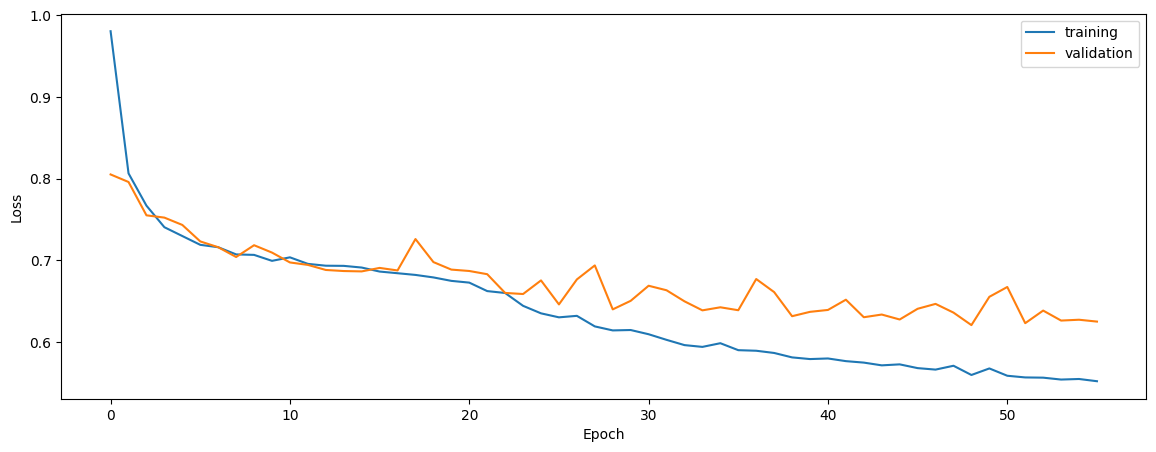

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.7614699150074382
0.7358373694441699
0.7081476579160232


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.7447060156803392
0.7040306238463093
0.7030010795699021


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.755756947470124
0.7207870229606135
0.7048047152295999


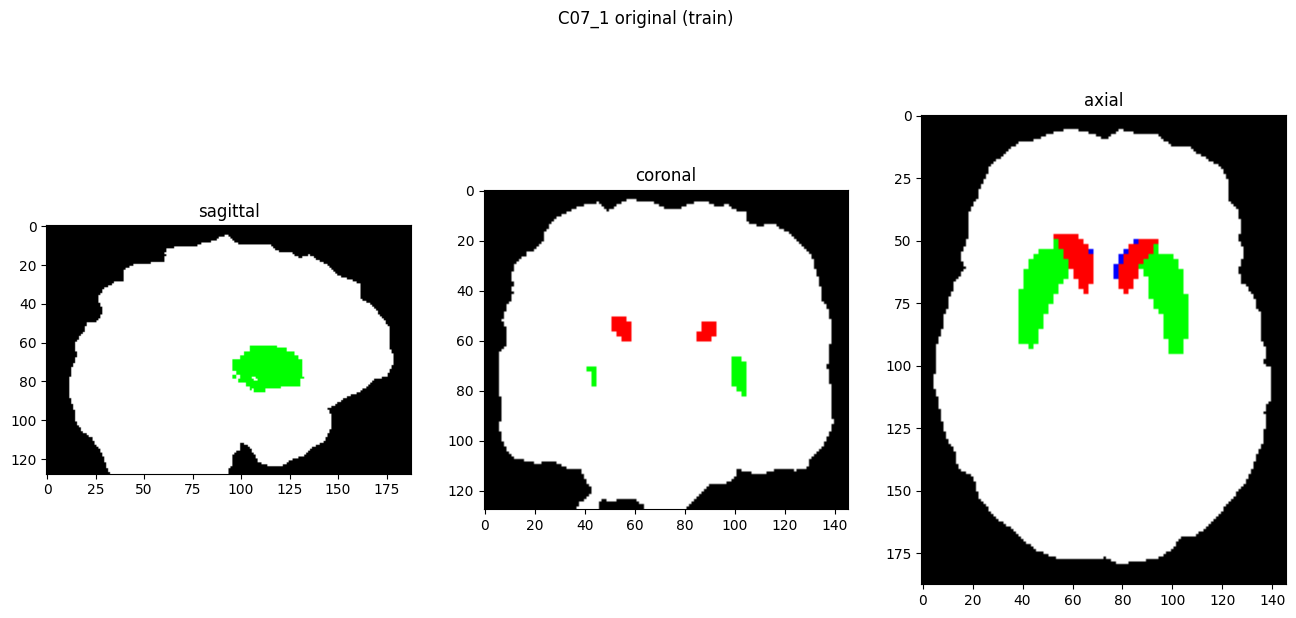

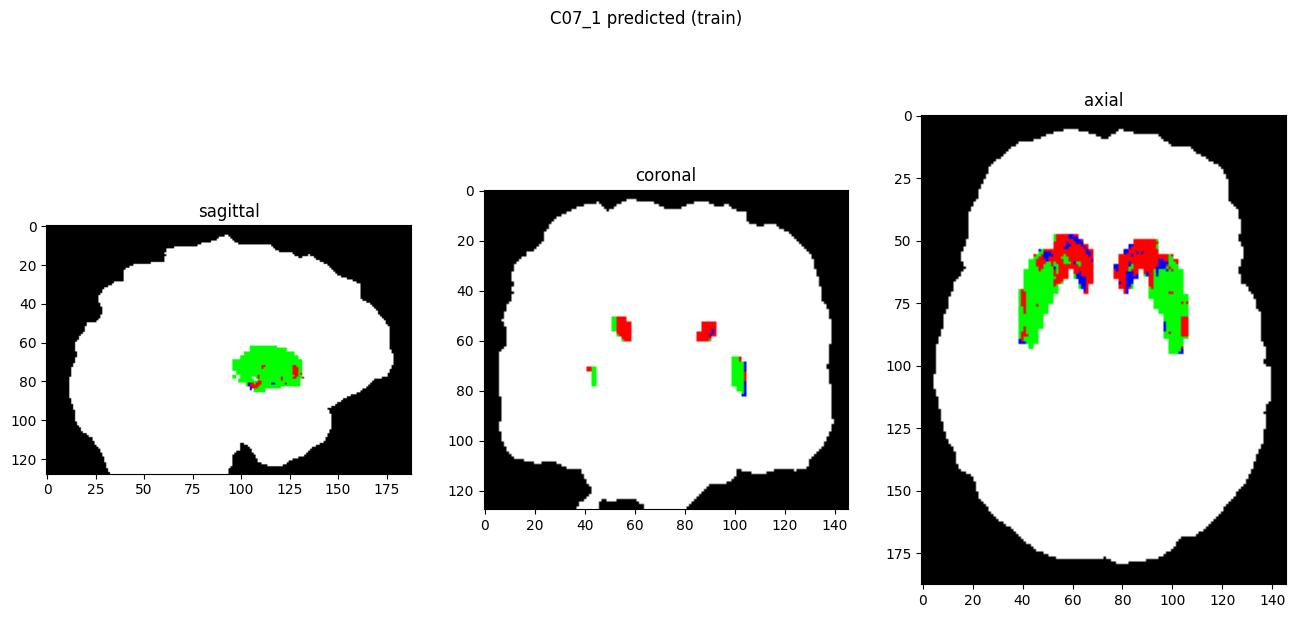

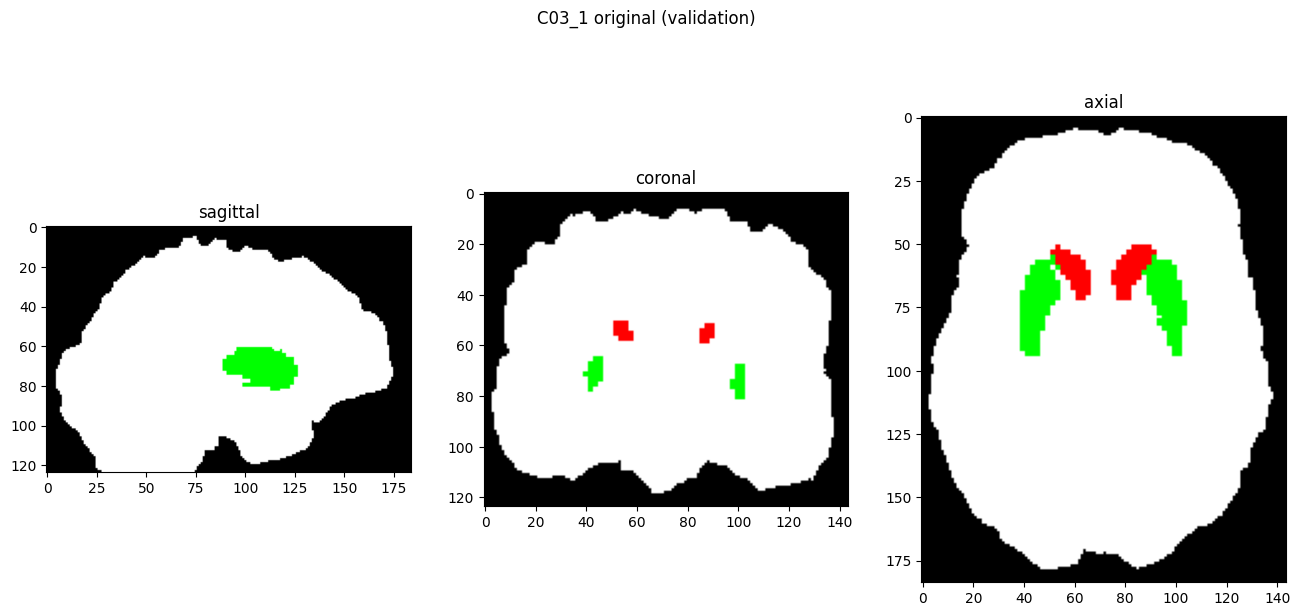

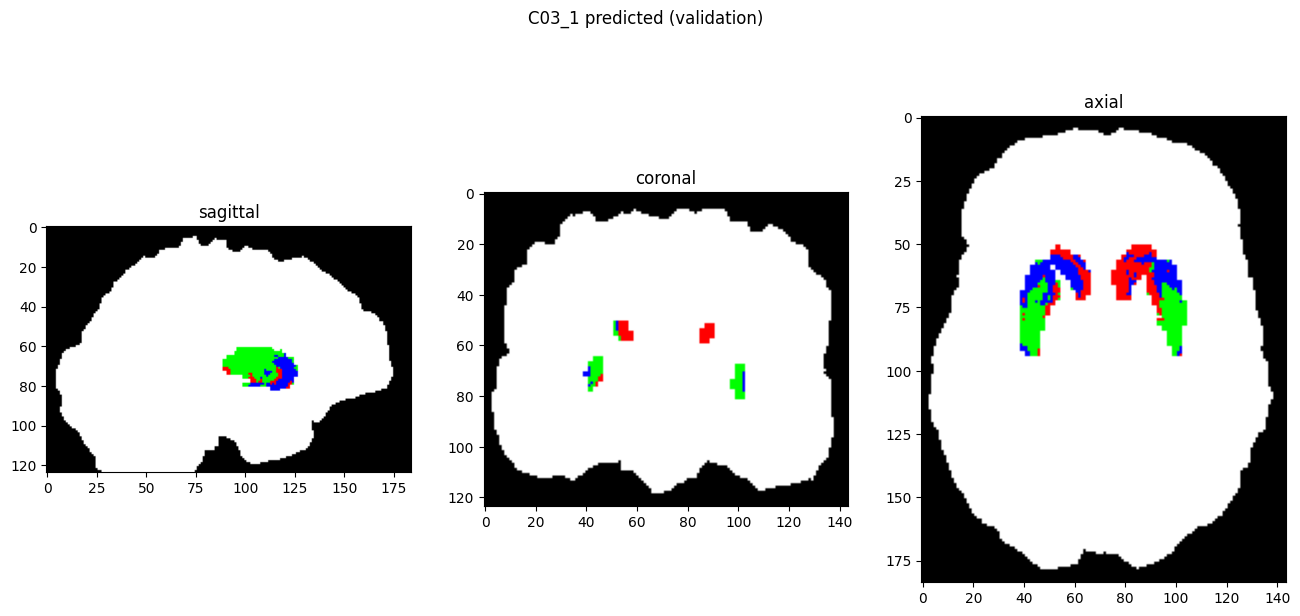

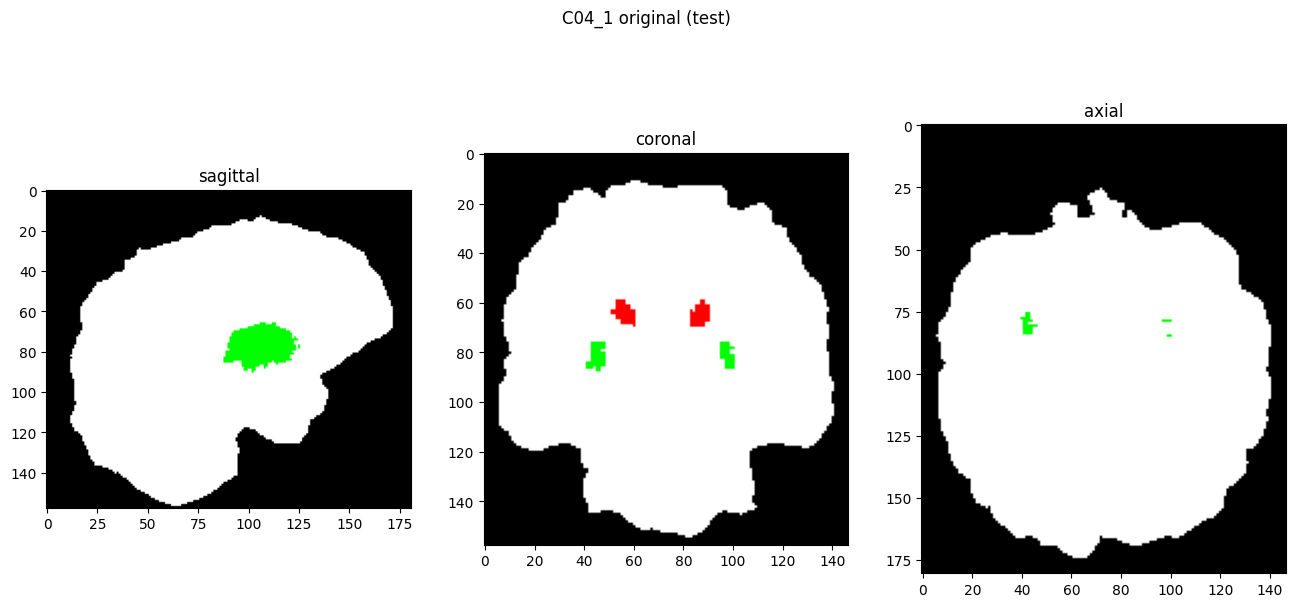

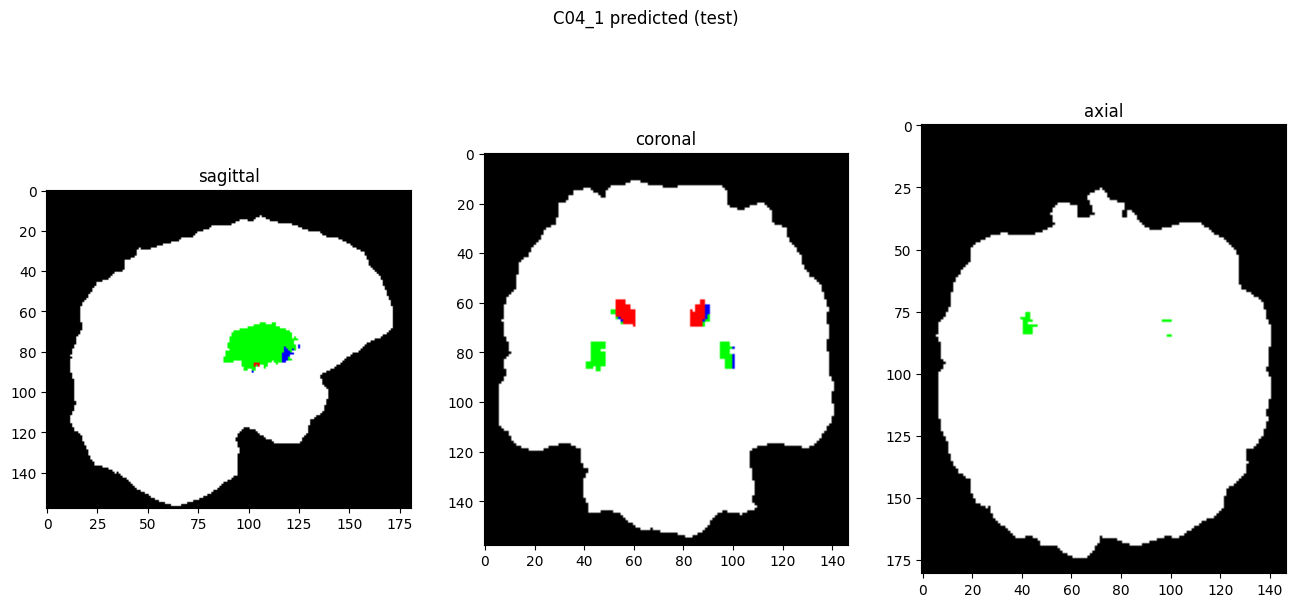

In [10]:
showResults(model, gen, threshold=0)